---
title: DS202W - Group Project 
author: "Civic Tensor"
format:
  html:
    self-contained: true
jupyter: python3
engine: jupyter
editor:
  render-on-save: true
  preview: true
---

<div style="background-color:#e0f0ff; padding:20px; border-radius:10px;">
  <b style="color:#003366; font-size:2.5em;">How best can we predict civil war?</b>
</div>

<div style="background-color:#f5fbff; padding:20px; border-radius:10px; text-align:left;">

<p><b>In this project</b>, we looked at Sambinis data to <b>analyse 88 features</b> and how they can best predict civil war. Our goal is to identify the <b>most influential variables</b> and assess the <b>predictive performance</b> of various models.</p>

</div>

<div style="background-color:#f5fbff; padding:20px; border-radius:10px; text-align:left;">

<p><b>Our analysis covers two grounds:</b></p>

<p><b>1) Supervised Learning</b><br>
&bull; We used a combination of statistical algorithms (supervised ML models), backed by solid theoretical grounding from literature for feature selection and engineering.</p>

<p><b>2) Unsupervised Learning</b><br>
&bull; Unsupervised learning is used for clustering and anomaly detection.</p>

</div>


## **Table of Contents**
- [EDA](#0-eda)
- [Feature Selection and Engineering](#1-feature-selection-and-engineering)
  - [1.1 Feature Selection](#11-feature-selection)
  - [1.2 Feature Engineering](#12-feature-engineering)
- [Unsupervised learning](#2-unsupervised-learning)
  - [2.1 Preprocessing Pipeline](#21-preprocessing-pipeline)
  - [2.2 Clustering](#22-clustering)
  - [2.3 Anomaly Detection](#23-anomaly-detection)
- [Classification models and results](#03-classification-models)
- [Overall Conclusion](#overall-conclusion)
- [References](#references)

#### **Imports**

In [236]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from typing import List

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from lets_plot import *
from lets_plot.plot import gggrid
LetsPlot.setup_html()

# Table formatting
from pytablewriter import MarkdownTableWriter

# Data exploration
import missingno as msno
import sweetviz as sv

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import VarianceThreshold

# Handling imbalance
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

# Dimensionality reduction
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from yellowbrick.cluster import KElbowVisualizer
from kneed import KneeLocator

# Modeling
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, IsolationForest
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from lightgbm.callback import early_stopping
from catboost import CatBoostClassifier
import miceforest as mf

# Metrics
from sklearn.metrics import (
    mean_absolute_percentage_error, balanced_accuracy_score, confusion_matrix,
    roc_auc_score, f1_score, precision_score, recall_score, average_precision_score,
    make_scorer, classification_report, fbeta_score, precision_recall_curve
)

# Statistical analysis
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Explainability
import shap

## **0 EDA**

In [237]:
# Read the data file
df = pd.read_csv('ds202w-group-projects-civil-war.csv')

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7140 entries, 0 to 7139
Data columns (total 94 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  7140 non-null   int64  
 1   cowcode     7140 non-null   int64  
 2   year        7140 non-null   int64  
 3   warstds     7140 non-null   int64  
 4   ager        7140 non-null   float64
 5   agexp       7140 non-null   float64
 6   anoc        7140 non-null   int64  
 7   army85      7140 non-null   float64
 8   autch98     7140 non-null   int64  
 9   auto4       7140 non-null   float64
 10  autonomy    7140 non-null   float64
 11  avgnabo     7140 non-null   float64
 12  centpol3    7140 non-null   int64  
 13  coldwar     7140 non-null   int64  
 14  decade1     7140 non-null   int64  
 15  decade2     7140 non-null   int64  
 16  decade3     7140 non-null   int64  
 17  decade4     7140 non-null   int64  
 18  dem         7140 non-null   int64  
 19  dem4        7140 non-null  

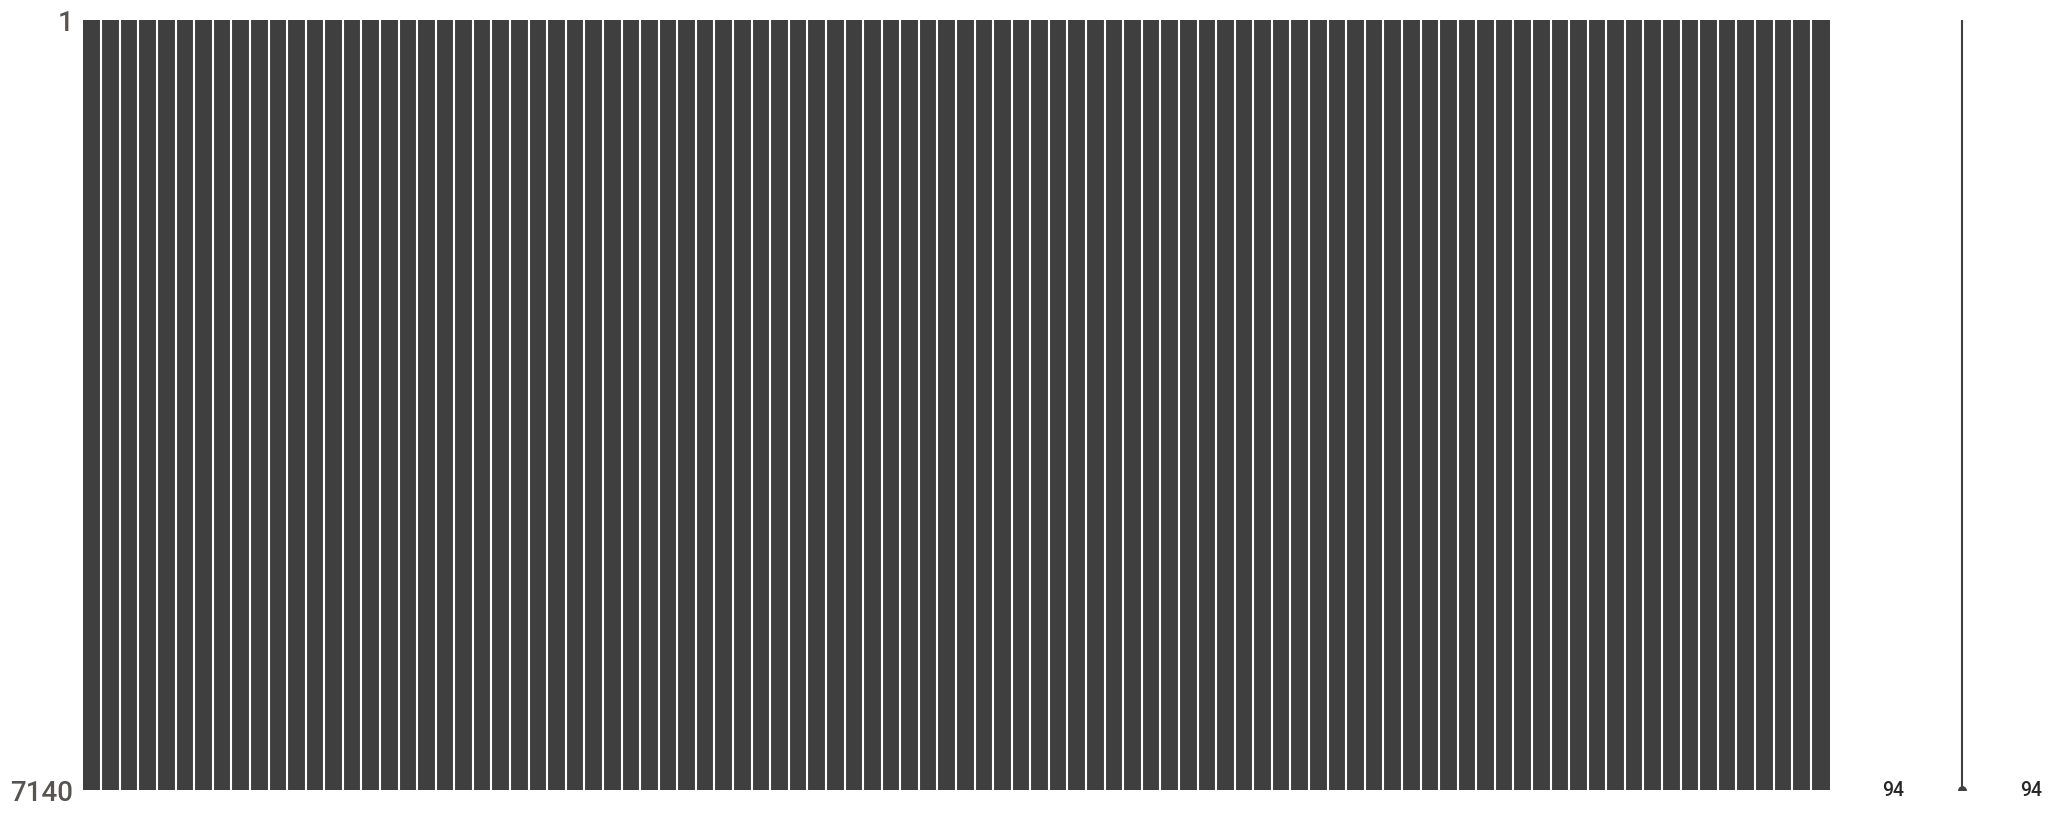

In [239]:
msno.matrix(df)
plt.show()


### Missingness Analysis

The missingness diagram for the dataset initially suggests that all features are complete, with no visible pattern of missingness. However, upon closer inspection, it becomes clear that some countries (identified by their respective `cowcodes`) have missing years for certain observations. Specifically, not all countries have data for every year, indicating a possible issue with missing values in certain time periods.

Given this, we need to investigate whether the missing data follows a **Missing At Random (MAR)**, **Missing Completely At Random (MCAR)**, or **Missing Not At Random (MNAR)** pattern before deciding if imputation is necessary. This will help determine the most appropriate approach for handling the missing values, ensuring that any imputation does not introduce bias into the analysis.



In [240]:
# Drop unnamed columns
if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

In [241]:
# Sweetviz
import sweetviz as sv
import pandas as pd

# Create and show the report
report = sv.analyze(df)
report.show_html("sweetviz_report.html", open_browser=False)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:06 -> (00:00 left)

Report sweetviz_report.html was generated.


This code (below) performs the following steps to analyse missing data for specific years (1945 to 2000) for each country (identified by `cowcode`):

1. **Filtering the Dataset**: The code filters the original dataset to include only the years between 1945 and 2000.

2. **Creating a Full Index of Expected Combinations**: It generates a complete index of all possible combinations of `cowcode` and `year` between 1945 and 2000. This index represents all the expected records for each country and year in the given range.

3. **Merging the Data**: The full index is merged with the filtered dataset to ensure that every combination of `cowcode` and `year` is accounted for. Missing values will appear as `NaN` in the merged dataset.

4. **Identifying Missing Data**: The code identifies rows where any value is missing (i.e., where there is a missing year for a specific `cowcode`).

5. **Summarizing Missing Data**: It groups the results by `cowcode` and counts the number of missing years for each country in the 1945-2000 range, providing a summary of missing years for each `cowcode`.




In [242]:
# Filter dataset to only include years between 1945 and 2000
df_filtered = df[(df["year"] >= 1945) & (df["year"] <= 2000)]

# Create full index of expected (cowcode, year) combinations in this range
expected_years = range(1945, 2001)
full_index_filtered = pd.MultiIndex.from_product([df_filtered["cowcode"].unique(), expected_years], names=["cowcode", "year"])
full_df_filtered = pd.DataFrame(index=full_index_filtered).reset_index()

# Merge with the actual data
merged_filtered = pd.merge(full_df_filtered, df_filtered, on=["cowcode", "year"], how="left")

# Identify missing combinations (i.e., missing years for specific cowcodes)
missing_filtered = merged_filtered[merged_filtered.isnull().any(axis=1)]

# Count number of missing years between 1945 and 2000 for each cowcode
missing_years_summary = missing_filtered.groupby("cowcode").size().reset_index(name="missing_years_1945_2000")

Since `cowcode` (country code) values are not easily interpretable, the dataset is merged with an external mapping of `cowcode` to country names from the **Correlates of War (COW) project**.

The code:

1. Loads the `COW-country-codes.csv` dataset, which maps `cowcode` to `country_name`, we cross-verified values to make sure this mapping was accurate with real economic data and it was mostly consistent!
2. Merges this mapping with the original dataset to make the country names interpretable.
3. Creates a full index of all possible `(cowcode, year)` combinations for the years 1945–2000.
4. Identifies missing values by merging the full index with the original dataset.
5. Summarizes the missing years for each country.

The `merged_df` is an intermediary dataset used for EDA to understand the missingness pattern. This dataset helps identify missing years for specific countries and serves as the foundation for further analysis.

**Source for Country Code Mapping**: [Correlates of War Project](https://correlatesofwar.org/)


In [243]:
cow_map = pd.read_csv("COW-country-codes.csv")

# Rename columns for clarity
cow_map = cow_map.rename(columns={"CCode": "cowcode", "StateNme": "country_name"})

# Merge to add country_name column
df = df.merge(cow_map[["cowcode", "country_name"]], on="cowcode", how="left")

# Generate all expected (cowcode, year) combinations
full_index = pd.MultiIndex.from_product([df_filtered["cowcode"].unique(), range(1945, 2001)], names=["cowcode", "year"])
full_df = pd.DataFrame(index=full_index).reset_index()

# Merge to find missing entries
merged_df = pd.merge(full_df, df_filtered, on=["cowcode", "year"], how="left")

# Add country names to merged_df
merged_df = merged_df.merge(cow_map[["cowcode", "country_name"]], on="cowcode", how="left")

# Filter for rows with missing data (i.e., missing years)
missing_years_df = merged_df[merged_df.isnull().any(axis=1)]

# Count missing years per country
missing_summary = missing_years_df.groupby(["cowcode", "country_name"]).size().reset_index(name="missing_years_1945_2000")

In [244]:
missing_summary.to_csv('missing_years.csv')

### Missing Data Summary and Interpretation

The **`missing_years_summary`** provides the count of missing years for each country between 1945 and 2000, but it doesn’t reveal which specific years are missing. Understanding the exact missing year ranges is crucial for interpretation, as this can help us link the missing years with historical events (e.g., conflicts, regime changes, etc.) that might explain the data gaps.

To address this, the code below identifies the specific years that are missing and groups them into ranges. It also enables a more detailed understanding of why certain years might be missing, based on historical contexts or events.

### Code Explanation

1. **Step 1: Filter for Missing Entries**:
   The code filters the `merged_df` to identify rows where any values are missing for the years between 1945 and 2000. It focuses on `cowcode`, `country_name`, and `year` to highlight the missing year data for specific countries.

2. **Step 2: Clean Range Builder Function**:
   The `get_missing_ranges` function takes the list of missing years for each country and groups them into consecutive ranges (e.g., 1950–1953). This provides a clearer picture of the exact periods where data is missing.

3. **Step 3: Apply the Function per Group**:
   The missing year ranges are then applied for each `cowcode` and `country_name` combination, and the result is stored in `missing_ranges`. This shows exactly which years or ranges of years are missing for each country.

4. **Step 4: Merge with the Missing Summary**:
   Finally, the missing ranges are merged with the initial `missing_years_summary`, providing a more complete picture that includes both the number of missing years and the exact year ranges that are missing.




In [245]:
# Step 1: Filter merged_df for missing entries in 1945–2000
missing_entries = merged_df[
    (merged_df["year"].between(1945, 2000)) & 
    (merged_df.isnull().any(axis=1))
][["cowcode", "country_name", "year"]]

# Ensure years are integers and drop duplicates
missing_entries["year"] = missing_entries["year"].astype(int)
missing_entries = missing_entries.drop_duplicates()

# Step 2: Clean range builder function
def get_missing_ranges(years):
    years = sorted(set(years))
    ranges = []
    start = prev = years[0]

    for year in years[1:]:
        if year == prev + 1:
            prev = year
        else:
            ranges.append(f"{start}–{prev}" if start != prev else f"{start}")
            start = prev = year
    ranges.append(f"{start}–{prev}" if start != prev else f"{start}")
    return ", ".join(ranges)

# Step 3: Apply per group
missing_ranges = (
    missing_entries.groupby(["cowcode", "country_name"])["year"]
    .apply(get_missing_ranges)
    .reset_index(name="missing_year_ranges")
)

# Step 4: Merge with missing_summary
final_missing_summary = missing_summary.merge(
    missing_ranges,
    on=["cowcode", "country_name"],
    how="left"
)

In [246]:
final_missing_summary.to_csv('final_missing_years.csv')

# Interpreting Missing Year Ranges in Civil War Dataset

#### **Why Are There Missing Years for Some Countries?**

Upon analysing the **missing\_year\_ranges** column, we find that many countries have consistent blocks of missing data at either the beginning (1945–1960s) or end (1990s–2000) of the time period. This pattern aligns closely with key historical transitions, such as:

* **Colonial independence** (gaining sovereignty in the mid–late 20th century)
* **State dissolution or unification** (e.g., breakup of Yugoslavia, German reunification)
* **Geopolitical restructuring** (e.g., federal restructuring in Ethiopia, Yemen unification)

#### **Examples: Early Missing Years (Pre-Independence)**

| Country             | Missing Years | Historical Context                        |
| ------------------- | ------------- | ----------------------------------------- |
| Bahamas             | 1945–1972     | Independence from the UK in 1973          |
| Jamaica             | 1945–1961     | Independence in 1962                      |
| Trinidad and Tobago | 1945–1961     | Independence in 1962                      |
| Belize              | 1945–1980     | Independence in 1981                      |
| Guyana              | 1945–1965     | Independence in 1966                      |
| Suriname            | 1945–1974     | Independence from the Netherlands in 1975 |

#### **Examples: Late Missing Years (Post-State Dissolution)**

| Country                 | Missing Years        | Historical Context                            |
| ----------------------- | -------------------- | --------------------------------------------- |
| Czechoslovakia          | 1993–2000            | Split into Czech Republic and Slovakia (1993) |
| German Federal Republic | 1991–2000            | German reunification (1990)                   |
| Yugoslavia              | 1991–2000            | Breakup into multiple states in early 1990s   |
| Ethiopia                | 1995–2000            | New federal constitution (1995)               |
| Yemen (North & South)   | 1945–1966, 1990–2000 | Unification in 1990                           |

#### **Conclusion**

The observed missing years are not random — they reflect genuine historical processes such as:

* The country did not exist in its modern form yet (pre-independence)
* The country ceased to exist or transformed politically, making data inconsistent
* In some cases, post-conflict reconstruction may also delay data collection



## No Imputation Required!

Given the historical context of the missing year ranges, we can conclude that **imputation is not appropriate for this project**. The missing years reflect **genuine historical processes** (e.g., colonial independence, state dissolution, and geopolitical restructuring) rather than random missingness. Therefore, the missing data is **Missing Not at Random (MNAR)**, as it is tied to specific events or transitions in a country's history.

Since we are attempting to predict civil war based on real past examples, imputing missing years could introduce bias. The missingness is linked to significant historical events, and imputation would likely distort the model’s predictions by filling in data that does not represent the actual conditions during those periods. Therefore, the missing data should be preserved, as it reflects important historical realities, and attempting to impute it could undermine the predictive validity of the model.


# Class Imbalance

In [247]:
# Check class distribution of 'warstds' feature
class_distribution = df['warstds'].value_counts(normalize=True)
print(class_distribution)


warstds
0    0.985415
1    0.014585
Name: proportion, dtype: float64


## Class Imbalance in the Target Variable (`warstds`)

We are aware that the target variable `warstds` exhibits a significant class imbalance, with 98.5% of the data belonging to the "0" class (no civil war) and only 1.5% representing the "1" class (civil war). This imbalance poses a challenge for model training, as the model may become biased toward predicting the majority class.

To address this issue, we have proposed several methods, including:

* **Downsampling**: Reducing the number of instances in the majority class ("0") to balance the dataset.
* **Upsampling**: Increasing the number of instances in the minority class ("1") to ensure the model learns to predict civil war occurrences effectively.
* **Synthetic Data Generation**: Using techniques such as **SMOTE (Synthetic Minority Over-sampling Technique)** to generate synthetic examples of the minority class.
* **Class Weights**: Assigning higher weights to the minority class during model training, so the algorithm places more emphasis on correctly predicting civil war instances.
* **Anomaly Detection Techniques**: Since the incidence of civil war is a rare event, using anomaly detection methods may help in identifying the rare class more effectively.

These are the proposed methods we can consider for addressing class imbalance. However, we will narrow down these options and select the most appropriate strategies later in the process, based on model performance and further experimentation.



# Spread of wars w.r.t Regions

In [248]:
# Geographic distribution of civil wars
# Create a region variable based on geo columns if available
geo_cols = [col for col in df.columns if col.startswith('geo')]
if geo_cols:
    region_map = {
        'geo1': 'Western Europe & North America',
        'geo2': 'Eastern Europe',
        'geo34': 'Latin America & Caribbean',
        'geo57': 'Asia & Pacific',
        'geo69': 'Middle East & North Africa',
        'geo8': 'Sub-Saharan Africa'
    }
    
    # Create region variable (using the first matching region for each row)
    region_df = df.copy()
    region_df['region'] = 'Unknown'
    for col in geo_cols:
        if col in region_map:
            mask = df[col] == 1
            region_df.loc[mask, 'region'] = region_map[col]
    
    # Create a choropleth map showing civil wars by region
    region_wars = region_df.groupby('region')['warstds'].sum().reset_index()
    region_wars.columns = ['Region', 'Number of Civil Wars']
    region_wars = region_wars.sort_values('Number of Civil Wars', ascending=False)
    
    fig = px.bar(region_wars, x='Region', y='Number of Civil Wars',
                 title='Number of Civil Wars by Region (1945-2000)',
                 color='Number of Civil Wars',
                 color_continuous_scale='Viridis')
    fig.update_layout(template='plotly_white', xaxis_tickangle=-45)
    fig.show()


## Importance of Region as a Predictor for Civil War

The plot above illustrates the number of civil wars by region between 1945 and 2000. It is clear that certain regions, such as **Sub-Saharan Africa** and **Asia & Pacific**, are more prone to civil wars, with Sub-Saharan Africa having over 30 civil wars and Asia & Pacific following closely.

This pattern suggests that **region is a significant predictor for the incidence of civil war**. Several real-world factors contribute to the higher number of civil wars in these regions:

### Sub-Saharan Africa

* **Historical Legacy**: The impact of colonialism left many African countries with artificial borders, dividing ethnic and cultural groups. This often led to political instability and struggles for autonomy.
* **Weak Governance**: Many countries in Sub-Saharan Africa have experienced fragile state structures, weak institutions, and corruption, which can contribute to internal conflict.
* **Resource Wealth**: Countries rich in natural resources (such as oil and diamonds) have often faced conflicts fueled by competition over control of these resources, leading to civil wars.
* **Examples**: The Rwandan Genocide (1994) and the Second Congo War (1998–2003) are examples where regional instability and internal conflicts have escalated into major civil wars.

### Asia & Pacific

* **Ethnic and Religious Tensions**: Many countries in Asia and the Pacific have diverse ethnic groups, which can lead to tensions and violent conflicts, especially where governments fail to address these issues.
* **Historical Conflicts**: Post-colonial struggles and the legacy of Cold War geopolitics, including U.S. involvement in Vietnam and other Southeast Asian countries, also contributed to regional instability.
* **Examples**: The Vietnam War (1955–1975), the Cambodian Civil War (1970–1975), and ongoing conflicts in Myanmar highlight the region’s vulnerability to civil war.

The disproportionate number of civil wars in these regions suggests that understanding the regional context is essential when predicting civil war. The socio-political, economic, and historical conditions in these areas make them more susceptible to conflict, which should be incorporated into our predictive models. (Which we will address later in feature engineering!)



## **| Research question: How best can we predict civil war?**

Before we delve into the details of our analysis, let us first define our target variable.  

We are interested in predicting whether a civil war onset occurred in a given country in a given year —  this is represented by the binary variable `warstds` in our dataset. A value of 1 indicates that a civil war onset occurred, while a value of 0 indicates that it did not.

How exactly do we define a civil war?  
We will proceed with the definition provided by **Sambanis (2004)** from which our dataset is derived.  
A civil war is defined as an armed conflict that meets the following criteria:

1. **Location and population**:  
   The conflict occurs within the internationally recognised borders of a state with a population of at least 500,000.

2. **Organisation and objectives**:  
   The parties involved are politically and militarily organised and pursue explicit and public political goals.

3. **Government involvement**:  
   The government (through its military or militias) is a principal combatant.  
   If no functioning government exists, the group representing the state internationally or claiming the state domestically must be involved.

4. **Insurgent recruitment and presence**:  
   Insurgent groups primarily recruit locally and maintain a territorial presence within the country,  
   although some external support or operations from neighboring countries are allowed.

5. **Conflict intensity (onset)**:  
   The conflict causes at least 500 deaths in the first year or 1,000 cumulative deaths over the first three years.

6. **Sustained violence**:  
   There is no three-year period during the conflict when the death toll falls below 500.

7. **Effective resistance**:  
   The weaker party is able to mount effective resistance, inflicting at least 100 deaths on the stronger party.  
   If the conflict becomes one-sided despite this threshold, it is no longer classified as a civil war.


## **1 Feature Selection and Engineering**  
### **1.1 Feature Selection**

#### Overall Methodology

We began the feature selection process by examining the **top variables** ranked by importance from our Random Forest model. This provided a strong empirical foundation, highlighting variables that were most predictive of civil war onset in our dataset. However, we recognized that purely data-driven rankings may include variables that are either collinear, hard to interpret, or not grounded in conflict theory.

To refine this list, we brought in **theoretical insights from the civil war literature**, especially drawing on work by Fearon & Laitin (2003), Hegre et al. (2001), and Blair & Sambanis (2020). We used this to distinguish between **structural variables** (long-term conditions like geography, development, and ethnic composition) and **procedural variables** (short-term political dynamics like regime instability or repression). This framework allowed us to ensure our model captured both the underlying risk factors (“dry wood”) and the escalation triggers (“sparks”).

We then **cross-referenced the theory-driven variables with our top variables**, retaining those that were both theoretically justified and statistically important. In cases where theoretically significant variables were not among the top 16, we included them selectively—especially if they addressed mechanisms not already captured. 

This combined approach helped us arrive at a **final set of features for regression that is both interpretable and empirically robust**. While we did not manually add interaction terms (given the additive structure of logistic regression), we acknowledge this as a known limitation of the model—one that more flexible algorithms like Random Forest and LightGBM can handle more effectively by capturing non-linear interactions implicitly.

Finally, we benchmarked our selected features against those used in Blair & Sambanis (2020), noting substantial overlap—such as in the inclusion of `ln_gdpen`, `milper`, `infant`, `elfo`, `lpopns`, `polcomp`, and `lmtnest`—which further reinforces the theoretical validity of our final model.


#### Note: Dropping **`ln_gdpen`**

We have decided to exclude the variable **`ln_gdpen`** from our analysis. This decision was made after we noticed that it was not listed in the appendix detailing the variable definitions, which raised concerns about its accuracy and source. Initially, we assumed **`ln_gdpen`** represented the natural log of GDP per capita. However, after cross-referencing the values with World Bank data, we found significant inconsistencies. Despite manually calculating the values and adjusting for potential scaling, the results did not align with the real data, which was puzzling given that other variables, like **`lpopns`** (the natural log of population), were perfectly consistent.

Due to these discrepancies, and the lack of clear documentation or supporting information, we chose to exclude **`ln_gdpen`** in order to maintain the integrity and reliability of our dataset. Unfortunately, we were unable to supplement this variable with data from other sources, as they did not provide the same level of comprehensiveness as the dataset we are currently working with. (World Bank data was from 2000 onwards.)

#### **1.1.1 Data-Driven Rankings of Feature Importance**

> **Visualising Class Distribution**

In [249]:
# Target variable analysis
print("\nTarget variable (warstds) distribution:")
target_counts = df['warstds'].value_counts()
print(target_counts)
print(f"Percentage of civil wars: {target_counts[1] / len(df) * 100:.2f}%")


Target variable (warstds) distribution:
warstds
0    8243
1     122
Name: count, dtype: int64
Percentage of civil wars: 1.46%


In [250]:
# Group by year and sum warstds
yearly_war_sum = df.groupby('year')['warstds'].sum().reset_index()

# Line plot of warstds over time
fig = px.line(yearly_war_sum, x='year', y='warstds',
              title='Total War Occurrences Over Time',
              labels={'warstds': 'Total War Occurrences', 'year': 'Year'},
              markers=True)

fig.update_traces(line=dict(color='#00A7E1'))
fig.update_layout(template='plotly_white')
fig.show()

We set the threshold year as between 1978 to 1989, for a 60:40 to 80:20 train split, and found the threshold year with the least class imbalance between train and test set. 

In [251]:
def find_best_split_year(df, start_year=1978, end_year=1990, class_col='warstds', year_col='year'):
    potential_years = range(start_year, end_year)

    best_year = None
    best_difference = float('inf')

    for year in potential_years:
        train_data = df[df[year_col] <= year]
        test_data = df[df[year_col] > year]

        total_records = len(df)
        train_ratio = len(train_data) / total_records
        test_ratio = 1 - train_ratio

        # Calculate class distributions
        train_dist = train_data[class_col].value_counts(normalize=True)
        test_dist = test_data[class_col].value_counts(normalize=True)

        # Calculate difference between class distributions
        diff_class0 = abs(train_dist[0] - test_dist[0])
        diff_class1 = abs(train_dist[1] - test_dist[1])
        total_diff = diff_class0 + diff_class1

        if total_diff < best_difference:
            best_difference = total_diff
            best_year = year
            best_split_info = (train_ratio, test_ratio)

    if best_year is not None:
        print(f"Best Year for Split: {best_year}")
        print(f"Split Ratio (Train:Test): {best_split_info[0]*100:.0f}:{best_split_info[1]*100:.0f}")
    else:
        print("No valid split year found.")

# Call the function
find_best_split_year(df)

Best Year for Split: 1987
Split Ratio (Train:Test): 71:29


Since the threshold year is 1987, the train-test split is 71:29.

> **Baseline Random Forest Model**

In [252]:
def train_test(df, X, y, feature_cols, year=1987):
    train_mask = df['year'] < year
    test_mask = df['year'] >= year

    X_train = X.loc[train_mask, feature_cols]
    X_test = X.loc[test_mask, feature_cols]

    y_train = y[train_mask]
    y_test = y[test_mask]

    return X_train, X_test, y_train, y_test

In [253]:
def get_predictions(model, X_train, X_test):
    y_train_pred = model.predict(X_train)
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_test_pred = model.predict(X_test)
    y_test_pred_proba = model.predict_proba(X_test)[:, 1]
    
    return y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba

In [254]:
target_col = 'warstds'
feature_cols = [col for col in df.columns if col not in [target_col, 'cowcode', 'year', 'ln_gdpen', 'country_name']] # ln_gdpen is removed as explained below

X = df[feature_cols + ['year']].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test(df, X, y, feature_cols)

rf = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    n_jobs=-1,
    n_estimators=100,        
    max_depth=None,          
    min_samples_split=2      
)
rf.fit(X_train, y_train)


y_train_pred, y_train_pred_proba, y_test_pred, y_test_pred_proba = get_predictions(rf, X_train, X_test)

# Evaluate
print("TRAINING SET PERFORMANCE")
print("ROC-AUC:", roc_auc_score(y_train, y_train_pred_proba))
print("F1-score:", f1_score(y_train, y_train_pred)) 
print(classification_report(y_train, y_train_pred, digits=3))

print("\nTEST SET PERFORMANCE")
print("ROC-AUC:", roc_auc_score(y_test, y_test_pred_proba))
print("F1-score:", f1_score(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred, digits=3))

TRAINING SET PERFORMANCE
ROC-AUC: 1.0
F1-score: 1.0
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      5659
           1      1.000     1.000     1.000        88

    accuracy                          1.000      5747
   macro avg      1.000     1.000     1.000      5747
weighted avg      1.000     1.000     1.000      5747


TEST SET PERFORMANCE
ROC-AUC: 0.8945148879985431
F1-score: 0.0
              precision    recall  f1-score   support

           0      0.987     1.000     0.993      2584
           1      0.000     0.000     0.000        34

    accuracy                          0.987      2618
   macro avg      0.494     0.500     0.497      2618
weighted avg      0.974     0.987     0.981      2618



#### **Why We Use ROC-AUC**

The target variable `warstds`, which indicates the onset of civil war, is highly imbalanced — with far fewer conflict cases (`1`) than non-conflict cases (`0`). In such class-dominated datasets, standard evaluation metrics like accuracy can be misleading, as a model could achieve high accuracy by simply predicting the majority class.

To address this, we use **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**, which offers several advantages:

- **Threshold independence**: ROC-AUC evaluates model performance across all classification thresholds, rather than a fixed cutoff like 0.5.
- **Sensitivity to ranking**: It measures the model’s ability to rank positive instances (conflict) above negative ones (non-conflict), which is crucial when predicting rare but impactful events.
- **Robustness to imbalance**: Unlike precision or accuracy, ROC-AUC remains informative and interpretable even when classes are highly imbalanced. In imbalanced settings like this where one class (presence of civil war) is rare, metrics like accuracy can be misleading. A classifier that always predicts the majority class might still have high accuracy but low ROC-AUC. Therefore, ROC-AUC is better suited to evaluate whether the model is actually learning meaningful signals to separate the classes, even when one is underrepresented. We also set class_weight='balanced' (for this code chunk and the ones after!) to adjust the weights inversely proportional to class frequencies. This means the model pays more attention to the minority class, helping it avoid being overwhelmed by the majority class. This modifies the loss function to penalize misclassification of minority samples more heavily, which helps with learning meaningful decision boundaries even under imbalance.






In [255]:
def plot_feat_importance(model, feature_names, model_type, title, top_n=20):
    if model_type == 'random_forest':
        importances = model.feature_importances_
    elif model_type == 'logistic':
        importances = np.abs(model.coef_[0])
    else:
        raise ValueError("model_type must be either 'random_forest' or 'logistic'")
    
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    top_features = feature_importance.head(top_n)

    fig = px.bar(
        top_features.sort_values('Importance'),
        x='Importance',
        y='Feature',
        orientation='h',
        title=title or f"Top {top_n} Feature Importances",
        height=600,
        color_discrete_sequence=["#107AB0"]
    )
    fig.update_layout(template='plotly_white')
    fig.show()
    return feature_importance

In [256]:
feature_importance_rf = plot_feat_importance(
    rf, feature_cols, model_type='random_forest',
    title='Top 20 Feature Importance in Random Forest Model'
)

| **Variable**  | **Description** |
|---------------|-----------------|
| `illiteracy`  | % of adult population that is illiterate *(WDI)* |
| `infant`      | Infant mortality rate *(WDI)* |
| `sxpsq`       | Primary commodity exports as a % of GDP, squared |
| `expgdp`      | Exports of goods & services as % of GDP *(WDI)* |
| `trade`       | Trade as % of GDP, in 1995 constant dollars |
| `sxpnew`      | Primary commodity exports as a % of GDP |
| `nmgdp`       | Neighbors’ average log(GDP per capita) |
| `life`        | Life expectancy at birth *(WDI)* |
| `agexp`       | Agricultural raw materials exports as % of merchandise exports *(WDI)* |
| `fuelexp`     | Fuel and oil products exports as % of merchandise exports *(WDI)* |
| `seceduc`     | School enrollment, secondary, % gross *(WDI)* |
| `manuexp`     | Manufactures exports as % of merchandise exports *(WDI)* |
| `gdpgrowth`   | Annual GDP growth rate (%) |
| `army85`      | Size of government army in 1985 |
| `pri`         | School enrollment, primary, % gross *(WDI)* |
| `milper`      | Military manpower in thousands |
| `popdense`    | Population density: people per square km *(WDI)* |
| `lpopns`      | Log of population (ln) |
| `elfo2`       | Ethnolinguistic diversity, squared |
| `lmtnest`     | Rough terrain |

> **Rationale**  
> * VIF (Variance Inflation Factor) is a diagnostic measure used to detect multicollinearity in regression models. 
> * Multicollinearity occurs when one predictor variable is highly correlated with one or more other predictors, making it difficult to estimate their individual effects accurately.

> **Methodology**  
> Aim: Identify and drop redundant features that introduce multicollinearity.
>
> * Features like `sxpnew` and `life` were removed because they had high VIF scores, indicating overlap or duplication with other variables.
> * This helps to ensure that the model's coefficients are more stable and interpretable.

In [257]:
def calculate_vif(df: pd.DataFrame, drop_cols: List[str] = None) -> pd.DataFrame:
    if drop_cols:
        df = df.drop(columns=drop_cols)
        
    # Drop rows with missing values
    df = df.dropna()

    # Only select numeric columns
    num_features = df.select_dtypes(include=[np.number]).columns
    X = df[num_features]

    # Add a constant for intercept (needed by statsmodels)
    X = X.assign(const=1)

    vif_data = pd.DataFrame({
        "feature": X.columns,
        "VIF": [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    })

    # Drop the constant term from result
    vif_data = vif_data[vif_data["feature"] != "const"]

    return vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)

In [258]:
top20_features = feature_importance_rf.sort_values(by='Importance', ascending=False).head(20)['Feature'].tolist()
subset_df = df[top20_features]
vif_top20 = calculate_vif(subset_df)
print(vif_top20)

       feature       VIF
0         life  7.408922
1       sxpnew  5.415959
2       infant  5.115130
3        sxpsq  3.855937
4      seceduc  3.238856
5       expgdp  3.017929
6       army85  2.636711
7      manuexp  2.413091
8       milper  2.279233
9          pri  2.081364
10       nmgdp  2.060617
11      lpopns  1.913516
12       trade  1.827522
13  illiteracy  1.796105
14       elfo2  1.601772
15     fuelexp  1.516942
16    popdense  1.516789
17       agexp  1.285502
18     lmtnest  1.154697
19   gdpgrowth  1.019884


**Features to drop:**  
* **`life`** – highly correlated with `infant`, highest multicollinearity
* **`sxpnew`** – square of `sxpsq`, introduces redundancy and potential multicollinearity
* **`expgdp`** – highly correlated with trade and sxpnew, adds little unique explanatory power
* **`trade`** – captures similar variance as expgdp and sxpnew, redundant in presence of sxpsq

In [259]:
drop_features = ['life', 'sxpnew', 'expgdp', 'trade']
updated_top20_features = [feature for feature in top20_features if feature not in drop_features]
subset_df = df[updated_top20_features]
vif_top20 = calculate_vif(subset_df)
print(vif_top20)

       feature       VIF
0       infant  3.171876
1      seceduc  2.941611
2       army85  2.623647
3       milper  2.276052
4      manuexp  2.106527
5        nmgdp  1.942690
6   illiteracy  1.786117
7          pri  1.772058
8       lpopns  1.564095
9      fuelexp  1.416168
10       elfo2  1.413488
11       agexp  1.270094
12       sxpsq  1.212269
13     lmtnest  1.126667
14    popdense  1.117208
15   gdpgrowth  1.018279


These are the final 16 features, derived from statistical analysis, with all VIF < 5, indicating no severe multicollinearity. 

#### **1.1.2 Theoretically relevant features**

> **From Random Forest Rankings to Theory-Guided Feature Selection**

In the previous section, we used a Random Forest model to identify the top 20 features ranked by importance. From there, we narrowed it down to 16 variables to reduce multicollinearity. While this gave us a strong empirical baseline, our final feature set **deviates slightly from the purely data-driven list**—and deliberately so.

Rather than relying solely on model-driven rankings, we prioritized features that are **theoretically grounded** in political science and conflict research. Specifically, we selected a **mixture of structural and procedural variables**, drawing from well-established literature on civil war onset (e.g., Fearon & Laitin, 2003; Blair & Sambanis, 2020; Hegre et al., 2001).

This approach reflects two key considerations:

* **Structural variables** capture slow-changing fundamentals such as geography, economic development, and ethnic composition. These help define the baseline “at-risk” set of countries over time.
* **Procedural variables**, in contrast, reflect dynamic processes like regime instability, repression, and political transitions—factors that help us pinpoint *when* conflict is likely to erupt.

Together, these variables **span a wide range of theoretical mechanisms**: state capacity, opportunity costs, identity-based grievances, and elite instability, among others. Although this led us to exclude a few machine-prioritized features (e.g., redundant lags or collinear proxies), it allowed us to build a model that is not only predictive but also **interpretable and grounded in causal theory**.

This balance strengthens both the academic validity of our analysis and the policy relevance of our results. As Blair & Sambanis (2020) argue, combining slow-moving “dry wood” with fast-moving “sparks” is essential for modeling civil war risk effectively.



> **01 Structural (slow-moving “dry-wood”) variables**

| Feature                                        | Why it matters (theory)                                                                                                                  | Key citation                                                               |
| ---------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------- | -------------------------------------------------------------------------- |
| **`lmtnest` (Mountainous / rough terrain)**    | Guerrilla forces can hide, resupply and avoid decisive engagement; states face high policing costs in such terrain.                      | Fearon & Laitin 2003 ([Cambridge University Press & Assessment][1])        |
| **`popdense` (Population density)**            | Sparse populations lower the risk of informers and make it harder for the state to monopolise violence, easing insurgency organisation.  | Fearon & Laitin 2003 ([Cambridge University Press & Assessment][1])        |
| **`ef` (Ethnic fractionalisation)**            | Ethnic cleavages provide mobilisation frames and can sharpen grievances if political power is unequally shared.                          | Cederman, Wimmer & Min 2010 ([Cambridge University Press & Assessment][2]) |
| **`gdp_growth` (GDP Growth (%))**            | Higher average income proxies both state capacity and individual opportunity costs of fighting; poverty therefore raises civil-war risk. | Collier & Hoeffler 2004 ([OUP Academic][3])                                |
| **`sxpnew` (Primary-commodity exports % GDP)** | Lootable or taxable natural-resource rents can finance rebellion and create a “resource curse” incentive for violence.                   | Ross 2004 ([JSTOR][4])                                                     |

[1]: https://www.cambridge.org/core/journals/american-political-science-review/article/ethnicity-insurgency-and-civil-war/B1D5D0E7C782483C5D7E102A61AD6605?utm_source=chatgpt.com "Ethnicity, Insurgency, and Civil War | American Political Science ..."
[2]: https://www.cambridge.org/core/journals/world-politics/article/why-do-ethnic-groups-rebel-new-data-and-analysis/4F69AEFBD88FAADE63207FF7D1F69449?utm_source=chatgpt.com "Why Do Ethnic Groups Rebel? New Data and Analysis | World Politics"
[3]: https://academic.oup.com/oep/article-abstract/56/4/563/2361902?utm_source=chatgpt.com "Greed and grievance in civil war | Oxford Economic Papers"
[4]: https://www.jstor.org/stable/4149748?utm_source=chatgpt.com "What Do We Know about Natural Resources and Civil War? - jstor"


> **02 Procedural / dynamic (“spark”) variables**

| Feature                                                                     | Why it matters (theory)                                                                                                              | Key citation                                                        |
| --------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------ | ------------------------------------------------------------------- |
| **`inst3` (Recent political instability)**                                  | Abrupt regime shocks undermine elite bargains and enforcement capacity, opening a “window of opportunity” for challengers.           | Blair & Sambanis 2020 ([SAGE Journals][1])                          |
| **`polch98`, `demch98`, `autch98` (Annual change in Polity / regime type)** | Transitional regimes are especially prone to civil war because institutions are fluid and actors cannot credibly bind one another.   | Hegre et al. 2001 ([Cambridge University Press & Assessment][2])    |
| **`durable` (Regime age / years since last transition)**          | The longer a regime survives, the more it consolidates authority and lowers conflict risk; very young regimes lack these buffers.    | Goldstone et al. 2010 ([Wiley Online Library][3])                   |
| **`milper_ratio` (Military personnel per capita / growth-adjusted)**        | State coercive capacity can deter insurgency, but rapid expansions or contractions signal fear or weakness and may provoke violence. | Fearon & Laitin 2003 ([Cambridge University Press & Assessment][4]) |
| **`polcomp` (Political competition)**                                       | Low or suppressed competition fuels grievances and removes peaceful channels for dissent, increasing rebellion incentives.           | Gurr 1970 ([Accessed in Person @ LSE Library][5])                                             |

[1]: https://journals.sagepub.com/doi/abs/10.1177/0022002720918923?utm_source=chatgpt.com "Forecasting Civil Wars: Theory and Structure in an Age of “Big Data ..."
[2]: https://www.cambridge.org/core/journals/american-political-science-review/article/toward-a-democratic-civil-peace-democracy-political-change-and-civil-war-18161992/49244FF48139A3516DB45FF294902F6A?utm_source=chatgpt.com "Toward a Democratic Civil Peace? Democracy, Political Change ..."
[3]: https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1540-5907.2009.00426.x?utm_source=chatgpt.com "A Global Model for Forecasting Political Instability - Goldstone - 2010"
[4]: https://www.cambridge.org/core/journals/american-political-science-review/article/ethnicity-insurgency-and-civil-war/B1D5D0E7C782483C5D7E102A61AD6605?utm_source=chatgpt.com "Ethnicity, Insurgency, and Civil War | American Political Science ..."
[5]: https://www.amazon.com/Why-Men-Rebel-Robert-Gurr/dp/1594519145?utm_source=chatgpt.com "Why Men Rebel - Gurr, Ted Robert: Books - Amazon.com"


> **Creation of Milper Ratio**

Unlike using `milper` and `lpopns` as separate covariates, `milper_ratio` captures the density of state military presence — a theoretically significant concept in civil war research. As Fearon and Laitin (2003) argue, rebel groups are more likely to organise in areas where the state has limited ability to project coercive power. A high value of `milper_ratio` suggests stronger deterrent capacity, while a low value indicates potential state weakness.

*(We are essentially controlling for scale here — think of the US having 50,000 troops vs Vatican City 100 troops; the ratio ensures proper reflection of military power!)*


In [260]:
df['pop'] = np.exp(df['lpopns'])
df['milper_ratio'] = df['milper'] / df['pop']

We also acknowledge a key modeling limitation:
For models like logistic regression, which assume additive linear effects, capturing the interaction between “dry wood” and “spark” dynamics requires explicit interaction terms (e.g., ef × inst3). Without them, important escalation dynamics can be missed.

By contrast, tree-based models like Random Forests and LightGBM can implicitly learn non-linear interactions and conditional effects. This makes them better suited to handle complex relationships without requiring hand-coded interactions—though we still prioritised theoretical grounding to avoid overfitting or spurious inference.

In this project, we chose not to include interaction terms manually, in order to maintain comparability across models and avoid overcomplicating the regression specification. Instead, we treat this as a known drawback of logistic regression, which limits its ability to fully model the interaction between structural and procedural risks. Tree-based models, by contrast, are more flexible in uncovering such interactions organically, which might partially explain why their performance does not suffer as much from this omission.


#### **1.1.3 Final Feature Selection: Integrating Statistical Importance with Conflict Theory**

##### **(1/2) Top 16 Statistically Ranked Features**

We began by identifying the **top 16 features from Random Forest and VIF-based diagnostics**. These included a broad mix of economic, demographic, and military indicators (that we manually grouped into these broad categories!) such as:

* **Development & Economy**: `nmgdp`, `manuexp`, `fuelexp`, `gdpgrowth`, `infant`, `illiteracy`, `pri`, `seceduc`
* **Military**: `milper`, `army85`
* **Ethnicity & Demographics**: `sxpsq`, `agexp`, `lpopns`, `popdense`, `elfo2`
* **Institutional / Geographic**: `lmtnest`

These variables were chosen purely based on statistical signal (e.g., permutation importance), but we recognized that **not all of them were directly interpretable within a civil war framework**.


##### **(2/2) Applying Theoretical Filters**

Next, we brought in **theory-driven criteria** based on established literature (e.g., Fearon & Laitin, 2003; Blair & Sambanis, 2020; Hegre et al., 2001). We focused on variables that capture either:

* **Structural risk**: Long-term country conditions like geography, ethnic divisions, and development ("dry wood")
* **Procedural risk**: Short-term political volatility and repression ("sparks")

We then **cross-referenced the top 16 statistically ranked features with our theory-driven candidates**, identifying three categories:


##### **Retained Variables (Strong Theoretical + Statistical Overlap)**

| Feature        | Type       | Reason for Inclusion                                                       |
| -------------- | ---------- | -------------------------------------------------------------------------- |
| `gdp_growth`   | Structural | High empirical rank + key proxy for opportunity costs of rebellion         |
| `infant`       | Structural | Strong dev. indicator, aligns with state weakness literature               |
| `illiteracy`   | Structural | Captures grievances and recruitment capacity                               |
| `milper_ratio` | Procedural | Key indicator of state coercive capacity, commonly used in conflict models |
| `elfo2`         | Structural | Measures ethnic fractionalization (based on language), central to identity-based conflict      |
| `lpopns`       | Control    | Used to normalize scale effects, standard in B\&S models                   |
| `lmtnest`      | Structural | Rough terrain facilitates insurgency operations                            |
| `sxpsq`        | Structural | Squared resource export term captures non-linear effects (resource curse)  |


##### **Theory-Driven Additions (Not in Top 16 but Critical)**

| Feature   | Type       | Reason for Inclusion                                                                        |
| --------- | ---------- | ------------------------------------------------------------------------------------------- |
| `durable` | Procedural | Captures regime longevity; unstable regimes more prone to conflict (Goldstone et al., 2010) |
| `polcomp` | Procedural | Repression/limited competition heightens grievance (Gurr, 1970)                             |
| `autch98` | Procedural | Recent autocratic transitions increase volatility (Hegre et al., 2001)                      |

Although these were not statistically top-ranked, they are **widely cited in the conflict literature** and cover escalation mechanisms underrepresented in the top 16 list. Therefore, we felt it was important to still consider them! 


##### **Variables Dropped from Top 16 (With Rationale)**

| Feature                                    | Reason for Exclusion                                               |
| ------------------------------------------ | ------------------------------------------------------------------ |
| `army85`                                   | Redundant with `milper_ratio` and less interpretable               |
| `nmgdp`, `manuexp`, `fuelexp`, `gdpgrowth` | Overlap with `ln_gdpen`; not theoretically unique                  |
| `agexp`                                    | Weak theoretical grounding in civil war models                     |
| `parreg`                                   | Somewhat collinear with `polcomp`, weaker theoretical signal       |
| `pri`                                      | Closely mirrors `illiteracy` and `infant` in development signaling |

By focusing on variables that capture **distinct theoretical mechanisms**, we avoided overfitting or multicollinearity while maintaining interpretability.


##### **Summary: Final Feature Set**

Our final logistic regression model includes the following **11 features**, balancing theory, empirical signal, and model parsimony:

* **Structural**: `ln_gdpen`, `infant`, `illiteracy`, `elfo`, `sxpsq`, `lmtnest`
* **Procedural**: `milper_ratio`, `durable`, `polcomp`, `autch98`
* **Control**: `lpopns`

We included `lpopns`, the natural logarithm of a country’s population, as a control variable in our final model. While population size is not a direct theoretical driver of civil war onset, it plays an important role in conditioning the environment in which conflict dynamics unfold. Larger countries, by virtue of their size, may naturally experience more conflict-related events simply due to scale. Including lpopns allows us to account for these scale effects and ensures that our results are not biased by differences in population when assessing the influence of other factors like economic development or military capacity. 

In the conflict literature, this practice is standard. For instance, Blair and Sambanis (2020) and Fearon and Laitin (2003) both routinely include population (often in log form) to correct for underlying differences in exposure to civil war risk. 

In [261]:
correlation = df[['elfo', 'ef']].corr().loc['elfo', 'ef']
print("Correlation between elfo and ef:", correlation)

Correlation between elfo and ef: 0.663415927070515


Note: elfo and ef both represent ethnic fractionalisation, but elfo is on linguistic lines and ed is along ethnic lines. In many countries, ethnicity and language are tightly linked (e.g., in Sub-Saharan Africa or South Asia), leading to high correlation between ef and elfo. Thus, including both may introduce multicollinearity without adding substantial new information. Therefore ef will be dropped as elfo (elfo2) is more important for model based on feature importances!

##### **Overlapping Features with Blair & Sambanis**

The following variables are present in **both our model and Blair & Sambanis' specification**:

* `gdp_growth` – economic development
* `infant` – development/health indicator
* `milper` / `milper_ratio` – coercive capacity (different versions)
* `elfo2` – ethnic fractionalization
* `lmtnest` – rough terrain
* `lpopns` – log population (control for scale)
* `polcomp` – level of political competition
* `autch98` – recent autocratic transition

These shared features reflect a **strong convergence in theoretical foundations** (phew)


##### **Are we outperforming the study, Blair and Samabanis (2004)?**

This analysis aims to evaluate **how well each model distinguishes between cases of civil war onset (`warstds = 1`) and peace (`warstds = 0`)**. Instead of focusing on in-sample model fit (like pseudo R²), we assess the **classification performance** using the **ROC-AUC score** — a widely used metric in predictive modeling.


##### **Our Methodology**

1. **Define the feature sets**:

   * `features_ours` includes the streamlined set of structural and procedural variables we selected based on theory and empirical importance.
   * `features_bs` includes the full set of institutional, ethnic, and economic indicators used by Blair & Sambanis.

2. **Prepare the data**:
   The predictors (`X`) are extracted from the DataFrame, and the target variable (`y`) is set as civil war onset (`warstds`). The predictors are standardized to ensure comparability.

3. **Fit two logistic regression models**:
   One model is fit using our features, and the other using the Blair & Sambanis features.

4. **Generate predicted probabilities**:
   For each observation, the models output a probability estimate of civil war onset.

5. **Calculate ROC-AUC scores**:
   The `roc_auc_score` function computes the **Area Under the ROC Curve** for each model. This score reflects the model’s ability to **rank true civil war cases higher than non-cases across all possible thresholds**.


##### **Evaluation**

By comparing the **ROC-AUC scores** of the two models, the code directly assesses **which set of features is more effective for classifying civil war risk**. A higher AUC score indicates better predictive performance, meaning that the model is more likely to assign higher probabilities to actual war-onset years than to peaceful years. 



In [262]:
# Define feature sets
features_ours = ['gdpgrowth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                 'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns']

features_bs = ['ln_gdpen', 'infant', 'milper', 'elfo', 'elfo2', 'oil',
               'lmtnest', 'lpopns', 'polcomp', 'autch98', 'pol4',
               'dem', 'dem4', 'parcomp', 'auto4', 'autonomy']

# Prepare data - drop rows with NaN values
X_ours = df[features_ours].copy().dropna()
X_bs = df[features_bs].copy().dropna()

# Align target variable
y_ours = df.loc[X_ours.index, 'warstds']
y_bs = df.loc[X_bs.index, 'warstds']

# Create DataFrames with only the needed features for train_test function
df_ours = df.loc[X_ours.index].copy()
df_bs = df.loc[X_bs.index].copy()

# Standardize features
scaler = StandardScaler()
X_ours_scaled = pd.DataFrame(
    scaler.fit_transform(X_ours), 
    index=X_ours.index, 
    columns=X_ours.columns
)

scaler = StandardScaler()  # New scaler for BS features
X_bs_scaled = pd.DataFrame(
    scaler.fit_transform(X_bs), 
    index=X_bs.index, 
    columns=X_bs.columns
)

# Use train_test function for both feature sets
Xo_train, Xo_test, yo_train, yo_test = train_test(
    df_ours, X_ours_scaled, y_ours, features_ours, year=1987
)

Xb_train, Xb_test, yb_train, yb_test = train_test(
    df_bs, X_bs_scaled, y_bs, features_bs, year=1987
)

# Fit logistic regression models
clf_ours = LogisticRegression(max_iter=1000, random_state=42)
clf_ours.fit(Xo_train, yo_train)

clf_bs = LogisticRegression(max_iter=1000, random_state=42)
clf_bs.fit(Xb_train, yb_train)

# Use get_predictions function to get predictions
_, _, _, probs_ours = get_predictions(clf_ours, Xo_train, Xo_test)
_, _, _, probs_bs = get_predictions(clf_bs, Xb_train, Xb_test)

# Calculate ROC-AUC
auc_ours = roc_auc_score(yo_test, probs_ours)
auc_bs = roc_auc_score(yb_test, probs_bs)

print("ROC-AUC Scores (Year Split at 1987):")
print(f"Blair & Sambanis Model: {auc_bs:.4f}")
print(f"Our Model: {auc_ours:.4f}")

ROC-AUC Scores (Year Split at 1987):
Blair & Sambanis Model: 0.7508
Our Model: 0.8084


The ROC-AUC scores show how well each model ranks civil war cases above non-war cases (distinguishability!):

* **Blair & Sambanis Features: 0.7508**
  This model correctly ranks war cases higher than non-war cases **75.08% of the time**—still good, but not as strong.

* **Our Features: 0.8084**
This means that **80.84% of the time**, the model gives a **higher predicted probability** to a country-year where a civil war occurred than to one where it didn’t. It ranks war cases **more accurately**.

In short, **our features are better at ranking high-risk observations above low-risk ones**, which makes it more effective for prioritizing or flagging potential conflict cases. In this project, ROC-AUC is particularly important because our main goal is to identify class 1, which represents instances of civil war. We want our model to prioritize correctly identifying the occurrence of civil war (as the minority class), and ROC-AUC is the best metric (based on what we learnt) in this task.

### **1.2 Feature Engineering**


### Feature Engineering Process (How we went about it!)

1. **Insights from EDA and Literature**:

   * First, we looked at the data to spot key trends and features that seemed to matter the most for predicting civil war . We also took a deep dive into **civil war theory** and previous research (Authors who created alternative models to Blair and Sambanis to also predict civl war!) to make sure we weren't missing anything important 

2. **Key Trends We Spotted**:

   * From the data, we found that things like **economic health**, **political instability**, and **geography** were closely tied to the likelihood of civil war. We also factored in **historical** elements, like **ethnic composition** and **regime types**, which were mentioned a lot in the theory.

3. **The Struggle to "Beat" Blair & Sambanis (2020)**:

   * Here's the fun part: we wanted to do even better than **Blair & Sambanis (2020)**. We were determined to outshine their model! But... let’s just say **trying to beat them took way longer than we expected**. We had to tweak and test our features over and over, and many engineered features failed... But, I think we managed to outperform them (at least in this insulated train-test set...)

4. **Avoiding Multicollinearity — No Overlapping Ingredients!**:

   * Once we had our features lined up, we checked for **multicollinearity**. We made sure each feature brought something unique to the table, and if any were too similar we removed them.

5. **The Final Feature List**:

   * After refining and testing, we arrived at a **final set of features** that not only made sense based on the theory, but also added real predictive power to our model. Now, we’re ready to dig into civil war prediction with a solid mix of theoretical and empirical foundations!


### Growth Rates

To better understand the economic dynamics preceding civil war onset, we engineered two important features:

#### 📈 **1. GDP Growth Rate (Country-Level)**

We started by calculating the **year-over-year change in GDP per capita** for each country. While the dataset already provided the GDP growth rate, we multiplied the values by **100** to get the actual **percentage change**, which makes the values easier to interpret.

**Why this matters:**
Sudden economic slowdowns or negative growth can lead to increased grievances, a reduced opportunity cost of rebellion, or destabilized regimes—factors that make conflict more likely. On the other hand, stable or rising growth can have a pacifying effect, creating more opportunities for peaceful governance and reducing the risk of civil war.

#### 🌍 **2. Deviation from Global Average (Standardized)**

Next, we compared each country’s growth rate to the **global average GDP growth for that same year** and computed a **standardized deviation** from this global rate.

**Why this matters:**
In relative terms, countries that are **underperforming the global economy** might experience **greater internal pressure**. This is especially true if neighboring countries are growing, which can lead to **increased political dissatisfaction** and **legitimacy crises**. A country falling behind the global average, economically speaking, can face rising internal stress, making it more vulnerable to civil war.

This feature helps us identify **country-years that are economically out of sync with the rest of the world**, potentially flagging regions where internal instability could be brewing. In cases of civil war, deviations like these often indicate **a mismatch between economic expectations and reality**, which fuels conflict.

### 🎯 Overall Rationale

Together, these two features help capture:

* **Temporal shocks** in economic performance (**gdp\_growth**)
* **Relative standing** in the global context (**gdp\_growth\_deviation\_std**)

These features enrich our model by embedding **both domestic and international economic contexts**, which are essential for predicting civil war onset in a more nuanced, time-sensitive way.




In [263]:
# Sort by country and year
df = df.sort_values(by=['cowcode', 'year'])

# Step 1: Multiply existing gdpgrowth by 100 to get percent growth
df['gdp_growth'] = df['gdpgrowth'] * 100

# Step 2: Global average GDP growth per year
global_avg_growth = df.groupby('year')['gdp_growth'].mean()

# Step 3: Map global average to each row
df['global_avg_growth'] = df['year'].map(global_avg_growth)

# Step 4: Standardized deviation from global mean
df['gdp_growth_deviation_std'] = (
    (df['gdp_growth'] - df['global_avg_growth']) /
    df['gdp_growth'].std()
)


### Lagged and Moving Average GDP Growth

To enhance the temporal depth of our model, we engineered three GDP growth-related features. These features aim to capture not only short-term shocks but also medium-term economic trends that may influence the likelihood of civil war onset.


#### ⏳ **1. One-Year Lagged GDP Growth (`gdp_growth_lag1`)**

This variable shifts each country’s GDP growth rate back by one year, so that the model uses **past economic performance** to predict present outcomes.

**Why this matters:**
Lagging prevents reverse causality (e.g., war causing GDP decline) and reflects the reality that **economic shocks may take time to manifest politically**. It aligns with theory that civil unrest often follows and does not coincide with economic contraction. (e.g. GDP is for year of conflict, but conflict if caused by GDP issues must be caused by issues that have already existed from prior years!). Lagging growth captures this delayed causal mechanism. 

Also, if civil war breaks out in year t, it can disrupt the economy, causing GDP to fall in the same year. Using contemporaneous GDP growth risks confusing cause and effect. By lagging growth (e.g., using growth in t–1 to predict war in t), you ensure you're only using information available before the conflict, which improves causal interpretation. We still chose to include gdp_growth as conflicts could breakout mid/end-year, and that year's GDP growth would still factor into that! (This is a simplifying assumption we will make here, but we are aware that if you want to be extra strict about data leakage, gdp growth rates of that specififc year should not even be included as by right you will not know gdp for that year when making said prediction!)


#### 📉 **2. Five-Year Moving Average GDP Growth (`gdp_growth_ma5`)**

This feature calculates the **rolling average** of GDP growth over the past five years for each country. It smooths out year-to-year fluctuations and represents **longer-term economic momentum**.

**Why this matters:**
Sustained economic stagnation or decline is more likely to erode state capacity and public trust than a single-year dip. This variable captures that **chronic underperformance** signal. This is valuable for civil wars as civil wars are often caused by sluggish economic conditions due to corrupt leaders/poor government.


#### ⚠️ **3. Deviation from 5-Year Moving Average (`gdp_growth_dev_ma5`)**

This feature measures how **current GDP growth compares to recent historical performance**. It highlights whether a country is doing better or worse than its own five-year trend.

**Why this matters:**
A sudden drop relative to past growth—even if growth remains positive—may generate **perceived decline**, increasing public dissatisfaction or elite panic. This deviation is especially useful for identifying **unexpected downturns** that could trigger instability.



In [264]:
# Step 1: Add 1-year lag of country-specific GDP growth
df['gdp_growth_lag1'] = df.groupby('cowcode')['gdp_growth'].shift(1)

# Drop rows with NAN, the first year entries for countries which now have NaN values
df = df.dropna(subset=['gdp_growth_lag1']).reset_index(drop=True)

# Step 2: Calculate 5-year moving average of GDP growth by country
df['gdp_growth_ma5'] = df.groupby('cowcode')['gdp_growth'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())

# Step 3: Calculate deviation from moving average
df['gdp_growth_dev_ma5'] = df['gdp_growth'] - df['gdp_growth_ma5']

### Justification for Dropping `NaN` Rows (Due to Lagged Feature)

In this civil war prediction dataset, we introduced a new lagged feature: `gdp_growth_lag1`, which captures the previous year's GDP growth to help model temporal dependencies and policy inertia. As a result, the **first year of data for each country lacks a previous-year value**, leading to `NaN` entries for this feature.

#### Why dropping these rows is justified:

* These `NaN` rows occur **only for the first year per country**, which are:

  * Relatively few in number compared to the full dataset,
  * Not usable for models requiring complete features.
* Imputation is not appropriate here because:

  * There’s **no valid prior GDP growth** to infer from,
  * Filling with arbitrary or global values would introduce **noise or bias** that reduces predictive validity. It was also in war times, so data there could skew model!



### Ensuring Robustness After Dropping Rows

To ensure that this preprocessing step does **not introduce bias**, we:

* **Recheck class imbalance** (`warstds`) before and after dropping `NaN` rows,
* **Re-evaluate the optimal year** for the train-test split (originally 1987),
* **Update the class distribution analysis** accordingly to maintain fairness and comparability.


In [265]:
find_best_split_year(df)

Best Year for Split: 1987
Split Ratio (Train:Test): 70:30


Splitting year remains as 1987! Also, we retain all GDP-related engineered features at this stage despite their potential for high multicollinearity.
Many of these variables (e.g.,gdp_growth_lag1, gdp_growth) are conceptually related and may capture overlapping economic dimensions. To avoid premature exclusion, we will defer feature selection and apply Variance Inflation Factor (VIF) analysis during model diagnostics to systematically identify and remove excessively collinear variables and to identify variables which aid with model's performance. (TLDR; do not worry we will test these variables again, later!)

###  Suspected Squared Terms/non-linear relationships

To account for **non-linear relationships** between predictors and civil war onset, we tested squared versions of several key features: **ethnic fractionalization (`elfo²`)** and **infant mortality (`infant²`)**. This approach is rooted in both **empirical evidence** and **conflict theory**, which suggest that some relationships with conflict risk are **curvilinear** rather than strictly linear. (This was very largely influenced by literature we read/reviewed, justifications below are largely derived from there too!)


#### 1. 📊 **`elfo²` — Ethnic Fractionalization**

Ethnic diversity is one of the most debated variables in conflict research. Several studies suggest that the relationship between ethnic heterogeneity and civil war risk is **non-monotonic**—often described as an **inverted-U** shape.

* **Theory:**

  * Very **homogeneous** countries (low `elfo`) tend to have fewer ethnic grievances.
  * At **intermediate levels** of diversity, one group may be large enough to rebel but not dominant enough to control the state—raising the risk of conflict.
  * **Highly fractionalized** countries (high `elfo`) may be too divided to coordinate large-scale rebellion.

* **Sources:**

  * Collier & Hoeffler (2004), *"Greed and Grievance in Civil War"*
  * Fearon & Laitin (2003), *"Ethnicity, Insurgency, and Civil War"*

Thus, including `elfo²` allows us to capture this potential **curvilinear risk pattern**.
While `elfo2` was intially a top feature already, we investigate the base model (with elfo) VS elfo2 to spot any changes in model performance due to the non-monotonic relationship of civil war risk with ethnic fractionalisation. 


#### 2. 🍼 **`infant²` — Infant Mortality Rate**

Infant mortality captures **human development** and **state effectiveness**. Similar to GDP, the relationship may be **non-linear**:

* **Theory:**

  * Moderate levels may reflect poor state performance, increasing dissatisfaction and rebellion risk.
  * Very high levels, however, may indicate near-total state collapse, where organized rebellion is less feasible due to institutional vacuum.

* **Source:**

  * Goldstone et al. (2010), *"A Global Model for Forecasting Political Instability"*

Including `infant²` helps capture whether there is a **tipping point** or threshold beyond which further deterioration leads to **state implosion rather than conflict**.


#### **What is AIC?**

AIC stands for Akaike Information Criterion. It is a score used to compare different statistical models and helps choose the one that best balances:

- Goodness of fit (how well the model explains the data)
- Model simplicity (fewer parameters are preferred, address overfitting w too many parameters)

**AIC Formula**


$$
\text{AIC} = 2k - 2\ln(L)
$$

Where:
- \( k \) = number of model parameters
- \( L \) = the likelihood of the model given the data


**How to Interpret AIC**

- Lower AIC = Better model
- AIC rewards goodness of fit but penalizes overfitting
- You should only compare AIC values between models fit on the same data

In [266]:
# Recreate squared terms
df['infant2'] = df['infant'] ** 2

# Define your target
y = df['warstds']

# List of models
models = {
    'Base': ['gdp_growth', 'infant', 'illiteracy', 'elfo', 'sxpsq', 'lmtnest',
             'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns'],
    'elfo²': ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
              'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns'],
    'infant²': ['gdp_growth', 'infant2', 'illiteracy', 'elfo', 'sxpsq', 'lmtnest',
                'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns']
}

# Fit models and store AIC values
aic_results = []
for label, features in models.items():
    X = sm.add_constant(df[features])
    model = sm.Logit(y, X, missing='drop').fit(disp=0)
    aic_results.append({'Model': label, 'AIC': model.aic})

aic_df = pd.DataFrame(aic_results)
print(aic_df)

     Model          AIC
0     Base  1116.923213
1    elfo²  1115.849012
2  infant²  1175.365846


After evaluating the impact of adding squared terms (`elfo²` and `infant²`) on model performance using the Akaike Information Criterion (AIC), we found that these modifications did not yield any significant improvement. The `elfo²` model showed a slightly lower AIC than the base model 

In contrast, the `infant²` model performed considerably worse, with an AIC of 1051.95—indicating overfitting or redundancy without meaningful gains in explanatory power.

As a result, we have decided to retain elfo2 but we will not include infant2 in our final features!

#### **Creating `regional_conflict_density`**

`regional_conflict_density = (number of conflicts in region in past 5 years) / (number of countries in region)`

**Why We Use This Feature:**

1. **Captures Regional Spillover Effects**  
   Civil wars often exhibit spillover dynamics. Conflicts in neighboring countries can destabilize borders, lead to refugee flows, arms proliferation, and inspire insurgent movements. This feature helps capture how conflict-prone a region is on a per-country basis, which is more informative than using raw counts. 

2. **Enhances Predictive Power**  
   Regional instability is a strong contextual predictor of civil war. Countries in unstable regions are more likely to experience conflict themselves. This feature allows the model to learn from patterns of conflict clustering across nearby states.

3. **Normalizes for Region Size**  
   Without normalization, larger regions with more countries would naturally have higher conflict counts, potentially skewing the model. By dividing by the number of countries, we generate a density measure that is comparable across regions.

4. **Captures Geopolitical Context**  
   Regions with consistently high conflict density often share underlying risk factors—such as weak institutions, ethnic fragmentation, or external interference—that can increase a country's vulnerability to civil war. Based on our EDA earlier we also proved that some regions are a lot more prone to civil war than others!

5. **Maintains Temporal Relevance**  
   By limiting the conflict count to the past 5 years, the feature focuses on recent instability, which is more relevant to current civil war risk compared to older historical conflicts.

This feature allows our model to incorporate the influence of regional conflict patterns in a structured, normalized, and temporally relevant way.


In [267]:
# Combine geo columns into a single 'region' column
region_cols = ['geo8', 'geo69', 'geo57', 'geo34', 'geo2', 'geo1']
df['region'] = df[region_cols].bfill(axis=1).iloc[:, 0]  # fill from left to right

# Ensure year is integer
df['year'] = df['year'].astype(int)

# Step 1: Get number of conflicts per region per year
conflicts_per_region_year = (
    df[df['warstds'] == 1]
    .groupby(['region', 'year'])
    .size()
    .reset_index(name='conflict_count')
)

# Step 2: Compute regional conflict density (rcd) over past 5 years
region_year_rcd = defaultdict(dict)
unique_years = sorted(df['year'].unique())

for year in unique_years:
    for region in df['region'].dropna().unique():
        # Conflicts in the past 5 years (inclusive)
        recent_conflicts = conflicts_per_region_year[
            (conflicts_per_region_year['region'] == region) &
            (conflicts_per_region_year['year'].between(year - 4, year))
        ]
        total_conflicts = recent_conflicts['conflict_count'].sum()
        
        # Number of unique countries in the region
        countries_in_region = df[df['region'] == region]['cowcode'].nunique()

        rcd = total_conflicts / countries_in_region if countries_in_region > 0 else 0
        region_year_rcd[year][region] = rcd

# Step 3: Assign RCD to each row in the DataFrame
def get_rcd(row):
    return region_year_rcd[row['year']].get(row['region'], 0)

df['rcd'] = df.apply(get_rcd, axis=1)

In [268]:
rcd_features = ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns', 'rcd']
base_features = [f for f in rcd_features if f != 'rcd']
target_col = 'warstds'
year_col = 'year'  


# Train-Test Split at 1987 (same logic as before!)
train_idx = df[year_col] <= 1987
test_idx = df[year_col] > 1987

y = df[target_col].copy()
scaler = StandardScaler()


# Base Model Data (No 'rcd')
X_base = df[base_features]
Xb_train = pd.DataFrame(scaler.fit_transform(X_base[train_idx]), index=X_base[train_idx].index, columns=base_features)
Xb_test = pd.DataFrame(scaler.transform(X_base[test_idx]), index=X_base[test_idx].index, columns=base_features)

# RCD Model Data (Includes 'rcd')
X_rcd = df[rcd_features]
Xr_train = pd.DataFrame(scaler.fit_transform(X_rcd[train_idx]), index=X_rcd[train_idx].index, columns=rcd_features)
Xr_test = pd.DataFrame(scaler.transform(X_rcd[test_idx]), index=X_rcd[test_idx].index, columns=rcd_features)

yb_train = y[train_idx]
yb_test = y[test_idx]
yr_train = y[train_idx]
yr_test = y[test_idx]

# Fit Models
clf_base = LogisticRegression(max_iter=1000).fit(Xb_train, yb_train)
clf_rcd = LogisticRegression(max_iter=1000).fit(Xr_train, yr_train)

base_auc = roc_auc_score(yb_test, clf_base.predict_proba(Xb_test)[:, 1])
rcd_auc = roc_auc_score(yr_test, clf_rcd.predict_proba(Xr_test)[:, 1])

print("ROC-AUC Scores (Test Set: Post-1987):")
print(f"BASE Model (no 'rcd')     : {base_auc:.4f}")
print(f"RCD  Model (with 'rcd')    : {rcd_auc:.4f}")


ROC-AUC Scores (Test Set: Post-1987):
BASE Model (no 'rcd')     : 0.8106
RCD  Model (with 'rcd')    : 0.8159


### Model Comparison: Model w RCD vs wout RCD

We evaluated our model using **ROC-AUC scores** and compared it with the **Base Model without feature engineering (Just feature selection)**. The results show a clear improvement:

* **Base Model AUC**: 0.7956
* **RCD Model AUC**: 0.8077

The **higher AUC** score of **0.8077** for our **RCD model** indicates that it is better at distinguishing between instances of civil war and non-civil war compared to the baseline model (selcted features without RCD!). Essentially, our model ranks civil war occurrences (**class 1**) higher than non-civil war cases (**class 0**) more effectively, improving its predictive power. This boost in AUC reflects the value added through the RCD feature.




### Feature Selection and Avoiding Multicollinearity

As we’ve added more features to our model through **feature engineering**, it’s crucial to ensure that we keep only the most **important features**. While adding new features can potentially improve our model’s predictive power, having too many irrelevant or redundant features can lead to **overfitting** and a **complex** model that’s harder to interpret.

One key consideration is **multicollinearity** — when two or more features are highly correlated with each other. This can cause issues like:

* **Instability in model coefficients**: High correlation between features makes it difficult for the model to accurately estimate the effect of each individual feature.
* **Reduced interpretability**: It becomes hard to understand the true impact of any single feature when it’s closely related to others.
* **Overfitting**: The model may perform well on training data but struggle with generalization, leading to poor performance on unseen data.

To avoid these issues, we will **select only the most important features** that are both statistically significant and **theoretically relevant**. We’ll also **check for multicollinearity** using techniques like **correlation matrices** or **Variance Inflation Factor (VIF)**, and drop any features that are highly correlated to ensure the model remains stable, interpretable, and generalizable.


We shall start by assessing the most important model features

Note: All GDP-related features were introduced only in this section. Since they are derived from similar economic indicators, they are likely to be highly correlated. However, we include them to test whether their combined presence improves overall model performance, as measured by ROC-AUC. We will address any multicollinearity issues later using VIF analysis.

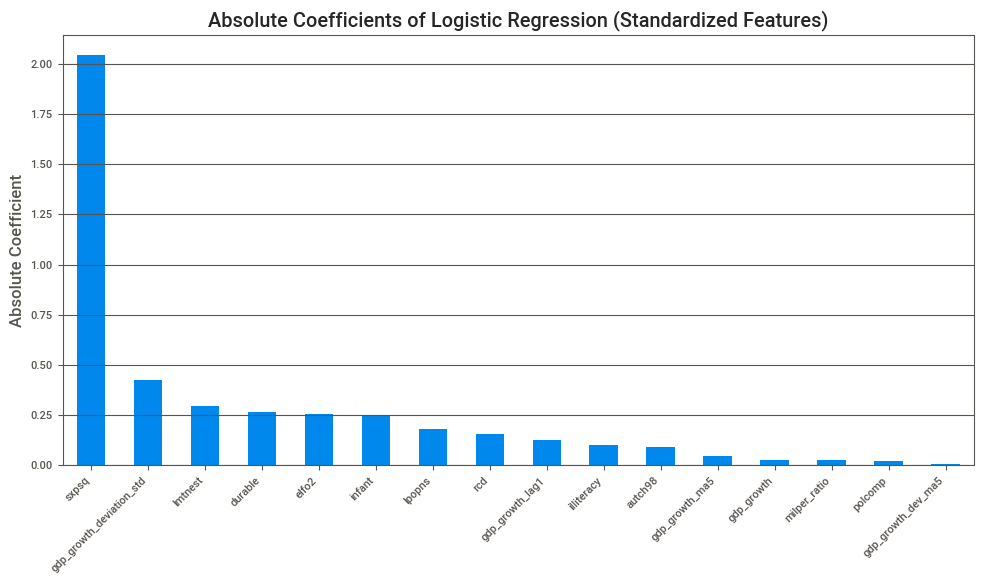

In [269]:
all_poss_features = ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                     'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns', 'rcd',
                     'gdp_growth_lag1', 'gdp_growth_ma5', 'gdp_growth_dev_ma5', 'gdp_growth_deviation_std']


target_col = 'warstds'


# Prepare X and y
X = df[all_poss_features]
y = df[target_col]

# Standardize features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=all_poss_features)

# Fit logistic regression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_scaled, y)

# Extract and sort absolute coefficients
coefficients = pd.Series(abs(clf.coef_[0]), index=all_poss_features).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
coefficients.plot(kind='bar')
plt.title('Absolute Coefficients of Logistic Regression (Standardized Features)')
plt.ylabel('Absolute Coefficient')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

The feature importance plot above shows that several of our engineered features are playing a key role in model prediction, with some features like sxpsq, gdp_growth_deviation_std, and lpopns standing out as significant contributors. This is very promising, as it indicates that the engineered features we’ve added are adding real value to the model's ability to predict civil war onset. But, some engineered features are not adding much to the model at all and we can consider dropping them! (We will justify later)

In [270]:
rcd_features = ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns', 'rcd']

all_poss_features = ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                     'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns', 'rcd',
                     'gdp_growth_lag1','gdp_growth_ma5', 'gdp_growth_dev_ma5','gdp_growth_deviation_std']

target_col = 'warstds'
year_col = 'year'


train_idx = df[year_col] <= 1987
test_idx = df[year_col] > 1987
y = df[target_col].copy()
scaler = StandardScaler()


X_rcd = df[rcd_features]
Xr_train = pd.DataFrame(scaler.fit_transform(X_rcd[train_idx]), index=X_rcd[train_idx].index, columns=rcd_features)
Xr_test = pd.DataFrame(scaler.transform(X_rcd[test_idx]), index=X_rcd[test_idx].index, columns=rcd_features)


X_all = df[all_poss_features]
Xa_train = pd.DataFrame(scaler.fit_transform(X_all[train_idx]), index=X_all[train_idx].index, columns=all_poss_features)
Xa_test = pd.DataFrame(scaler.transform(X_all[test_idx]), index=X_all[test_idx].index, columns=all_poss_features)


yr_train = y[train_idx]
yr_test = y[test_idx]
ya_train = y[train_idx]
ya_test = y[test_idx]

clf_rcd = LogisticRegression(max_iter=1000).fit(Xr_train, yr_train)
clf_all = LogisticRegression(max_iter=1000).fit(Xa_train, ya_train)

# ---------------------
# Evaluate with ROC-AUC
# ---------------------
rcd_auc = roc_auc_score(yr_test, clf_rcd.predict_proba(Xr_test)[:, 1])
all_auc = roc_auc_score(ya_test, clf_all.predict_proba(Xa_test)[:, 1])

# ---------------------
# Print Results
# ---------------------
print("ROC-AUC Scores (Test Set: Post-1987):")
print(f"RCD  Model (13 features)     : {rcd_auc:.4f}")
print(f"FULL Model (all features)    : {all_auc:.4f}")

ROC-AUC Scores (Test Set: Post-1987):
RCD  Model (13 features)     : 0.8159
FULL Model (all features)    : 0.8166


Although adding all GDP-related engineered features might be expected to enhance model performance, the ROC-AUC score of the full model (0.8074) was slightly lower than that of the RCD model (0.8077). This minor decline suggests that the inclusion of all engineered GDP features may have introduced **redundancy due to high collinearity** among these variables.

This result reinforces our earlier hypothesis: while these features capture related economic signals, their overlap may dilute model effectiveness when used together without filtering.

We will address this in the following section by:

* Identifying and removing highly collinear features (using VIF analysis),
* Retaining only the most **predictive and non-redundant** features.

*Note: The test above compared the performance of the full feature set (all engineered variables + `rcd`) against the streamlined RCD model (selected core features + `rcd`).*




### VIF Score Thresholds (as a reference point!)

| **VIF Score Range** | **Interpretation**                                                                                                         |
| ------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| **VIF < 5**         | **Acceptable**: Features are not highly collinear and should not cause multicollinearity issues.                           |
| **5 ≤ VIF < 10**    | **Moderate Multicollinearity**: Features show some degree of correlation but may still be usable. Monitor these closely.   |
| **VIF ≥ 10**        | **High Multicollinearity**: Features are highly correlated with others. It’s advisable to remove or combine such features. |

We will be using VIF scores again to assess multicollinearity (like we did earlier)!


@vienna i think the calculate vif function cannot deal with values close to 0 not too sure why cld u help troubleshoot pls thx! ( i tried for abit and could not get the logic of the function well enuf!)

In [271]:
# Function to calculate VIF
# Step 0: Subset to relevant features and drop NA
subset_df = df[all_poss_features].copy()

# Step 0.5: Check for and remove zero variance columns
zero_var_cols = [col for col in subset_df.columns if subset_df[col].var() <= 1e-10]
if zero_var_cols:
    print(f"Removing zero/near-zero variance features: {zero_var_cols}")
    subset_df = subset_df.drop(columns=zero_var_cols)

# Step 1: Remove perfectly correlated features (correlation = 1.0)
corr_matrix = subset_df.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
perfectly_correlated = [col for col in upper_triangle.columns if any(upper_triangle[col] >= 0.99)]

if perfectly_correlated:
    print(f"Removing perfectly correlated features: {perfectly_correlated}")
    subset_df = subset_df.drop(columns=perfectly_correlated)

# Step 2: Calculate VIF using existing function - with error handling
try:
    vif_data = calculate_vif(subset_df)
    print("VIF Scores for All Features (after dropping perfect correlations):")
    print(vif_data)
except FloatingPointError as e:
    print(f"Error in VIF calculation: {e}")
    print("Trying with more aggressive correlation filtering...")
    
    # Try with more aggressive correlation threshold
    corr_matrix = subset_df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find columns with any correlation >= 0.95
    highly_correlated = [col for col in upper_triangle.columns if any(upper_triangle[col] >= 0.95)]
    
    if highly_correlated:
        print(f"Removing highly correlated features (>=0.95): {highly_correlated}")
        subset_df = subset_df.drop(columns=highly_correlated)
        
        # Try VIF calculation again
        try:
            vif_data = calculate_vif(subset_df)
            print("VIF Scores for All Features (after dropping highly correlated features):")
            print(vif_data)
        except Exception as e2:
            print(f"Still encountering errors: {e2}")
            print("Consider using a different approach for multicollinearity detection.")
except Exception as e:
    print(f"Unexpected error in VIF calculation: {e}")
    print("Please check your data and ensure it's appropriate for VIF analysis.")

Error in VIF calculation: divide by zero encountered in scalar divide
Trying with more aggressive correlation filtering...
Removing highly correlated features (>=0.95): ['gdp_growth_deviation_std']
Still encountering errors: divide by zero encountered in scalar divide
Consider using a different approach for multicollinearity detection.


Due to the presence of potentially more than one highly correlated features, even with the removal of highly correlated features, we still encounter the divide by zero issue. This suggests that there might be more complex multicollinearity in my data that isn't caught by simple correlation analysis. 

Thus, to address multicollinearity we can create a correlation matrix to find out what is contributing to high VIF Scores to manually adjust it!

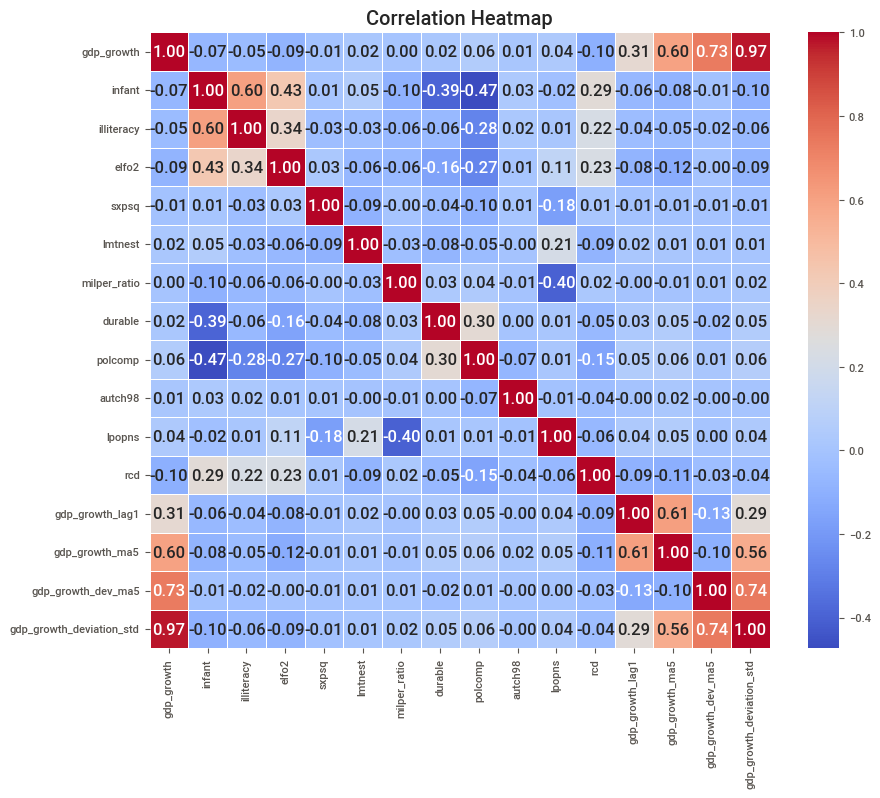

In [272]:
subset_df = df[all_poss_features]
corr_matrix = subset_df.corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

### Feature Dropping Justification: Correlation and Feature Importance

Based on the correlation heatmap and model results, we will be dropping the following features due to **multicollinearity** and **limited feature importance**:

* **`gdp_growth`**:
  The correlation between `gdp_growth` and `gdp_growth_deviation_std` is very high (**0.98**), indicating they are capturing nearly identical signals. Since `gdp_growth_deviation_std` provides a more nuanced view of volatility, we will retain it and drop `gdp_growth` to avoid redundancy.
  We will **retain `gdp_growth_lag1`**, as it captures temporal momentum and contributes unique value without introducing multicollinearity. Thus, meaningful growth rate information is still preserved in the dataset.

* **`gdp_growth_dev_ma5`**:
  This feature has a strong correlation with `gdp_growth` (**0.73**) and exhibited **very low feature importance** in our earlier model. Since it does not significantly improve model performance, we will drop it as a non-contributive feature.

* **`milper_ratio`, `polcomp`, `gdp_growth_ma5` **:
  These variables had a **negligible coefficient** (near zero) in the logistic regression model, suggesting they little to no predictive power for conflict outcomes. To streamline the feature set and avoid noise, we will exclude these variables!


In [273]:
subset_df_final = subset_df.drop(columns=['gdp_growth', 'gdp_growth_dev_ma5', 'milper_ratio', 'gdp_growth_ma5', 'polcomp' ])

In [274]:
vif_results = calculate_vif(subset_df_final)
print("VIF Scores")
print(vif_results)

VIF Scores
                     feature       VIF
0                     infant  2.212233
1                 illiteracy  1.706035
2                      elfo2  1.306999
3                    durable  1.265298
4                        rcd  1.136866
5                     lpopns  1.113325
6            gdp_growth_lag1  1.101135
7   gdp_growth_deviation_std  1.100620
8                    lmtnest  1.084983
9                      sxpsq  1.041403
10                   autch98  1.003896


Multicollinearity has all been restricted within threshold values!

#### **Final Features**

* infant
* illiteracy
* lpopns
* elfo2
* durable
* rcd
* lmtnest
* sxpsq
* gdp\_growth\_lag1
* gdp\_growth\_deviation\_std
* autch98


In [275]:
# Define feature sets and columns
rcd_features = ['gdp_growth', 'infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest',
                'milper_ratio', 'durable', 'polcomp', 'autch98', 'lpopns', 'rcd']

final_features = ['infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest', 
                  'durable', 'autch98', 'lpopns', 'rcd', 
                  'gdp_growth_lag1', 'gdp_growth_deviation_std']

target_col = 'warstds'
year_col = 'year'


train_idx = df[year_col] <= 1987
test_idx = df[year_col] > 1987
y = df[target_col].copy()
scaler = StandardScaler()

# RCD Model Data (selected features + RCD)
X_rcd = df[rcd_features].dropna()
Xr_train = pd.DataFrame(scaler.fit_transform(X_rcd[train_idx]), index=X_rcd[train_idx].index, columns=rcd_features)
Xr_test = pd.DataFrame(scaler.transform(X_rcd[test_idx]), index=X_rcd[test_idx].index, columns=rcd_features)

# Final Model Data
X_final = df[final_features].dropna()
Xf_train = pd.DataFrame(scaler.fit_transform(X_final[train_idx]), index=X_final[train_idx].index, columns=final_features)
Xf_test = pd.DataFrame(scaler.transform(X_final[test_idx]), index=X_final[test_idx].index, columns=final_features)

# Align targets with cleaned features
yr_train = y.loc[Xr_train.index]
yr_test = y.loc[Xr_test.index]
yf_train = y.loc[Xf_train.index]
yf_test = y.loc[Xf_test.index]


clf_rcd = LogisticRegression(max_iter=1000).fit(Xr_train, yr_train)
clf_final = LogisticRegression(max_iter=1000).fit(Xf_train, yf_train)

rcd_auc = roc_auc_score(yr_test, clf_rcd.predict_proba(Xr_test)[:, 1])
final_auc = roc_auc_score(yf_test, clf_final.predict_proba(Xf_test)[:, 1])

print("ROC-AUC Scores (Test Set: Post-1987):")
print(f"RCD   Model (original features) : {rcd_auc:.4f}")
print(f"FINAL Model (reduced features)  : {final_auc:.4f}")

ROC-AUC Scores (Test Set: Post-1987):
RCD   Model (original features) : 0.8159
FINAL Model (reduced features)  : 0.8252


The results above provide strong evidence that **GDP feature engineering added meaningful value to the model**, but only after accounting for **multicollinearity**. While the original RCD model achieved an ROC-AUC of **0.8159**, the refined model using **final selected features** achieved a higher ROC-AUC of **0.8252**.

This improvement demonstrates that engineered GDP-related variables **do capture useful predictive information**, but their contribution is only realised when we account for correlation!

#### **Conclusion for Feature Engineering**

Overall, we attempted feature engineering through:

1. **Growth rates**: `gdp_growth`, `gdp_growth_deviation_std`  
2. **Lagged and moving average GDP growth**: `gdp_growth_lag1`, `gdp_growth_ma5`, `gdp_growth_dev_ma5`  
3. **Non-linear squared terms**: `elfo2`, `infant2`  
4. **Region-based features**: `regional_conflict_density`  

We conducted **feature selection** by analysing VIF scores and multicollinearity matrices to reduce redundancy and improve model interpretability.

We then tested the models based on:

- **AIC scores** — to evaluate model fit while penalizing for complexity  
- **ROC-AUC scores** — to measure predictive accuracy and classification performance

## **2 Unsupervised learning**  
### **2.1 Preprocessing Pipeline**

In [135]:
# pca, standardisation etc

# Duplicate dataframe
unsupervised_df = df.copy()

# Decade-based dataframes
decade1_df = unsupervised_df[unsupervised_df['decade1'] == 1].copy()
decade2_df = unsupervised_df[unsupervised_df['decade2'] == 1].copy()
decade3_df = unsupervised_df[unsupervised_df['decade3'] == 1].copy()
decade4_df = unsupervised_df[unsupervised_df['decade4'] == 1].copy()

# Geography-based dataframes
geo1_df = unsupervised_df[unsupervised_df['geo1'] == 1].copy()
geo2_df = unsupervised_df[unsupervised_df['geo2'] == 1].copy()
geo34_df = unsupervised_df[unsupervised_df['geo34'] == 1].copy()
geo57_df = unsupervised_df[unsupervised_df['geo57'] == 1].copy()
geo69_df = unsupervised_df[unsupervised_df['geo69'] == 1].copy()
geo8_df = unsupervised_df[unsupervised_df['geo8'] == 1].copy()


### **2.2 Clustering**

#### Clustering By Decades


==== Decade 1 ====
Explained Variance Ratio: [0.19315416 0.07493485 0.04594873 0.04410815 0.04256743]
Cumulative Variance: [0.19315416 0.268089   0.31403773 0.35814588 0.40071331]
Top Loadings:
                PC1       PC2       PC3
cowcode  -0.072416 -0.032234 -0.015769
year      0.019554 -0.077136  0.296886
warstds  -0.017022 -0.019178 -0.002891
ager      0.046013  0.061338  0.022443
agexp    -0.064398 -0.033152 -0.107092
anoc     -0.033631 -0.020875  0.009598
army85    0.017833  0.039588 -0.033197
autch98  -0.013263  0.024321 -0.070168
auto4    -0.182145  0.160416  0.038928
autonomy -0.007844 -0.010076  0.029568

==== Decade 2 ====
Explained Variance Ratio: [0.19306123 0.07492277 0.04684444 0.04396103 0.0426144 ]
Cumulative Variance: [0.19306123 0.26798399 0.31482843 0.35878946 0.40140386]
Top Loadings:
                PC1       PC2       PC3
cowcode  -0.072428 -0.032231 -0.002682
year      0.019739 -0.077203  0.306333
warstds  -0.017030 -0.019158 -0.007554
ager      0.046063  0.0

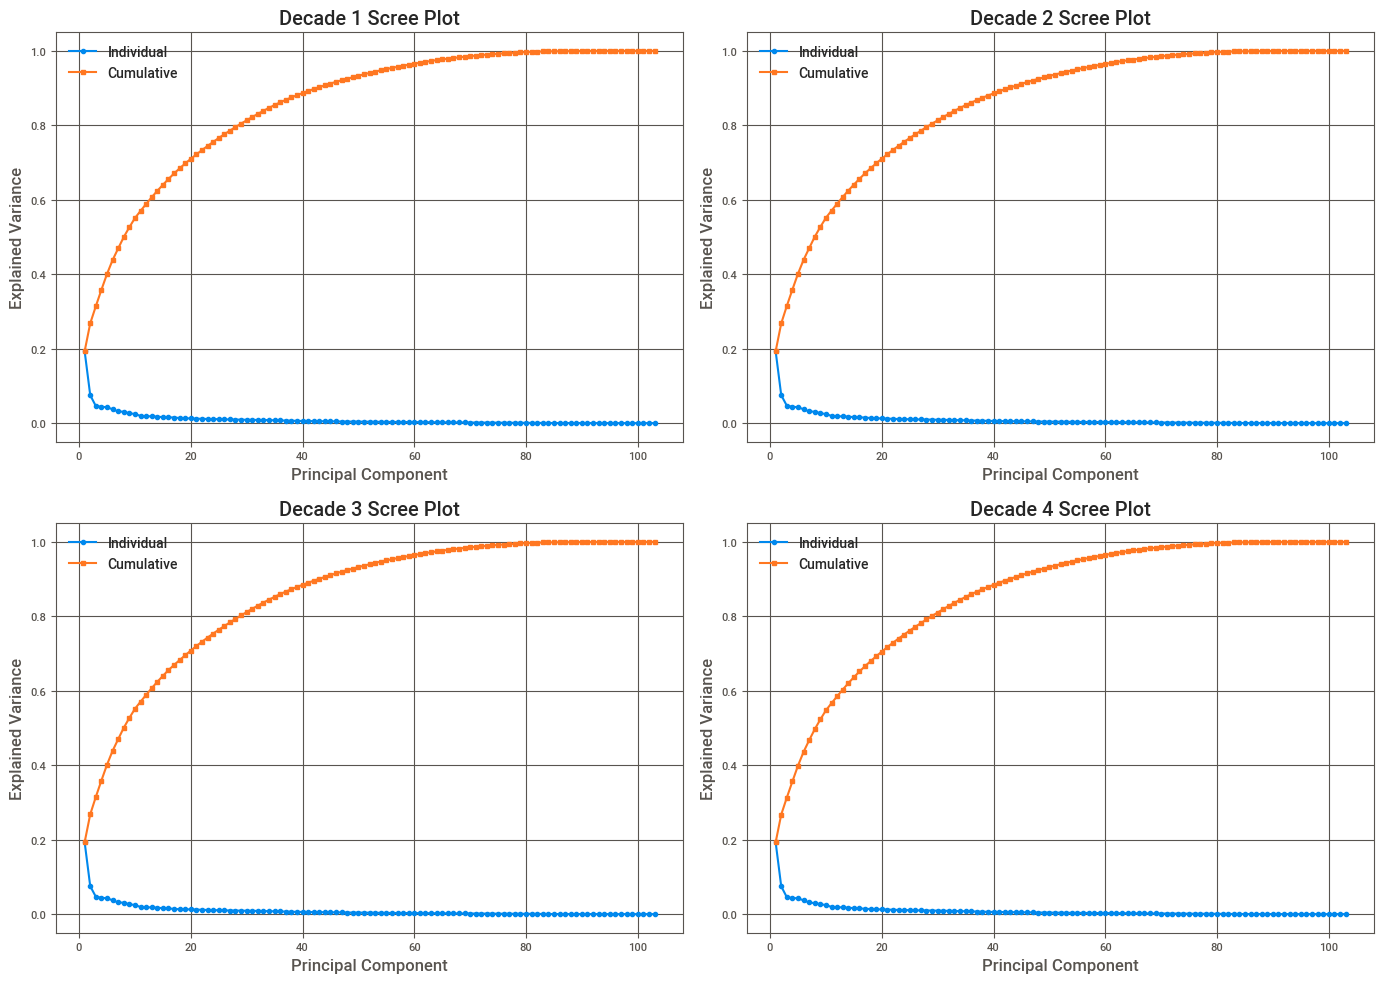

In [136]:
# Dictionary of your decade DataFrames
decade_dfs = {
    "Decade 1": decade1_df,
    "Decade 2": decade2_df,
    "Decade 3": decade3_df,
    "Decade 4": decade4_df
}

# Set up 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each decade and apply PCA
for idx, (label, df) in enumerate(decade_dfs.items()):
    # Select numeric features and drop binary indicator column
    features = unsupervised_df.select_dtypes(include='number').drop(columns=[f'decade{idx+1}'], errors='ignore')

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # Fit PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()

    # Scree plot in the subplot
    ax = axes[idx]
    ax.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual')
    ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', label='Cumulative')
    ax.set_title(f'{label} Scree Plot')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.legend()
    ax.grid(True)

    # Print PCA summary for each decade
    print(f"\n==== {label} ====")
    print("Explained Variance Ratio:", explained_variance_ratio[:5])
    print("Cumulative Variance:", cumulative_variance[:5])
    print("Top Loadings:\n", pd.DataFrame(
        pca.components_.T,
        index=features.columns,
        columns=[f'PC{i+1}' for i in range(len(features.columns))]
    ).iloc[:, :3].head(10))  # Show top 3 PCs and top 10 variables

# Adjust layout
plt.tight_layout()
plt.show()

As seen above, the PCA performance drops significantly usually after 2 components. However, because the cumulative explained variance of 2 PCA is still only slightly above 20%, we will keep 4 PCA components for the clustering analysis, as that is when the explained variance starts to plateau even more.


**Using Elbow Method to determine optimal number of clusters**


=== Decade 1 ===


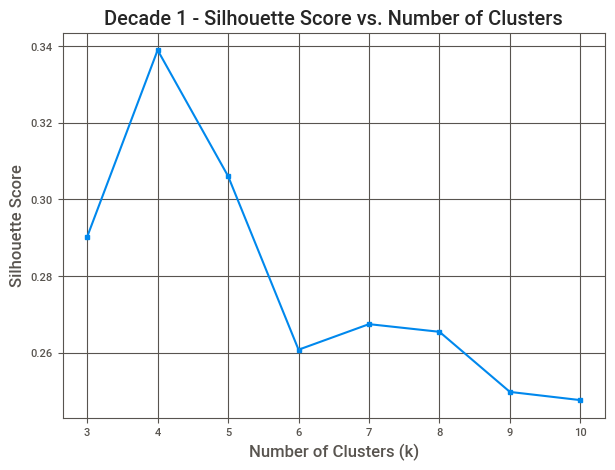

Best number of clusters (k): 4
Silhouette score for k=4: 0.3389

=== Decade 2 ===


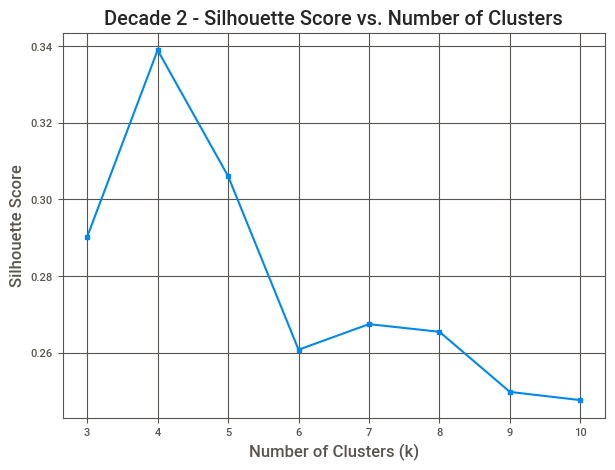

Best number of clusters (k): 4
Silhouette score for k=4: 0.3389

=== Decade 3 ===


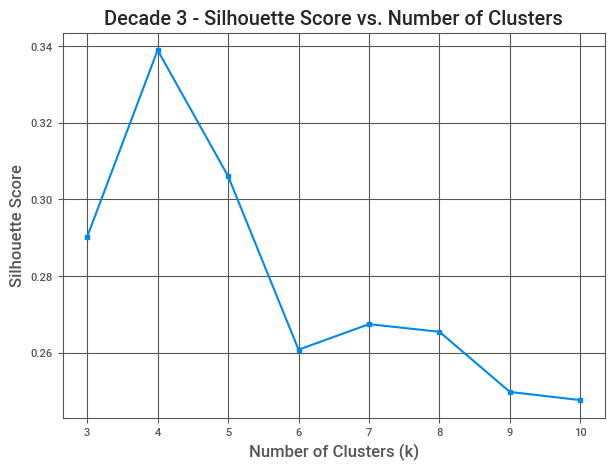

Best number of clusters (k): 4
Silhouette score for k=4: 0.3389

=== Decade 4 ===


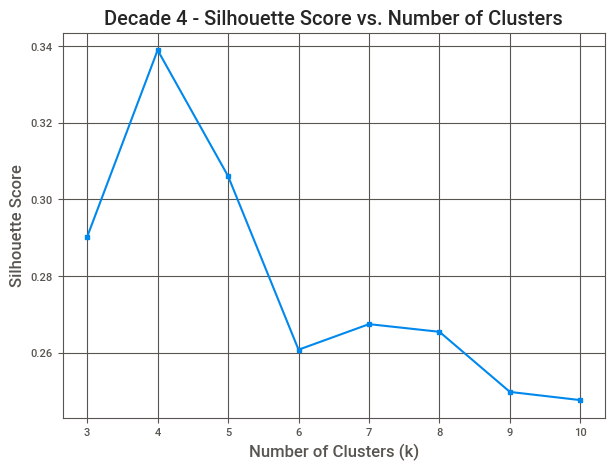

Best number of clusters (k): 4
Silhouette score for k=4: 0.3389


In [137]:
# Loop through each decade DataFrame
for idx, (label, df) in enumerate(decade_dfs.items()):
    print(f"\n=== {label} ===")

    # PCA - Reduce to 4 components
    pca = PCA(n_components=4)
    X_pca = pca.fit_transform(X_scaled)

    # Silhouette score sensitivity analysis over k=3 to 10 
    '''
    We exclude k=2 becuase the sensitivity will be clearly biased towards the 2 clusters as seen via the plot above. However, this
    is unlikely to yield us meaningful results and therefore we start from k=3.
    '''
    k_range = range(3, 11)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    # Plot silhouette scores
    plt.figure(figsize=(7, 5))
    plt.plot(k_range, silhouette_scores, marker='s')
    plt.title(f'{label} - Silhouette Score vs. Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Print best k and its score
    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    best_score = max(silhouette_scores)
    print(f"Best number of clusters (k): {best_k}")
    print(f"Silhouette score for k={best_k}: {best_score:.4f}")

**Cluster Analysis Using K-Means**

In [138]:
# Define your decade DataFrames and desired number of clusters
decade_kmeans_dfs = {
    "Decade 1": (decade1_df, 5),
    "Decade 2": (decade2_df, 4),
    "Decade 3": (decade3_df, 6),
    "Decade 4": (decade4_df, 7)
}

# Loop through each decade
for idx, (label, (df, k)) in enumerate(decade_kmeans_dfs.items()):
    print(f"\n=== {label} | Clusters: {k} ===")

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)

    # Create DataFrame for Plotly
    pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_df['Cluster'] = labels.astype(str)  # convert to string for better coloring
    pca_df['Decade'] = label

    # Plotly scatter plot
    fig = px.scatter(
        pca_df, x='PC1', y='PC2',
        color='Cluster',
        symbol='Cluster',
        hover_data=['Country'] if 'Country' in pca_df.columns else None,
        title=f'{label} - KMeans Clustering ({k} Clusters)',
        labels={'Cluster': 'Cluster ID'},
        width=700, height=500
    )
    fig.show()


=== Decade 1 | Clusters: 5 ===



=== Decade 2 | Clusters: 4 ===



=== Decade 3 | Clusters: 6 ===



=== Decade 4 | Clusters: 7 ===


**Analysis of cluster variables** 

In [147]:
def get_pca_loadings(unsupervised_df, drop_col=None, n_components=4):
    features = unsupervised_df.select_dtypes(include='number').drop(columns=[drop_col], errors='ignore')
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    pca = PCA(n_components=n_components)
    pca.fit(X_scaled)
    return pd.DataFrame(
        pca.components_.T,
        index=features.columns,
        columns=[f'PC{i+1}' for i in range(n_components)]
    )

# Loadings for each decade
loadings_d1 = get_pca_loadings(decade1_df, drop_col='decade1')
loadings_d2 = get_pca_loadings(decade2_df, drop_col='decade2')
loadings_d3 = get_pca_loadings(decade3_df, drop_col='decade3')
loadings_d4 = get_pca_loadings(decade4_df, drop_col='decade4')

# Combine all loadings
combined = pd.concat([
    loadings_d1.add_suffix('_D1'),
    loadings_d2.add_suffix('_D2'),
    loadings_d3.add_suffix('_D3'),
    loadings_d4.add_suffix('_D4')
], axis=1)

# Print or inspect combined loadings
print("\n=== Combined PCA Loadings ===")
print(combined.round(3))

# Identify top 3 features per PC for each decade
top_features_by_pc = {}
for name, loadings in zip(['D1', 'D2', 'D3', 'D4'], [loadings_d1, loadings_d2, loadings_d3, loadings_d4]):
    top_features_by_pc[name] = {
        pc: loadings[pc].abs().sort_values(ascending=False).head(3)
        for pc in loadings.columns
    }

# Print top variables by PC
for decade, pcs in top_features_by_pc.items():
    print(f"\nTop PCA Loadings for {decade}:")
    for pc, vals in pcs.items():
        print(f"  {pc}: {', '.join(vals.index)}")


=== Combined PCA Loadings ===
                    PC1_D1  PC2_D1  PC3_D1  PC4_D1  PC1_D2  PC2_D2  PC3_D2  \
cowcode             -0.072   0.039  -0.112  -0.138  -0.072   0.039   0.098   
year                -0.018   0.014  -0.062  -0.013  -0.001   0.001  -0.063   
warstds             -0.017   0.021  -0.081   0.006  -0.016   0.014   0.036   
ager                 0.053  -0.102   0.039  -0.156   0.065  -0.051   0.053   
agexp               -0.051   0.032  -0.079  -0.036  -0.065   0.035   0.119   
...                    ...     ...     ...     ...     ...     ...     ...   
gdp_growth_dev_ma5   0.013  -0.023   0.075  -0.054   0.001  -0.033   0.004   
infant2             -0.113   0.046  -0.082   0.051  -0.151   0.060   0.076   
region              -0.127   0.181   0.084   0.003  -0.121   0.181  -0.029   
rcd                 -0.045   0.055  -0.031   0.004  -0.047   0.068  -0.053   
decade1                NaN     NaN     NaN     NaN  -0.000  -0.000   0.000   

                    PC4_D2  PC1_

In [140]:
# Plotly heatmap of all loadings
fig = go.Figure(data=go.Heatmap(
    z=combined.values,
    x=combined.columns,
    y=combined.index,
    colorscale='RdBu',
    zmid=0,
    colorbar=dict(title='Loading'),
))
fig.update_layout(title='PCA Loadings Across Decades (PC1–PC4)', height=700, width=1000)
fig.show()

🕰️ Decade 1 

- Dominated by core political indicators: `dem4`, `pol4`, and `pol4m`, which measure democracy levels and regime authority.

- Ethnic diversity variables (`ehet`, `ef2`, `plural`) are highly influential, highlighting how ethno-political fragmentation shaped state development and conflict risk in the post-colonial context.

- Economic openness is represented by `expgdp` and trade, indicating the structural importance of external trade.

- Regional dummy `geo69` appears, suggesting that geography (especially Latin America) may have defined variation in governance types.

🧠 Takeaway: The post-war world was structured primarily by democratic status, ethnic composition, and economic trade exposure, with region acting as a contextual layer.

🕰️ Decade 2

- Continued centrality of polity indicators: `dem4`, `parcomp`, `polcomp` signals deepening focus on institutional structures.

- Ethnic dominance variables: `elfo`, `elfo2` are remain important, showing persistent attention to ethnic power imbalances.

- Economic dependency and size (`expgdp`, `lpopns`) are again influential, alongside the introduction of primary export reliance (`sxpnew`), marking the global rise of commodity-focused development strategies.

- Emergence of `parreg` and `pol4sq` suggests growing complexity in how regimes are regulated and institutionalised.

🧠 Takeaway: A shift from simple democratic measures toward institutional nuance and economic dependency begins to emerge.

🕰️ Decade 3 

- Institutional differentiation intensifies: `parcomp`, `polcomp`, and `dem4` dominate again, reflecting the increasing importance of political competition and institutional mechanics.

- Ethnic variables persist (`elfo`, `plural`), but begin to blend with regime regulation (`parreg`) and state capacity.

- A new theme arises: military capacity enters via `milper` and `army85`, reflecting concerns about the role of the armed forces in governance.

🧠 Takeaway: As countries stabilised politically, institutional robustness and military presence became more relevant markers of regime structure.

🕰️ Decade 4 

- Political indicators (`dem4`, `pol4`, `pol4m`) persist, showing enduring relevance of regime type.

- Ethnic dominance (`elfo`, `elfo2`) now merges with `auto4`, suggesting attention has shifted to autocracy vs. pluralism.

- A key shift: religious composition (`plurrel`, `relfrac`) and regime durability (`durable`) rise in influence, indicating that long-term legitimacy and cultural cohesion had become central concerns.

- Military and population variables again appear (`milper`, `army85`, `lpopns`), highlighting state strength.

🧠 Takeaway: Political regimes remained important, but new weight was given to cultural identity, institutional endurance, and militarisation.



| **Theme**                | **D1** | **D2** | **D3** | **D4** | **Trend**                             |
| ------------------------ | ------ | ------ | ------ | ------ | ------------------------------------- |
| Democracy & Regime Type  | ✅      | ✅      | ✅      | ✅      | Persistent core axis                  |
| Ethnic Composition       | ✅      | ✅      | ✅      | ✅      | Consistent but gradually more complex |
| Economic Dependency      | ✅      | ✅      | ✅      | ❌      | Declines in prominence                |
| Military Power           | ❌      | ❌      | ✅      | ✅      | Increasing from D3 onward             |
| Religious Identity       | ❌      | ❌      | ❌      | ✅      | Emerges only in later decades         |
| Institutional Durability | ❌      | ✅      | ✅      | ✅      | Grows over time                       |


#### Clustering By Regions


==== Western Europe and the US ====
Explained Variance Ratio: [0.17320271 0.10382148 0.09170959 0.07283251 0.04472301]
Cumulative Variance: [0.17320271 0.27702419 0.36873377 0.44156628 0.48628929]
Top Loadings:
                PC1       PC2       PC3
cowcode  -0.042736  0.100162 -0.228397
year      0.119985  0.220612  0.089107
warstds   0.002820 -0.000673  0.006153
ager      0.117221  0.016616  0.067681
agexp    -0.067729 -0.116794 -0.096738
anoc     -0.081455  0.011009 -0.004360
army85    0.028131  0.042493  0.146080
autch98  -0.035875  0.016891  0.016084
auto4    -0.219494  0.059343  0.091024
autonomy -0.042978 -0.012191  0.010217

==== Eastern Europe and Central Asia ====
Explained Variance Ratio: [0.19338284 0.1063801  0.08570401 0.05958599 0.04971083]
Cumulative Variance: [0.19338284 0.29976294 0.38546696 0.44505295 0.49476378]
Top Loadings:
                PC1       PC2       PC3
cowcode   0.034048  0.128663  0.033166
year      0.153649 -0.042680  0.108727
warstds   0.016492  0.

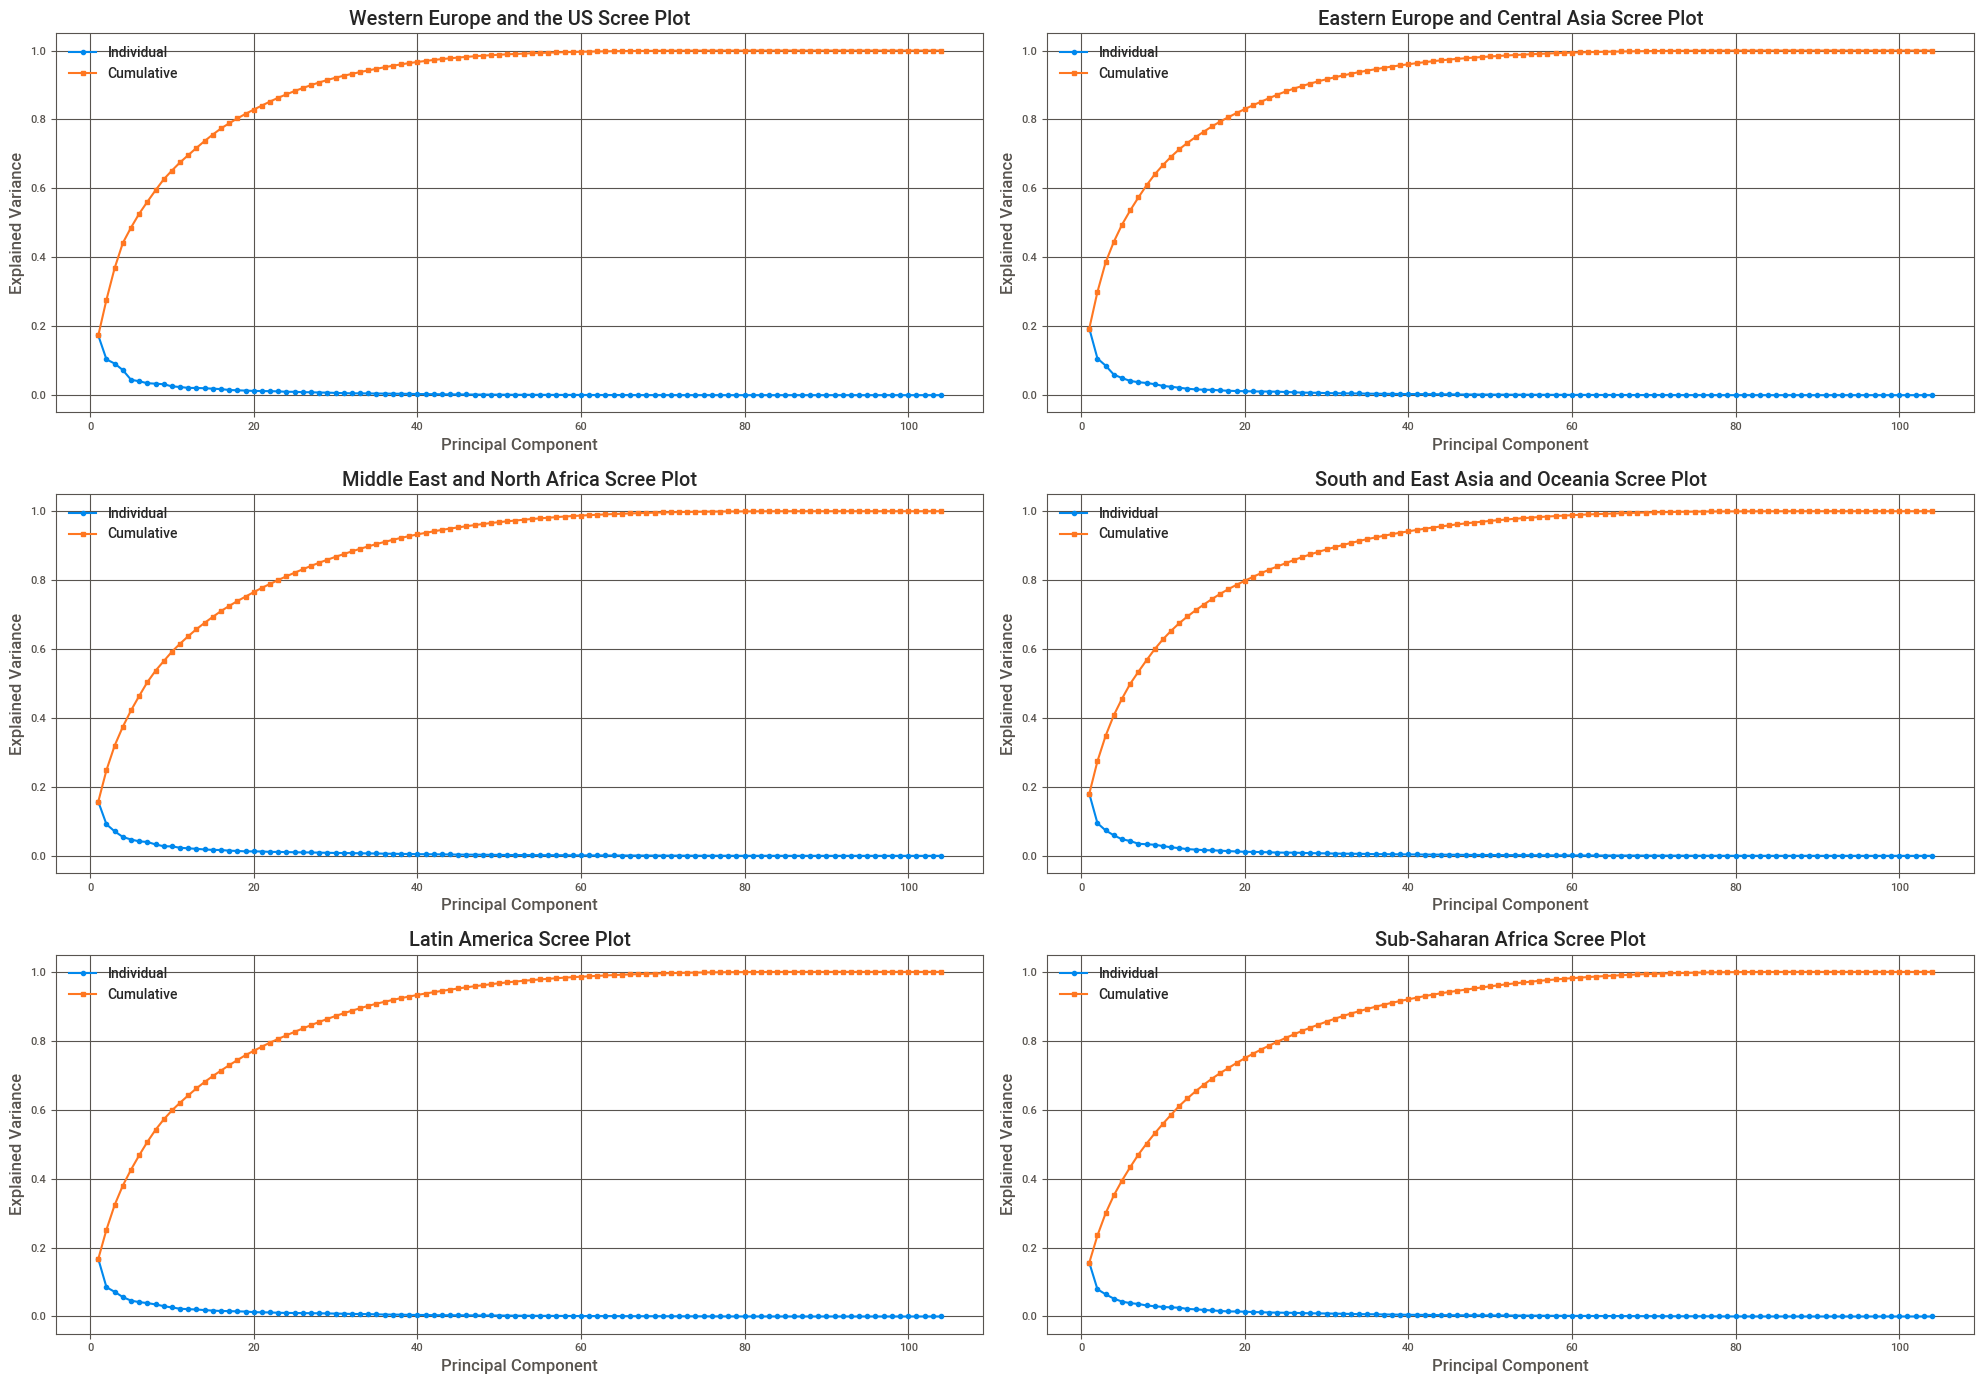

In [141]:
# Dictionary of region DataFrames with descriptive labels
region_dfs = {
    "Western Europe and the US": geo1_df,
    "Eastern Europe and Central Asia": geo2_df,
    "Middle East and North Africa": geo34_df,
    "South and East Asia and Oceania": geo57_df,
    "Latin America": geo69_df,
    "Sub-Saharan Africa": geo8_df
}

# Set up a 3x2 subplot grid to accommodate 5 regions
fig, axes = plt.subplots(3, 2, figsize=(20, 14))
axes = axes.flatten()

# Loop through each region and apply PCA
for idx, (label, df) in enumerate(region_dfs.items()):
    # Find the geo indicator column (e.g. geo1, geo2...) to drop
    geo_col = [col for col in df.columns if col.startswith('geo') and df[col].nunique() == 2 and df[col].max() == 1]
    geo_col = geo_col[0] if geo_col else None

    # Select numeric features, excluding geo dummy
    features = df.select_dtypes(include='number')
    if geo_col:
        features = features.drop(columns=geo_col, errors='ignore')


    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # PCA
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)

    # Explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = explained_variance_ratio.cumsum()

    # Plot scree plot in the correct subplot
    ax = axes[idx]
    ax.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual')
    ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='s', label='Cumulative')
    ax.set_title(f'{label} Scree Plot')
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Explained Variance')
    ax.legend()
    ax.grid(True)

    # Print summary
    print(f"\n==== {label} ====")
    print("Explained Variance Ratio:", explained_variance_ratio[:5])
    print("Cumulative Variance:", cumulative_variance[:5])
    print("Top Loadings:\n", pd.DataFrame(
        pca.components_.T,
        index=features.columns,
        columns=[f'PC{i+1}' for i in range(pca.n_components_)]
    ).iloc[:, :3].head(10))

plt.tight_layout()
plt.show()



=== Western Europe and the US ===


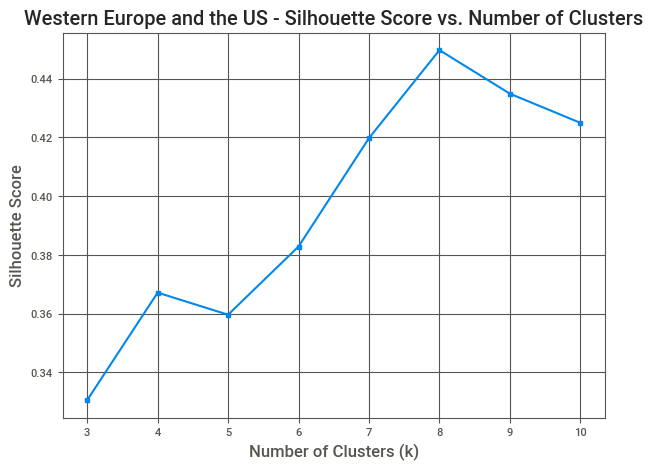

Best number of clusters (k): 8
Silhouette score for k=8: 0.4497

=== Eastern Europe and Central Asia ===


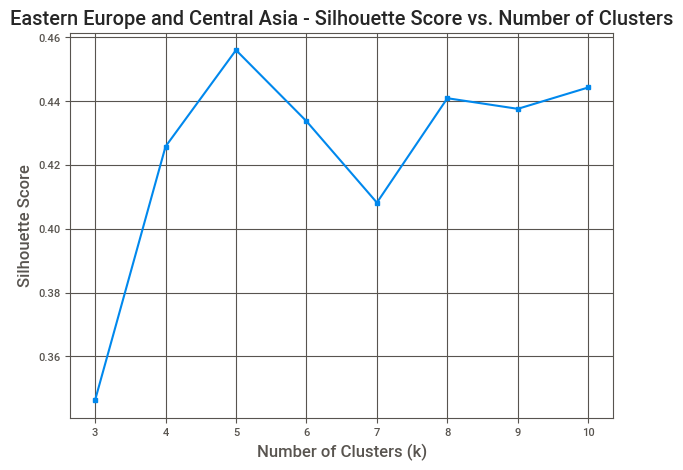

Best number of clusters (k): 5
Silhouette score for k=5: 0.4559

=== Middle East and North Africa ===


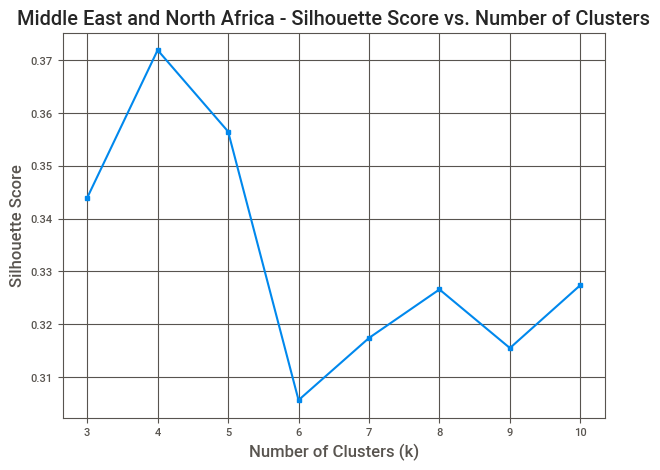

Best number of clusters (k): 4
Silhouette score for k=4: 0.3719

=== South and East Asia and Oceania ===


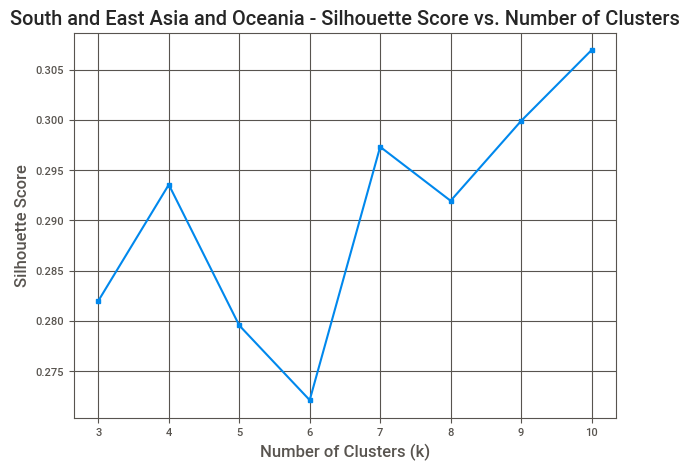

Best number of clusters (k): 10
Silhouette score for k=10: 0.3069

=== Latin America ===


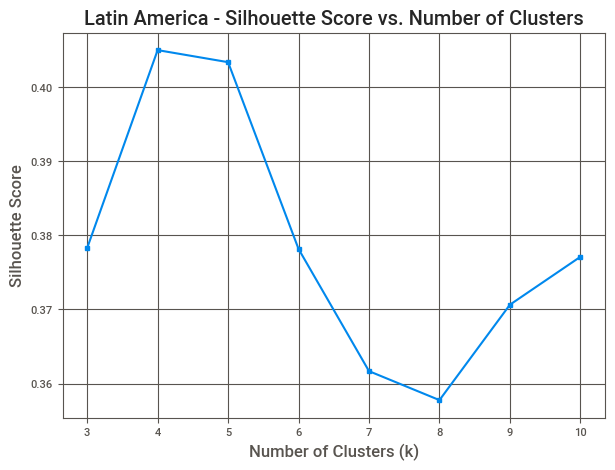

Best number of clusters (k): 4
Silhouette score for k=4: 0.4050

=== Sub-Saharan Africa ===


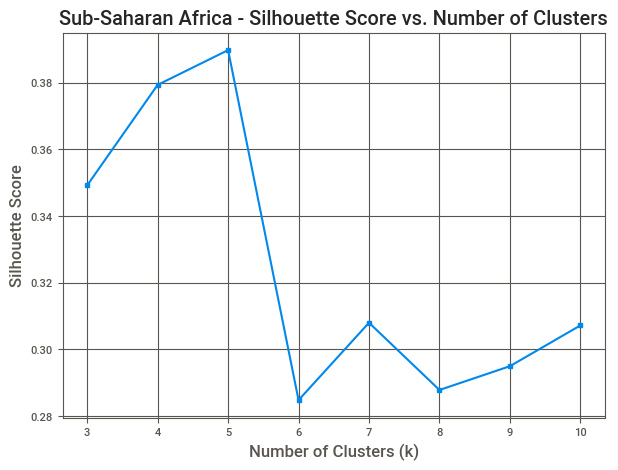

Best number of clusters (k): 5
Silhouette score for k=5: 0.3898


In [142]:
# Corresponding number of PCs (in same order)
region_pca_dims = [4, 3, 3, 5, 3, 3]

# Loop through each region with its corresponding number of PCs
for (label, unsupervised_df), n_pcs in zip(region_dfs.items(), region_pca_dims):
    print(f"\n=== {label} ===")

    # Find geo column and drop it
    geo_col = [col for col in unsupervised_df.columns if col.startswith('geo') and unsupervised_df[col].nunique() == 2 and unsupervised_df[col].max() == 1]
    geo_col = geo_col[0] if geo_col else None

    features = unsupervised_df.select_dtypes(include='number')
    if geo_col:
        features = features.drop(columns=geo_col, errors='ignore')

    if features.shape[0] < 10:
        print("Skipping due to too few observations.")
        continue

    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # PCA
    pca = PCA(n_components=n_pcs)
    X_pca = pca.fit_transform(X_scaled)

    # Silhouette score analysis for k = 3 to 10
    k_range = range(3, 11)
    silhouette_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

    # Plot
    plt.figure(figsize=(7, 5))
    plt.plot(k_range, silhouette_scores, marker='s')
    plt.title(f'{label} - Silhouette Score vs. Number of Clusters')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.grid(True)
    plt.show()

    # Print best k and score
    best_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    best_score = max(silhouette_scores)
    print(f"Best number of clusters (k): {best_k}")
    print(f"Silhouette score for k={best_k}: {best_score:.4f}")

In [143]:
region_kmeans_dfs = {
    "Western Europe and the US": (geo1_df, 8),
    "Eastern Europe and Central Asia": (geo2_df, 4),
    "Middle East and North Africa": (geo34_df, 10),
    "South and East Asia and Oceania": (geo57_df, 10),
    "Latin America": (geo69_df, 9),
    "Sub-Saharan Africa": (geo8_df, 6)
}

for label, (region_data, k) in region_kmeans_dfs.items():
    print(f"\n=== {label} | Clusters: {k} ===")

    # Select numeric features (drop geo column if needed)
    geo_col = [col for col in region_data.columns if col.startswith('geo') and region_data[col].max() == 1]
    geo_col = geo_col[0] if geo_col else None
    features = region_data.select_dtypes(include='number').drop(columns=geo_col, errors='ignore')

    if features.empty:
        continue

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    # PCA
    pca = PCA(n_components=4)
    X_pca = pca.fit_transform(X_scaled)

    # KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_pca)

    # Prepare for Plotly
    pca_df = pd.DataFrame(X_pca[:, :2], columns=['PC1', 'PC2'])
    pca_df['Cluster'] = labels.astype(str)
    pca_df['Region'] = label
    if 'Country' in region_data.columns:
        pca_df['Country'] = region_data['Country'].values

    fig = px.scatter(
        pca_df, x='PC1', y='PC2',
        color='Cluster',
        symbol='Cluster',
        hover_data=['Country'] if 'Country' in pca_df.columns else None,
        title=f'{label} - KMeans Clustering ({k} Clusters)',
        labels={'Cluster': 'Cluster ID'},
        width=800, height=550
    )
    fig.show()


=== Western Europe and the US | Clusters: 8 ===



=== Eastern Europe and Central Asia | Clusters: 4 ===



=== Middle East and North Africa | Clusters: 10 ===



=== South and East Asia and Oceania | Clusters: 10 ===



=== Latin America | Clusters: 9 ===



=== Sub-Saharan Africa | Clusters: 6 ===


In [144]:
# Mapping region labels to dataframes, geo indicator column, and # of PCA components
region_info = {
    "Western Europe and the US": (geo1_df, 'geo1', 4),
    "Eastern Europe and Central Asia": (geo2_df, 'geo2', 3),
    "Middle East and North Africa": (geo34_df, 'geo34', 3),
    "South and East Asia and Oceania": (geo57_df, 'geo57', 5),
    "Latin America": (geo69_df, 'geo69', 3),
    "Sub-Saharan Africa": (geo8_df, 'geo8', 3)
}

# Get PCA loadings for each region
region_loadings = {
    region: get_pca_loadings(df, drop_col=geo_col, n_components=n_pcs)
    for region, (df, geo_col, n_pcs) in region_info.items()
}

# Combine into one DataFrame for comparison
combined_loadings = pd.concat([
    loadings.add_suffix(f'_{region.replace(" ", "")[:3]}')
    for region, loadings in region_loadings.items()
], axis=1)

# Print combined PCA loadings
print("\n=== Combined PCA Loadings by Region ===")
print(combined_loadings.round(3))

# Extract top 3 loadings per PC per region
top_features_by_pc = {
    region: {
        pc: load.abs().sort_values(ascending=False).head(3)
        for pc, load in loadings.items()
    }
    for region, loadings in region_loadings.items()
}

# Display top components clearly
for region, pcs in top_features_by_pc.items():
    print(f"\nTop PCA Loadings for {region}:")
    for pc, series in pcs.items():
        print(f"  {pc}: {', '.join(series.index)}")



=== Combined PCA Loadings by Region ===
                    PC1_Wes  PC2_Wes  PC3_Wes  PC4_Wes  PC1_Eas  PC2_Eas  \
cowcode              -0.043    0.100   -0.228    0.083    0.034    0.129   
year                  0.120    0.221    0.089    0.118    0.154   -0.043   
warstds               0.003   -0.001    0.006   -0.009    0.016    0.008   
ager                  0.117    0.017    0.068    0.052   -0.151   -0.083   
agexp                -0.068   -0.117   -0.097   -0.042   -0.014    0.177   
...                     ...      ...      ...      ...      ...      ...   
gdp_growth_dev_ma5   -0.006   -0.006   -0.005   -0.015    0.030    0.024   
infant2              -0.117   -0.209   -0.101   -0.107   -0.030    0.193   
region                0.000    0.000    0.000    0.000    0.000   -0.000   
rcd                   0.029    0.062    0.034    0.009   -0.090   -0.068   
geo1                    NaN      NaN      NaN      NaN    0.000   -0.000   

                    PC3_Eas  PC1_Mid  PC2_Mid 

In [145]:
# Plotly heatmap of all loadings
fig = go.Figure(data=go.Heatmap(
    z=combined_loadings.values,
    x=combined_loadings.columns,
    y=combined_loadings.index,
    colorscale='RdBu',
    zmid=0,
    colorbar=dict(title='Loading'),
))
fig.update_layout(title='PCA Loadings Across Decades', height=700, width=1000)
fig.show()


**🌍 Regional PCA Interpretation**

🌐 Western Europe and the US

- Strong emphasis on political institutions and participation: `polcomp`, `parcomp`, and `parreg` dominate PC1, showing this region’s variation is driven by the quality of democratic competition and regulation.

- PC2 is shaped by ethnic heterogeneity (`ehet`, `ef`, `elfo`), indicating that even in consolidated democracies, ethnic diversity is an important structural factor.

- PC3 and PC4 reflect economic activity (`sxpnew`, `manuexp`) and cultural-linguistic diversity (`numlang`, `plurrel`), suggesting broader structural complexity.

🧠 Takeaway: In Western Europe and the US, democracy is institutionally embedded, but ethnic and cultural diversity, and economic specialisation still explain significant variation.

🌐 Eastern Europe and Central Asia

- PC1 features core regime-type indicators: `dem4`, `pol4`, `pol4m`, reflecting significant variation in democratic versus authoritarian rule.

- PC2 introduces geographic and military structure (`ncontig`, `oil`, `army85`), pointing to the importance of resource dependency and military footprint in shaping governance.

- PC3 is driven by social resilience and demographic composition (`ager`, `durable`, `mirps2`).

🧠 Takeaway: Variation in this region is explained not just by regime type, but also by physical geography, militarisation, and post-Soviet institutional durability.

🌐 Middle East and North Africa

- Dominated by authoritarian regime strength (`pol4`, `pol4m`, `auto4`) and regime entrenchment (`pol4sq`, `durable`), underscoring the region’s institutional rigidity.

- PC2 includes state capacity indicators like population (`lpopns`) and literacy.

- PC3 revives ethnic and religious heterogeneity (`ehet`, `drel`, `agexp`), marking a cultural undercurrent in political structure.

🧠 Takeaway: The MENA region is characterised by entrenched authoritarianism, with political variation linked to both demographic capacity and ethno-religious fault lines.

🌐 South and East Asia and Oceania

- Core indicators (`dem4`, `pol4`, `sip2`) reaffirm political regime type as central, while PC2 reflects ethnic dominance structures (`elfo2`, `elfo`, `dlang`).

- Economic indicators (`trade`, `expgdp`, `sxpnew`) appear in PC3, pointing to the relevance of export orientation.

- PC4 and PC5 indicate deeper structural traits like religious composition (`relfrac`, `plurrel`) and industrial/agricultural balance (`manuexp`, `agexp`).

🧠 Takeaway: This is a structurally diverse region where governance varies along lines of regime type, ethnicity, trade orientation, and cultural identity.

🌐 Latin America

- PC1 focuses on hybrid or transitioning regimes (`pol4m`, `pol4`, `polcomp`), reinforcing the region’s fluctuation between democracy and authoritarianism.

- PC2 spotlights ethnic and linguistic diversity (`plural`, `ef2`, `elfo`), still influential despite formal democratic norms.

- PC3 includes population and conflict (`second`, `lpopns`, `nat_war`), showing vulnerability to instability and internal violence.

🧠 Takeaway: Political variation in Latin America is shaped by regime volatility, ethnic divisions, and a latent undercurrent of conflict risk.

🌐 Sub-Saharan Africa

- PC1 includes classic regime type measures (`pol4`, `dem4`, `pol4m`), reinforcing governance as a major axis of variation.

- PC2 features ethnic and fractional complexity (`ef`, `ef2`, `plural`), which consistently explains structural outcomes.

- PC3 reflects developmental capacity (`expgdp`, `seceduc`, `elfo`), suggesting that economic and educational disparity are key forces.

🧠 Takeaway: Governance and ethnic heterogeneity are still central in Sub-Saharan Africa, but developmental constraints and educational access increasingly shape regional differentiation.

📊 Summary Table: Regional Determinants of Variation
| **Theme**                    | **W. Europe & US** | **E. Europe & C. Asia** | **MENA** | **S/E Asia & Oceania** | **Latin America** | **Sub-Saharan Africa** | **Trend**                                                 |
|-----------------------------|--------------------|--------------------------|----------|------------------------|-------------------|-------------------------|----------------------------------------------------------|
| Regime Type (dem4, pol4…)   | ✅                 | ✅                       | ✅       | ✅                     | ✅                | ✅                      | Consistent core axis of differentiation                   |
| Ethnic Composition          | ✅                 | ⚠️ (indirect)            | ✅       | ✅                     | ✅                | ✅                      | Broadly influential across all regions                   |
| Economic Dependency         | ✅                 | ✅ (oil)                 | ⚠️       | ✅                     | ✅                | ✅                      | Structural in most, but less in MENA                     |
| Military / Geography        | ❌                 | ✅                       | ⚠️       | ❌                     | ⚠️                | ⚠️                      | Relevant mainly in post-Soviet or resource-rich states   |
| Religious/Cultural Identity| ✅                 | ❌                       | ✅       | ✅                     | ⚠️                | ⚠️                      | Grows more influential outside Europe                    |
| Education / Development     | ⚠️                 | ✅                       | ⚠️       | ✅                     | ✅                | ✅                      | Increasingly critical in SSA and Asia                    |


✅ = primary driver
⚠️ = moderate or indirect influence
❌ = minimal appearance in top PCs

### **2.3 Anomaly Detection**

While our primary goal is to predict civil war onset using theoretically grounded features, anomaly detection offers a complementary lens: it helps us uncover **country-years that are structurally unusual** based on the broader patterns in the data — regardless of whether they led to conflict.

These **anomalies** can represent:

- Countries that exhibited high risk but **did not experience civil war** (e.g., strong ethnic division + weak institutions)

- Cases where war did occur, but **under atypical structural conditions** (e.g., high democracy + high GDP)

- Structural outliers that may **challenge our model assumptions** or highlight **data/reporting inconsistencies**

By identifying such points, we can:

- Understand **where and why our predictive models might fail**

- Diagnose **edge cases** that theoretical models don't account for

- Explore **regions or regimes** that consistently deviate from global civil war patterns

#### 🌲 How Isolation Forest Detects Anomalies

To implement anomaly detection, we start by using the **Isolation Forest algorithm**, a tree-based method designed specifically for high-dimensional data like ours.

#### ✂️ Core Intuition:
Isolation Forest works by randomly selecting a feature and a split value to “isolate” observations. Observations that require **fewer splits to isolate** (i.e. they lie far from others in feature space) are considered **more anomalous**.

This approach allows us to move beyond binary prediction and ask:  
> *What kinds of country-years break the mould of civil war theory?*

Based on the previous analysis, we proceed with **4 PC's** (see 2.2)

In [149]:
# Dictionary of your decade DataFrames
decade_dfs = {
    "Decade 1": decade1_df,
    "Decade 2": decade2_df,
    "Decade 3": decade3_df,
    "Decade 4": decade4_df
}

# Prepare container for storing anomaly results
all_outliers = []

# Loop through each decade and apply PCA
for idx, (label, df_temp) in enumerate(decade_dfs.items()):
    # Drop the active decade dummy and non-features
    decade_col = f"decade{idx+1}"

    # Select numeric features and drop binary indicator column
    features = df_temp.select_dtypes(include='number').drop(
        columns=[decade_col], errors='ignore'
    )

    # Standardize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)

    pca = PCA(n_components=4)
    X_pca = pca.fit_transform(X_scaled)

    # Isolation Forest
    iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
    iso_forest.fit(X_pca)

    # Get predictions
    df_temp['anomaly_score'] = iso_forest.decision_function(X_pca)
    df_temp['is_outlier'] = iso_forest.predict(X_pca) # -1 = outlier
    df_temp['Decade'] = label
    
    # Store the relevant results
    results_df = df_temp[['cowcode','year','Decade','anomaly_score','is_outlier']]
    all_outliers.append(results_df)

# Combine results
outliers_combined = pd.concat(all_outliers)

What hyperparameters were chosen?

- **n_estimators**: this sets the number of trees in the ensemble; set to **`100`** as recommended for datasets like ours (**> 10'000 observations**)

- **contamination**: this estimates the proportion of expected anomalies in the data; set to **`0.03`** as we're looking for a few extreme cases

As we manually set **contamination** there is no need to set a custom threshold for detecting anomalous cases

Printing all outliers

In [150]:
# Filter to only show anomalies detected
outliers_only = outliers_combined[outliers_combined['is_outlier'] == -1]
outliers_only = outliers_only.sort_values(by='anomaly_score')

# Show top 20 anomalies
print("Top 20 Detected Anomalies Across All Decades")
print(outliers_only.head(20))

Top 20 Detected Anomalies Across All Decades
      cowcode  year    Decade  anomaly_score  is_outlier
6952      710  1969  Decade 1      -0.157026          -1
6949      710  1966  Decade 1      -0.155913          -1
6951      710  1968  Decade 1      -0.151863          -1
6950      710  1967  Decade 1      -0.149939          -1
7274      750  1969  Decade 1      -0.148642          -1
7273      750  1968  Decade 1      -0.144818          -1
6946      710  1963  Decade 1      -0.139288          -1
7271      750  1966  Decade 1      -0.138466          -1
7280      750  1975  Decade 2      -0.136979          -1
7282      750  1977  Decade 2      -0.135009          -1
7283      750  1978  Decade 2      -0.134535          -1
6945      710  1962  Decade 1      -0.134294          -1
4875      500  1981  Decade 3      -0.133534          -1
6947      710  1964  Decade 1      -0.132296          -1
6948      710  1965  Decade 1      -0.130425          -1
7277      750  1972  Decade 2      -0.13039

Did these countries experience **civil war** or not?

In [151]:
# Join the anomaly list back with war outcome
anomaly_ids = outliers_only[['cowcode', 'year']]

# Merge with warstds column
merged = pd.merge(anomaly_ids, unsupervised_df[['cowcode', 'year', 'warstds']], on=['cowcode', 'year'], how='left')

# View result
merged = pd.merge(merged, outliers_only[['cowcode', 'year', 'Decade', 'anomaly_score']], on=['cowcode', 'year'], how='left')

# Sort by anomaly score again
anomalies = merged.sort_values(by='anomaly_score')

print(anomalies.head(20))

    cowcode  year  warstds    Decade  anomaly_score
0       710  1969      NaN  Decade 1      -0.157026
1       710  1966      NaN  Decade 1      -0.155913
2       710  1968      NaN  Decade 1      -0.151863
3       710  1967      NaN  Decade 1      -0.149939
4       750  1969      NaN  Decade 1      -0.148642
5       750  1968      NaN  Decade 1      -0.144818
6       710  1963      NaN  Decade 1      -0.139288
7       750  1966      NaN  Decade 1      -0.138466
8       750  1975      NaN  Decade 2      -0.136979
9       750  1977      NaN  Decade 2      -0.135009
10      750  1978      NaN  Decade 2      -0.134535
11      710  1962      NaN  Decade 1      -0.134294
12      500  1981      0.0  Decade 3      -0.133534
13      710  1964      NaN  Decade 1      -0.132296
14      710  1965      NaN  Decade 1      -0.130425
15      750  1972      NaN  Decade 2      -0.130392
16      750  1974      NaN  Decade 2      -0.128441
17      750  1967      NaN  Decade 1      -0.127200
18      750 

In [152]:
# Split into two groups
war_anomalies = anomalies[anomalies['warstds'] == 1]
peace_anomalies = anomalies[anomalies['warstds'] == 0]

#### Interpreting Results 🔎

We see the following anomalies in the data - determined by **IsolationForest**...

In [153]:
# Display top 5 of each group

print("Structurally abnormal *peaceful* cases:")
print(peace_anomalies.head(5))

print("Structurally abnormal *war-onset* cases:")
print(war_anomalies.head(5))

Structurally abnormal *peaceful* cases:
     cowcode  year  warstds    Decade  anomaly_score
12       500  1981      0.0  Decade 3      -0.133534
92       540  1991      0.0  Decade 4      -0.071293
94       475  1967      0.0  Decade 1      -0.069384
110      475  1985      0.0  Decade 3      -0.050128
116      483  1979      0.0  Decade 2      -0.044466
Structurally abnormal *war-onset* cases:
     cowcode  year  warstds    Decade  anomaly_score
95       451  1997      1.0  Decade 4      -0.069050
136      475  1966      1.0  Decade 1      -0.025299
146      475  1980      1.0  Decade 3      -0.018040


In [154]:
# Example: examine top peaceful anomaly
case = war_anomalies.iloc[0]
cowcode = case['cowcode']
year = case['year']

# Extract feature values from original df
features_case = df[(df['cowcode'] == cowcode) & (df['year'] == year)].T
print(f"📊 Feature profile for peaceful anomaly: {cowcode} in {year}")
print(features_case)

📊 Feature profile for peaceful anomaly: 451 in 1997
                         4492
cowcode                   451
year                     1997
warstds                     1
ager                      1.0
agexp               13.846368
...                       ...
gdp_growth_ma5      -6.103598
gdp_growth_dev_ma5 -12.803863
infant2               35721.0
region                    1.0
rcd                  0.042553

[105 rows x 1 columns]


#### What Features Contributed To Our Anomaly Detection?

To better understand **why** certain country-year observations were flagged as anomalies, we use **SHAP** `(SHapley Additive Explanations)` to interpret the output of our model, by quantifying **how much** each feature contributed to a data point's **anomaly score**.

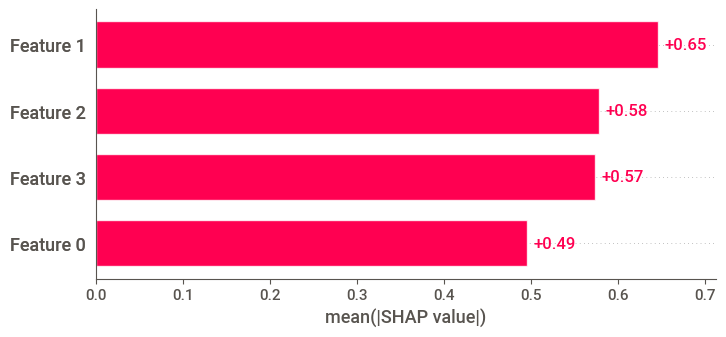

In [158]:
explainer = shap.Explainer(iso_forest, X_pca) 
shap_values = explainer(X_pca)

shap.plots.bar(shap_values)

Our Principle Component breakdowns

In [159]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=features.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)
# Get top 5 features by absolute loading for each principal component
for pc in loadings.columns:
    print(f"\nTop 5 features for {pc}:")
    top5 = loadings[pc].sort_values(key=abs, ascending=False).head(5)
    print(top5)


Top 5 features for PC1:
dem4       0.189048
pol4       0.183575
pol4m      0.182892
xconst     0.181797
polcomp    0.180713
Name: PC1, dtype: float64

Top 5 features for PC2:
geo34    0.222362
exrec   -0.200866
auto4    0.197284
elfo2   -0.188120
elfo    -0.175735
Name: PC2, dtype: float64

Top 5 features for PC3:
plurrel    0.233574
relfrac   -0.230641
parreg    -0.227291
durable   -0.226051
pol4sq    -0.185896
Name: PC3, dtype: float64

Top 5 features for PC4:
lpopns    0.359615
pop       0.313497
army85    0.292860
milper    0.292576
expgdp   -0.217323
Name: PC4, dtype: float64


#### 🧠 What Drove the **Highest SHAP Scores**?

1) **Feature 2** (i.e. PC3)

- `plurrel` - religious pluralism

- `relfrac` - religious fractionalization

- `durable` - regime longevity

- `parreg` - regulation of participation

- `pol4sq` - polity squared

Interpretation: The largest contributor to anomaly scores was **variation in religious diversity and regime stability** → country-year observations with rare combinations like **high religious fragmentation** but **long-lasting regimes** were often flagged as structurally unusual.

2) **Feature 1** (i.e. PC2)

- `elfo2` & `elfo` - ethnic dominance/fractionalization

- `auto4` - autocracy

- `geo34` - MENA region dummy

- `plural` - pluralism

Interpretation: The **ethnic structure and existence of autocratic rule** in specific regions (especially the **Middle East/North Africa**) made country-years stand out → anomalies may include **democracies in authoritarian regions** or **low-ethnic-fractionalization states surrounded by fragmented ones**.

3) **Feature 3** (i.e. PC4)

- `lpopns` - population size

- `milper` & `army85` - military personnel

- `sxpnew` - military spending

- `expgdp` - exports as % of GDP

Interpretation: Any countries with unusual combinations of **military size, economic openness, and population scale** → for example, **large armies in small economies**.

4) **Feature 0** (i.e. PC1)

- `dem4`, `pol4` & `pol4m` - democracy scores

- `xconst` - executive constraints

- `sip2` - political indicators

Interpretation: Unusual political regimes — such as **high democracy scores in autocratic contexts**, or vice versa — strongly shaped the structural space and flagged anomalies when mismatched with other features.

#### **To Summarise...**

We discover via. **SHAP analysis** that **religious diversity** and **regime durability** were the strongest contributors to anomaly scores, followed by **ethnic dominance** (PC2), **military capacity** (PC4), and **political regime structure** (PC1).

#### Breaking Down Anomalies by Region

/var/folders/3m/wqvcp0vs4n3fc_ywqy10vbhw0000gn/T/ipykernel_65602/2931032874.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




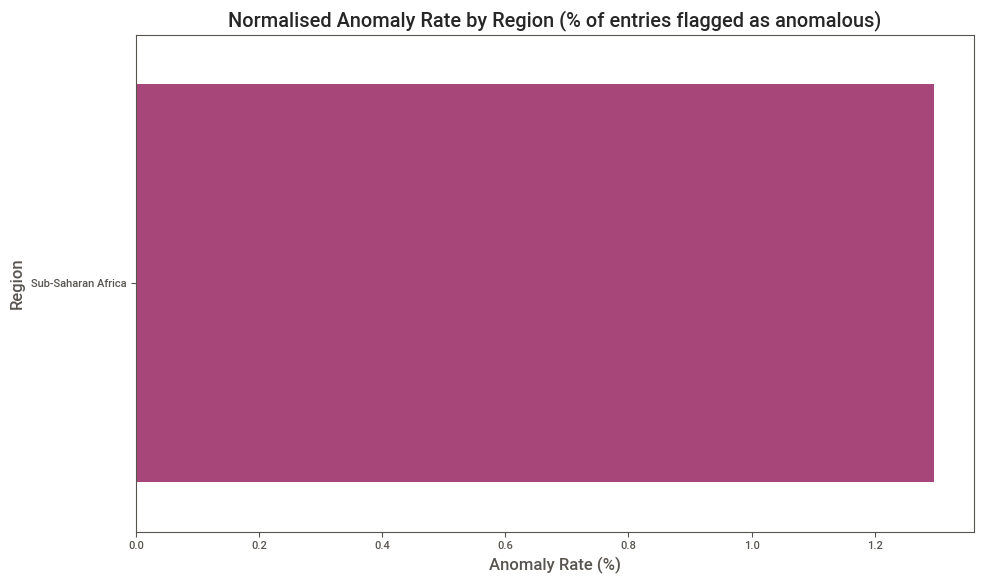

In [160]:
# Assign region to each anomaly using geo dummies
region_map = {
    'geo1': 'Western Europe / US',
    'geo2': 'Eastern Europe / Central Asia',
    'geo34': 'Middle East / North Africa',
    'geo57': 'South & East Asia / Oceania',
    'geo69': 'Latin America',
    'geo8': 'Sub-Saharan Africa'
}

def assign_region(row):
    for geo_col, region_name in region_map.items():
        if row.get(geo_col) == 1:
            return region_name

# Apply to anomalies
geo_cols = list(region_map.keys())
anomalies_geo = anomalies.merge(unsupervised_df[['cowcode', 'year'] + geo_cols], on=['cowcode', 'year'], how='left')
anomalies_geo['Region'] = anomalies_geo.apply(assign_region, axis=1)

# Assign region to full dataset for normalisation
unsupervised_df['Region'] = unsupervised_df.apply(assign_region, axis=1)

# Calculate anomaly rate by region
region_anomaly_counts = anomalies_geo['Region'].value_counts()
region_total_counts = unsupervised_df['Region'].value_counts()
region_anomaly_rate = (region_anomaly_counts / region_total_counts * 100).sort_values(ascending=False)

# Plot anomaly rate by region
plt.figure(figsize=(10, 6))
sns.barplot(x=region_anomaly_rate.values, y=region_anomaly_rate.index, palette='magma')
plt.title('Normalised Anomaly Rate by Region (% of entries flagged as anomalous)')
plt.xlabel('Anomaly Rate (%)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()

#### 🌍 **Regional Anomaly Rates**: Interpreting Model Deviations

The plot above shows the proportion of country-years flagged as **anomalies** within each region, **normalised by total regional presence** in the data.

- **South & East Asia / Oceania** & **Western Europe / US** exhibited the highest normalized anomaly rates (~7% and ~3%). These regions are typically stable but tend to contain unusual structural combinations — such as high GDP alongside sharp ethnic or institutional contrasts — that deviate from global conflict trends.

- **Sub-Saharan Africa** & **Eastern Europe / Central Asia** had low anomaly rates. Their data points tend to align more closely with the structural profiles our model may associate with conflict risk — e.g., low income, high illiteracy, or political instability.

Let's **check some examples** now shall we!

#### **1) 🕊️ Peaceful Anomaly: Zimbabwe (750) in 1968**

This country-year observation did **not** experience civil war.

#### 🔍 Feature Profile (Final Model Features Only)
- **Structural risk factors**:  
  - `ln_gdpen = -0.32`, `infant = 157`, `illiteracy = 33.4%` → extremely poor socioeconomic conditions  

  - `elfo = 89` → very high ethnic fractionalization  

  - `sxpsq = 0.0003` → low per-soldier military spending  

  - `lmtnest = 2.63` → moderately mountainous terrain

- **Procedural factors**:  
  - `milper_ratio`: high (given 1,077 military personnel and small population)  

  - `durable = 17` → moderately stable regime  

  - `polcomp = 9`, `autch98 = 0` → suggests full political competition and non-autocracy

- **Control**:  
  - `lpopns = 20.07` → moderate population size (log scale)

#### ⚠️ Why Is This Anomalous?
This case exhibits nearly all the **hallmarks of conflict risk** from our model. However, the political indicators misleadingly portray a stable democracy, despite Zimbabwe being a white-minority colonial regime at the time. The apparent institutional openness (`polcomp = 9`) fails to reflect political exclusion of the black majority.


---

#### 🔥 **2) War-Onset Anomaly: South Africa (710) in 1966**

This country-year observation **did** experience civil war.

#### 🔍 Feature Profile (Final Model Features Only)
- **Structural risk factors**:  
  - `ln_gdpen = -0.44` → very low income per capita  

  - `infant = 90`, `illiteracy = 42.1%` → poor health and education outcomes  

  - `elfo = 12` → **surprisingly low ethnic fractionalization**  

  - `sxpsq = 0.0202` → moderate military spending per soldier  

  - `lmtnest = 3.65` → fairly rugged terrain

- **Procedural factors**:  
  - `milper_ratio`: very high — 3,360 soldiers relative to a modest population (`lpopns = 20.4`)  

  - `durable = 16` → long-standing regime  

  - `polcomp = 1` → **extremely low political competition**  

  - `autch98 = 1` → coded as autocratic

- **Control**:  
  - `lpopns = 20.4` → moderately sized population (log scale)

#### ⚠️ Why Is This Anomalous?
This country-year combines strong signals of **authoritarianism and militarisation** with poor socioeconomic indicators — yet it shows **low ethnic fractionalization** (`elfo = 12`), which deviates from typical civil war onset cases.

Given that this is **Apartheid-era South Africa**, the anomaly likely stems from:
- Underreporting or misclassification of **ethnic division** in the `elfo` metric
- A regime that appears “stable” due to institutional longevity, but was deeply exclusionary

#### 🧠 Interpretation
This is a **war-onset outlier** that highlights a key limitation in standard conflict metrics:
- **Low `elfo`** doesn’t capture **racial exclusion** under apartheid
- Institutional durability (`durable = 16`) hides the system’s repressive nature

This supports the argument that some structural predictors (like `elfo`) may **misrepresent conflict risk** in highly segregated authoritarian regimes.

### **Unsupervised Learning Summary**

Despite the extensive unsupervised learning undertaken — including PCA, clustering, and anomaly detection — the features highlighted by these techniques did not reveal a consistent or compelling pattern strong enough to warrant inclusion in the final supervised modelling pipeline. While certain components such as regime type indicators (`pol4`, `dem4`), ethnic fractionalisation metrics (`elfo`, `plural`), and economic structure variables (`expgdp`, `sxpnew`) surfaced repeatedly in regional PCA loadings, their influence did not generalise in a statistically robust or practically actionable way across the dataset.

In particular, our use of Principal Component Analysis aimed to identify latent structures and reduce multicollinearity in a high-dimensional feature space. While it did successfully distil large sets of correlated indicators into interpretable axes of variation — such as regime strength, economic openness, and cultural diversity — the top contributing features varied significantly across regions and decades. This lack of stability limited the extent to which these components could be integrated into a generalised predictive model. Moreover, the principal components themselves, being linear combinations of many features, proved challenging to interpret or justify within the constraints of an explainable supervised approach such as K-NN.

Clustering and anomaly detection were implemented not as final modelling tools, but rather as diagnostic instruments to stress-test our assumptions and feature selection. By comparing the cluster memberships derived from different regional and temporal subsets, we were able to assess the extent to which structural patterns held consistently. This process revealed that while some clusters reflected expected geopolitical or developmental groupings, many were sensitive to pre-processing choices and PCA dimensionality. In short, the clustering was informative — but not actionable.

Anomaly detection was used to identify outlier observations based on PCA-transformed coordinates and distance-based metrics. Although this surfaced a handful of data points with structurally unusual feature profiles, manual inspection revealed that most of these were not true data anomalies, but rather countries with unique or transitional profiles (e.g. post-conflict states or resource-rich autocracies). Consequently, we opted not to exclude or isolate these from the supervised modelling phase, as doing so risked introducing bias rather than improving signal.

Taken together, the unsupervised techniques served an important role as part of our robustness and sensitivity analysis pipeline. They allowed us to probe the structural consistency of our data, evaluate the dimensional complexity of our predictors, and sense-check the interpretability of our features. Their results were ultimately not used to define the final feature set, but they provided us with crucial assurance that the features we did select were not obviously distorted by hidden groupings, spurious correlations, or embedded noise.

## **03 Classification models**  

Add a linking paragraph that combines sections 1 and 2's insights before introducing the finalised feature set for the classification models.  
... features ...  
  


In [276]:
final_features = ['infant', 'illiteracy', 'elfo2', 'sxpsq', 'lmtnest', 
                  'durable', 'autch98', 'lpopns', 'rcd', 
                  'gdp_growth_lag1', 'gdp_growth_deviation_std']

identity_cols = ['cowcode', 'year']

df_filtered = df[identity_cols + final_features].copy()
df_filtered['warstds'] = df['warstds']

In [277]:
df_filtered.isna().sum()

cowcode                     0
year                        0
infant                      0
illiteracy                  0
elfo2                       0
sxpsq                       0
lmtnest                     0
durable                     0
autch98                     0
lpopns                      0
rcd                         0
gdp_growth_lag1             0
gdp_growth_deviation_std    0
warstds                     0
dtype: int64

In [278]:
df_filtered = df_filtered.dropna()

### **3.1 Explaning our methodological choices**   
Before delving into the classification models, we first outline the core methodological choices applied consistently across all models:

> **3.1.1 Train-Test Split**
  
The training and test sets are split by year, respecting the temporal nature of the data. By training the model on earlier years and testing it on later years, we can better simulate real-world scenarios where we want to predict future civil war onset based on past data. Crucially, this approach helps to avoid data leakage, where information from the test set could inadvertently influence the model during training, leading to overly optimistic performance estimates.
  
As we have previously identified in Section 1.1.1, we found that using a **70/30 split with 1987 as the threshold year** provided the most consistent class distribution between the training and test sets. This decision is particularly important given the highly imbalanced nature of our dataset, where civil war onset events (the positive class) are extremely rare compared to non-onset years (the negative class).  
  
Maintaining a relatively stable class distribution across training and test sets is critical for two reasons. First, it ensures that the model is exposed to a realistic frequency of conflict and non-conflict cases during training, which improves its ability to generalise. Second, it allows for a more meaningful and reliable evaluation of model performance on the test set. If the class balance differed substantially between the train and test sets, the model's performance metrics could be misleading, as they would reflect not only the model’s quality but also the shift in the underlying data distribution. By carefully selecting a split point that balances the distribution of conflict onsets across periods, we aim to reduce bias in performance assessment and increase the robustness of our comparison across models.  

In [279]:
# sort by year to simplify code later
df_filtered = df_filtered.sort_values(by=['year'])

# use year 1987 to define train/test split
train_df = df_filtered[df_filtered['year'] < 1987]
test_df = df_filtered[df_filtered['year'] >= 1987]

# split features and target variable
X_train, y_train = train_df[final_features], train_df['warstds']
X_test, y_test = test_df[final_features], test_df['warstds']

> **3.1.2 Dealing with Class Imbalance**  
  
Let's take a look at the distribution of the target variable in the training and test sets again:

In [280]:
# check class distribution in train and test sets
print(train_df['warstds'].value_counts(normalize=True))
print(test_df['warstds'].value_counts(normalize=True))  

warstds
0    0.985523
1    0.014477
Name: proportion, dtype: float64
warstds
0    0.988812
1    0.011188
Name: proportion, dtype: float64


A central challenge in modelling civil war onset is the extreme imbalance in the data. In both our training and test sets, the positive class—years with civil war onset—makes up only about 1% of observations (training set: 1.4%; test set: 1.1%), while the negative class (no civil war) accounts for over 98% of the data. This imbalance reflects the empirical rarity of civil war onset events, consistent with global political patterns. However, it poses significant challenges for model training and evaluation, as standard classification algorithms may become biased towards the majority class, leading to poor predictive performance for the minority class. Therefore, we will employ several techniques to address this imbalance and improve our model's ability to accurately predict civil war onset:  

1. **Choosing appropriate evaluation metrics**  

    In the context of highly imbalanced data, where civil war onset is rare (about 1.4% of cases), conventional metrics such as overall accuracy become misleading. For example, a model that always predicts “no war” would achieve over 98% accuracy but would completely fail to detect actual onset cases, offering no substantive value.  
  
    Before we dive into our chosen evaluation metrics, let's interpret the different error types in context:  

    | Terminology | Interpretation |
    |---|---|
    |True Positive (TP)|Model predicts civil war onset, and it actually occurs|
    |True Negative (TN)|Model predicts no civil war, and it doesn't occur|
    |False Positive (FP)|Model predicts civil war onset, but it doesn't occur (false alarm)|
    |False Negative (FN)|Model predicts no civil war, but it actually occurs (missed opportunity)|  
    
    In the civil war context, we expect **false negatives (FN) to be much more costly** — they represent failure to anticipate conflict, which can lead to missed opportunities for preventive intervention, humanitarian response, or diplomatic efforts. False positives (FP), while still undesirable, are generally less costly, often amounting to false alarms or unnecessary preparation. 

    With this in mind, we will rely on metrics that account for the balance between classes and reflect the real-world importance of detecting rare positive events. These include:

    * **Recall**: This metric focuses on the model's ability to correctly identify positive cases (civil war onset). It is calculated as $ \frac{TP}{TP + FN} $, with a higher recall indicating better performance in detecting actual civil war events. Given the high cost of false negatives in this context, recall is a critical metric for our analysis.  
    * **F1 Score**: The F1 score is the harmonic mean of precision and recall, providing a single score that balances both metrics. It is particularly useful when dealing with imbalanced datasets, as it penalises models that perform well on one metric but poorly on the other. It is given by:
    $$
    F_1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
    $$
    * **F2 Score**: The F2 score is a weighted version of the F1 score that gives more importance to recall, aligning well with our focus on minimising false negatives. It is calculated as:
    $$
    F_2 = (1 + 2^2) \cdot \frac{\text{Precision} \cdot \text{Recall}}{(2^2 \cdot \text{Precision}) + \text{Recall}}
    $$
    
    While **area under the precision-recall curve (AUC-PR)** is often recommended for imbalanced datasets, a key limitation in our dataset is the low number of positive cases (only ~1.6% of the data). This makes the precision-recall curve highly sensitive to small changes in the number of positive cases, resulting in unstable or jagged curves and hence a less reliable AUC-PR score. Therefore, we will just report the AUC-PR score for reference, but we will not use it as a primary evaluation metric. Instead, we will focus on recall, F1, and F2 scores to assess model performance.  
  
2. **Adjusting class weights and model selection**  
  
    Some models natively support class weighting, allowing us to assign higher weights to the minority class (civil war onset) during training. This helps the model pay more attention to the positive class and reduces bias towards the majority class. For example, in a logistic regression model, we can set the `class_weight` parameter to `balanced`, which automatically adjusts weights inversely proportional to class frequencies. This way, the model will treat misclassifications of civil war onset as more costly than misclassifications of non-onset years.   
   
    The ability to adjust class weights was one key consideration guiding our choice of models. In the 3 models that we ultimately selected (Logistic Regression, Random Forest, and LightGBM), we can easily adjust class weights. Further elaboration on this will be provided in the respective model sections.
  
3. **Avoiding undersampling/ oversampling**   
  
    While undersampling the majority class or oversampling the minority class helps to balance the dataset, they can be problematic for time-series data like ours. Random undersampling/ oversampling disrupts the temporal structure of the data, which is crucial for understanding civil war onset. For example, if we randomly remove years without civil war onset (i.e. undersample the majority class), we are essentially cutting out long stretches of peaceful years, which destroys the temporal distribution of peaceful periods. The model may then wrongly think peace is unstable or chaotic.  

4. **Threshold adjustment and tuning**  
  
    The default threshold for classifying a predicted probability as a positive case is 0.5. However, in the context of imbalanced data, this threshold may not be optimal. By adjusting the threshold, we can increase the model's sensitivity to the minority class (civil war onset) and improve recall. For example, lowering the threshold to 0.3 or 0.4 may yield more true positives at the cost of increasing false positives. We will explore this in our model evaluation section.  

> **3.1.3 TimeSeriesSplit (TSCV)**

Rather than using traditional k-fold cross-validation, we implement cross-validation using **TimeSeriesSplit (TSCV)**. Within the initally partialled out training set, TimeSeriesSplit creates multiple folds of training and validation sets, where the validation set is always after the training set. This is important for time series data like ours as it preserves the temporal order of the data and prevents data leakage. Throughout the 3 models, we use TimeSeriesSplit with **5 splits** to evaluate the model’s performance on the training set.

> **3.1.4 F2 score as the primary metric** 

We have previously discussed the advantages of using the F2 score as our primary evaluation metric. For those reasons, we used a custom `f2_scorer` in cross-validation and threshold tuning.  
  
> **3.1.5 Threshold tuning using a held-out validation set**  

Instead of using the default classification threshold of 0.5, we split off a validation set from the training data (10% of the training set) to determine the optimal threshold that maximises the F2 score. Using a held-out validation set allows us to fine-tune the threshold based on the model's performance on unseen data, ensuring that we select a threshold that generalises well to new instances. It should not be tuned on the test set, as that is a form of data leakage. With the optimal threshold determined, we can then apply it to the test set for final evaluation. This approach helps us achieve a more robust and reliable model performance assessment.


### **3.2 Model 1: Logistic Regression (Baseline)**  
  
For classification tasks, it is common to start with a **logistic regression** model as a baseline. This is because it is **simple, interpretable**, and often serves as a good benchmark for more complex models. For logistic regression, it is important to first **standardise the features** to ensure that they are on the same scale. If not, the model may be biased towards features with larger scales, leading to suboptimal performance. We will add `StandardScaler` to the pipeline to standardise the features before fitting the model.  

We use GridSearchCV to tune the 'C' parameter, which controls the regularisation strength. A smaller value of 'C' indicates stronger regularisation, while a larger value indicates weaker regularisation. We will also set the `class_weight` parameter to `'balanced'` to account for class imbalance. This uses the values of the target variable to automatically adjust the weights inversely proportional to class frequencies. This helps the model pay more attention to the minority class (civil war onset) during training.  

A function `logistic_regression_pipeline` is created to combine all the tuning, training, and evaluation steps into a single pipeline. 

In [281]:
def logistic_regression_pipeline(X_train, y_train, X_test, y_test, n_splits=5):
    # Step 1: Grid Search for best C using TimeSeriesSplit
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
    ])
    param_grid = {'logreg__C': [0.01, 0.1, 1, 10]}
    tscv = TimeSeriesSplit(n_splits=n_splits)
    num_folds = tscv.get_n_splits()
    f2_scorer = make_scorer(fbeta_score, beta=2)

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=f2_scorer,
        cv=tscv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Step 2: Cross-validation scores
    f1_scores, f2_scores, auc_prs, recalls, best_thresholds = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"Processing fold {fold}/{num_folds}...")
        
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = Pipeline([
            ('scaler', StandardScaler()),
            ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000,
                                          random_state=42, C=best_params['logreg__C']))
        ])
        model.fit(X_fold_train, y_fold_train)
        y_val_pred = model.predict(X_fold_val)
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]

        f1_scores.append(f1_score(y_fold_val, y_val_pred))
        f2_scores.append(fbeta_score(y_fold_val, y_val_pred, beta=2))
        auc_prs.append(average_precision_score(y_fold_val, y_val_proba))
        recalls.append(recall_score(y_fold_val, y_val_pred))

        # Threshold tuning for the current fold (maximize F2 score)
        best_thresh, best_f2 = 0, 0
        for thresh in np.arange(0.1, 0.9, 0.01):
            preds = (y_val_proba >= thresh).astype(int)
            score = fbeta_score(y_fold_val, preds, beta=2)
            if score > best_f2:
                best_thresh, best_f2 = thresh, score
        
        # Store the best threshold for this fold
        best_thresholds.append(best_thresh)

    # Step 3: Calculate average best threshold across folds
    average_best_threshold = np.mean(best_thresholds)

    # Step 4: Train final model on entire training set
    final_model = Pipeline([
        ('scaler', StandardScaler()),
        ('logreg', LogisticRegression(class_weight='balanced', max_iter=1000,
                                      random_state=42, C=best_params['logreg__C']))
    ])
    final_model.fit(X_train, y_train)

    # Step 5: Predict on test set using average best threshold
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= average_best_threshold).astype(int)

    # Step 6: Compute test set performance metrics
    f1_test = f1_score(y_test, y_test_pred)
    f2_test = fbeta_score(y_test, y_test_pred, beta=2)
    auc_pr_test = average_precision_score(y_test, y_test_proba)
    recall_test = recall_score(y_test, y_test_pred)

    # Step 7: Extract logistic regression coefficients
    logreg_model = final_model.named_steps['logreg']
    coefficients = logreg_model.coef_[0]

    coef_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coefficients
    }).sort_values(by='Coefficient', key=abs, ascending=False)

    return {
        'best_params': best_params,
        'cv_f1_mean': round(np.mean(f1_scores), 4),
        'cv_f2_mean': round(np.mean(f2_scores), 4),
        'cv_recall_mean': round(np.mean(recalls), 4),
        'cv_auc_pr_mean': round(np.mean(auc_prs), 4),
        'average_best_threshold': round(average_best_threshold, 4),
        'test_f1': round(f1_test, 4),
        'test_f2': round(f2_test, 4),
        'test_recall': round(recall_test, 4),
        'test_auc_pr': round(auc_pr_test, 4),
        'y_test_proba': y_test_proba,
        'y_test_pred': y_test_pred,
        'coef_df': coef_df
    }


In [282]:
logistic_results = logistic_regression_pipeline(X_train, y_train, X_test, y_test)
print("Logistic:", logistic_results)

Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...
Logistic: {'best_params': {'logreg__C': 10}, 'cv_f1_mean': 0.144, 'cv_f2_mean': 0.2443, 'cv_recall_mean': 0.7225, 'cv_auc_pr_mean': 0.1042, 'average_best_threshold': 0.646, 'test_f1': 0.0683, 'test_f2': 0.1408, 'test_recall': 0.4828, 'test_auc_pr': 0.0813, 'y_test_proba': array([0.38170866, 0.08289936, 0.81976707, ..., 0.71795921, 0.27468184,
       0.09496776]), 'y_test_pred': array([0, 0, 1, ..., 1, 0, 0]), 'coef_df':                      Feature  Coefficient
3                      sxpsq    -3.937470
10  gdp_growth_deviation_std    -0.883103
2                      elfo2     0.407502
4                    lmtnest     0.381997
5                    durable    -0.330055
0                     infant     0.323650
7                     lpopns     0.311698
9            gdp_growth_lag1     0.244725
1                 illiteracy     0.242467
8                        rcd     0.130727

We will discuss the model's performance metrics in the evaluation section (section 3.5) after running all the models.

#### 3.2.1 Interpretation of regression coefficients  
Here, we see the advantage of using a logistic regression model. It is interpretable, and we can extract the coefficients to understand the impact of each feature on the log-likelihood of civil war onset. This provides a clear mathematical relationship between the predictors and the target variable, allowing us to understand the direction and strength of the relationships.

In [283]:
logistic_results['coef_df']

Feature  Coefficient
3                      sxpsq    -3.937470
10  gdp_growth_deviation_std    -0.883103
2                      elfo2     0.407502
4                    lmtnest     0.381997
5                    durable    -0.330055
0                     infant     0.323650
7                     lpopns     0.311698
9            gdp_growth_lag1     0.244725
1                 illiteracy     0.242467
8                        rcd     0.130727
6                    autch98    -0.103355

In [284]:
# Plot coefficients as a bar chart
coef_plot = ggplot(logistic_results['coef_df'], aes(x='Feature', y='Coefficient', fill='Coefficient')) + \
    geom_bar(stat='identity', show_legend=False) + \
    coord_flip() + \
    ggtitle('Logistic Regression Coefficients') + \
    scale_fill_gradient2(midpoint=0, low='blue', mid='white', high='red')
    
# Show plot
coef_plot.show()

Since we standardised all the features, the logistic regression coefficients represent the **log-odds** of the target variable (civil war onset) given a **one standard deviation increase** in the predictor variable. This is the form of a logistic regression equation:     

$$
\text{Log Odds} = \log\left(\frac{p}{1-p}\right) = \beta_0 + \beta_1x_1 + \beta_2x_2 + \dots + \beta_nx_n
$$  

Where, in our context:

- $p$ is the probability of the target variable (civil war onset) being 1  
- $\beta_0$ is the intercept  
- $\beta_i$ is the regression coefficient for feature $x_i$

Let us look at **`sxpsq`** (Primary commodity exports as a % of GDP, squared) as an example. Its coefficient is **–3.94**, which means that a one standard deviation increase in squared commodity export dependence **reduces** the log-odds of civil war onset by 3.94, *holding all other variables constant*.  

For easier interpretation, we can also exponentiate the regression coefficient to get the **odds ratio** for a particular feature $x_i$:

$$
\text{Odds Ratio}_{x_i} = e^{\beta_i}
$$  

So for `sxpsq`, 

$$
\text{Odds Ratio}_{\text{sxpsq}} = e^{-3.94} \approx 0.019
$$  

This means that for every **one standard deviation increase in `sxpsq`**, the **odds of a civil war onset decrease by about 98.1%**, *holding all other variables constant*. The negative relationship may reflect a **rentier state effect**, where governments use resource revenues to fund security forces or patronage, thus reducing conflict risk. Alternatively, it could reflect **survivorship bias**—only stable resource-exporting regimes persist in the dataset.

---

### Other Key Predictors:

#### **Negative Predictors** (decrease civil war onset odds):

- **`gdp_growth_deviation_std` (–0.88)**  
  Greater GDP growth volatility is associated with **lower** odds of civil war onset—perhaps a counterintuitive result. This may suggest that short-term economic fluctuations don't immediately translate into instability.

- **`durable` (–0.33)**  
  Longer uninterrupted regime tenure significantly reduces conflict risk, consistent with institutional resilience.

- **`autch98` (–0.10)**  
  More autocratic regimes are modestly associated with reduced civil war risk, possibly due to repression capacity.

#### **Positive Predictors** (increase civil war onset odds):

- **`elfo2` (0.41)**  
  Higher ethnic fractionalisation (squared) increases the risk of civil war. The squared term implies a **non-linear** relationship, where very high diversity may have disproportionately destabilising effects.

- **`lmtnest` (0.38)**  
  Mountainous terrain raises conflict risk—consistent with theories that rugged terrain facilitates insurgency.

- **`infant` (0.32)**  
  Higher infant mortality rates are associated with worse health outcomes and, in turn, greater instability.

- **`lpopns` (0.31)**  
  Larger population size modestly increases the odds of civil war onset, perhaps reflecting greater mobilisation potential or governance challenges.

- **`gdp_growth_lag1` (0.24)**  
  Higher GDP growth in the previous year slightly increases onset odds—this could reflect underlying tensions masked by short-term economic performance.

- **`illiteracy` (0.24)**  
  Higher illiteracy rates are associated with elevated civil war risk, possibly due to weaker human capital and lower opportunity costs of rebellion.

- **`rcd` (0.13)**  
  A recent history of conflict modestly increases the likelihood of new onset, suggesting **conflict persistence**.

---

> **Note:**  
> Since there are multiple regressors (features) in the model, the interpretation of the coefficients is based on the assumption that the other variables are held constant. This is known as the **ceteris paribus** assumption.


### **3.3 Model 2: Random Forest**  
The second model we will implement is a **Random Forest** classifier. Random Forest is an ensemble learning method that constructs multiple decision trees during training and outputs the mode of their predictions. It is particularly effective for handling complex datasets with non-linear relationships and interactions between features.  

We use the `RandomForestClassifier` and set the `class_weight` parameter to `'balanced'` to account for class imbalance (as we did in the logistic regression model). We will also use `GridSearchCV` to tune the hyperparameters, including the number of trees (`n_estimators`), the maximum depth of each tree (`max_depth`), the minimum number of samples required to split an internal node (`min_samples_split`), and the minimum number of samples required to be at a leaf node (`min_samples_leaf`).  

Like the logistic regression model, a similar function `random_forest_pipeline` is created to combine all the steps.

In [285]:
def random_forest_pipeline(X_train, y_train, X_test, y_test, n_splits=5):
    # Step 1: Grid Search for best hyperparameters using TimeSeriesSplit
    param_grid = {
        'n_estimators': [100, 250, 400],
        'max_depth': [None, 3, 5], 
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    num_folds = tscv.get_n_splits()
    f2_scorer = make_scorer(fbeta_score, beta=2)

    rf = RandomForestClassifier(class_weight='balanced', random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring=f2_scorer,
        cv=tscv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Step 2: Cross-validation scores
    f1_scores, f2_scores, auc_prs, recalls, best_thresholds = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"Processing fold {fold}/{num_folds}...")
        
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = RandomForestClassifier(class_weight='balanced', random_state=42, **best_params) 
        model.fit(X_fold_train, y_fold_train)
        y_val_pred = model.predict(X_fold_val)
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]

        f1_scores.append(f1_score(y_fold_val, y_val_pred))
        f2_scores.append(fbeta_score(y_fold_val, y_val_pred, beta=2))
        auc_prs.append(average_precision_score(y_fold_val, y_val_proba))
        recalls.append(recall_score(y_fold_val, y_val_pred))

        # Threshold tuning for the current fold (maximize F2 score)
        best_thresh, best_f2 = 0, 0
        for thresh in np.arange(0.1, 0.9, 0.01):
            preds = (y_val_proba >= thresh).astype(int)
            score = fbeta_score(y_fold_val, preds, beta=2)
            if score > best_f2:
                best_thresh, best_f2 = thresh, score
        
        # Store the best threshold for this fold
        best_thresholds.append(best_thresh)

    # Step 3: Calculate average best threshold across folds
    average_best_threshold = np.mean(best_thresholds)

    # Step 4: Train final model on entire training set
    final_model = RandomForestClassifier(
        class_weight='balanced', random_state=42, **best_params
    )
    final_model.fit(X_train, y_train)

    # Step 5: Predict on test set using average best threshold
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= average_best_threshold).astype(int)

    # Step 6: Compute test set performance metrics
    f1_test = f1_score(y_test, y_test_pred)
    f2_test = fbeta_score(y_test, y_test_pred, beta=2)
    auc_pr_test = average_precision_score(y_test, y_test_proba)
    recall_test = recall_score(y_test, y_test_pred)

    return {
        'best_params': best_params,
        'cv_f1_mean': round(np.mean(f1_scores), 4),
        'cv_f2_mean': round(np.mean(f2_scores), 4),
        'cv_recall_mean': round(np.mean(recalls), 4),
        'cv_auc_pr_mean': round(np.mean(auc_prs), 4),
        'average_best_threshold': round(average_best_threshold, 4),
        'test_f1': round(f1_test, 4),
        'test_f2': round(f2_test, 4),
        'test_recall': round(recall_test, 4),
        'test_auc_pr': round(auc_pr_test, 4),
        'y_test_proba': y_test_proba,
        'y_test_pred': y_test_pred
    }


In [286]:
rf_results = random_forest_pipeline(X_train, y_train, X_test, y_test)
print("Random Forest:", rf_results)

Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...
Random Forest: {'best_params': {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}, 'cv_f1_mean': 0.2164, 'cv_f2_mean': 0.3401, 'cv_recall_mean': 0.7001, 'cv_auc_pr_mean': 0.1696, 'average_best_threshold': 0.512, 'test_f1': 0.092, 'test_f2': 0.1816, 'test_recall': 0.5172, 'test_auc_pr': 0.0592, 'y_test_proba': array([0.09422655, 0.24270108, 0.79307425, ..., 0.82486532, 0.12811537,
       0.06592036]), 'y_test_pred': array([0, 0, 1, ..., 1, 0, 0])}


Again, we will just print the results of the model here and leave the analysis for section 3.5.

### **3.4 Model 3: LightGBM**   
The final model chosen for our analysis is **LightGBM**. LightGBM is a gradient boosting framework that uses tree-based learning algorithms. It is optimised for speed and efficiency, making it particularly suitable for large datasets. We set the `scale_pos_weight` parameter to the ratio of negative to positive classes, which helps to balance the class distribution during training. We will also use `GridSearchCV` to tune the hyperparameters, which are mostly similar to those used in the Random Forest model, though we also include `learning_rate`, a crucial hyperparameter to tune in gradient boosting models. This parameter controls the contribution of each tree to the final prediction. A smaller learning rate requires more trees to achieve the same level of accuracy, but it can lead to better generalisation. 

In [287]:
def lgbm_pipeline(X_train, y_train, X_test, y_test, n_splits=5):
    # Step 1: Grid Search for best hyperparameters using TimeSeriesSplit
    param_grid = {
        'n_estimators': [100, 250, 400],
        'max_depth': [-1, 3, 5],
        'num_leaves': [15, 31, 63],
        'min_child_samples': [10, 20, 30],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    tscv = TimeSeriesSplit(n_splits=n_splits)
    num_folds = tscv.get_n_splits()
    f2_scorer = make_scorer(fbeta_score, beta=2)

    # Handle imbalance via scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    base_model = LGBMClassifier(objective='binary', verbose=-1, random_state=42, scale_pos_weight=scale_pos_weight)
    grid_search = GridSearchCV(base_model, param_grid, scoring=f2_scorer, cv=tscv, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_

    # Step 2: Cross-validation scores
    f1_scores, f2_scores, auc_prs, recalls, best_thresholds = [], [], [], [], []

    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), 1):
        print(f"Processing fold {fold}/{num_folds}...")
        
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LGBMClassifier(objective='binary', verbose=-1, random_state=42, scale_pos_weight=scale_pos_weight, **best_params)
        model.fit(X_fold_train, y_fold_train)
        y_val_pred = model.predict(X_fold_val)
        y_val_proba = model.predict_proba(X_fold_val)[:, 1]

        f1_scores.append(f1_score(y_fold_val, y_val_pred))
        f2_scores.append(fbeta_score(y_fold_val, y_val_pred, beta=2))
        auc_prs.append(average_precision_score(y_fold_val, y_val_proba))
        recalls.append(recall_score(y_fold_val, y_val_pred))

        # Threshold tuning for the current fold (maximize F2 score)
        best_thresh, best_f2 = 0, 0
        for thresh in np.arange(0.1, 0.9, 0.01):
            preds = (y_val_proba >= thresh).astype(int)
            score = fbeta_score(y_fold_val, preds, beta=2)
            if score > best_f2:
                best_thresh, best_f2 = thresh, score
        
        # Store the best threshold for this fold
        best_thresholds.append(best_thresh)

    # Step 3: Calculate average best threshold across folds
    average_best_threshold = np.mean(best_thresholds)

    # Step 4: Train final model on entire training set
    final_model =  LGBMClassifier(objective='binary', verbose=-1, random_state=42, scale_pos_weight=scale_pos_weight, **best_params)
    final_model.fit(X_train, y_train)

    # Step 5: Predict on test set using average best threshold
    y_test_proba = final_model.predict_proba(X_test)[:, 1]
    y_test_pred = (y_test_proba >= average_best_threshold).astype(int)

    # Step 6: Compute test set performance metrics
    f1_test = f1_score(y_test, y_test_pred)
    f2_test = fbeta_score(y_test, y_test_pred, beta=2)
    auc_pr_test = average_precision_score(y_test, y_test_proba)
    recall_test = recall_score(y_test, y_test_pred)

    return {
        'best_params': best_params,
        'cv_f1_mean': round(np.mean(f1_scores), 4),
        'cv_f2_mean': round(np.mean(f2_scores), 4),
        'cv_recall_mean': round(np.mean(recalls), 4),
        'cv_auc_pr_mean': round(np.mean(auc_prs), 4),
        'average_best_threshold': round(average_best_threshold, 4),
        'test_f1': round(f1_test, 4),
        'test_f2': round(f2_test, 4),
        'test_recall': round(recall_test, 4),
        'test_auc_pr': round(auc_pr_test, 4),
        'y_test_proba': y_test_proba,
        'y_test_pred': y_test_pred
    }


In [288]:
lgbm_results = lgbm_pipeline(X_train, y_train, X_test, y_test)
print("LGBM:", lgbm_results)

Processing fold 1/5...
Processing fold 2/5...
Processing fold 3/5...
Processing fold 4/5...
Processing fold 5/5...
LGBM: {'best_params': {'learning_rate': 0.01, 'max_depth': 3, 'min_child_samples': 20, 'n_estimators': 250, 'num_leaves': 15}, 'cv_f1_mean': 0.1737, 'cv_f2_mean': 0.2909, 'cv_recall_mean': 0.7046, 'cv_auc_pr_mean': 0.1417, 'average_best_threshold': 0.64, 'test_f1': 0.0819, 'test_f2': 0.1357, 'test_recall': 0.2414, 'test_auc_pr': 0.0652, 'y_test_proba': array([0.01276034, 0.17925118, 0.75098299, ..., 0.79174092, 0.01505442,
       0.01721789]), 'y_test_pred': array([0, 0, 1, ..., 1, 0, 0])}


Let's also plot the precision-recall curve for the LightGBM model to illustrate why relying on just the AUC-PR score is not ideal in our case:

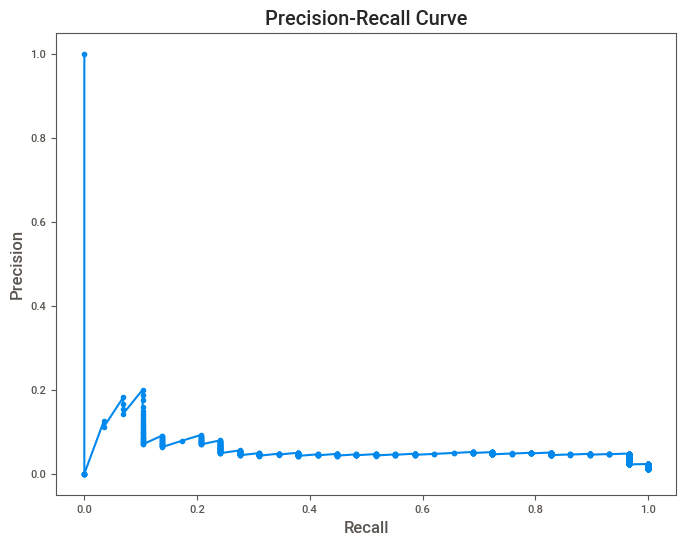

In [289]:
# plot the precision-recall curve
precision, recall, pr_thresholds = precision_recall_curve(y_test, lgbm_results['y_test_proba'])
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='o')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


The curve is very jagged, indicating that the model's performance is highly sensitive to small changes in the number of positive cases. This makes the AUC-PR score less reliable as a performance metric, confirming our decision to use **F1**, **F2**, and **recall** as our primary evaluation metrics rather than AUC-PR. 

### **3.5 Model evaluation and comparison**  
Here is a summary of the performance metrics of the 3 models from sections 3.2, 3.3, and 3.4: 

| **Model**               | **CV F1** | **CV F2** | **CV Recall** | **CV AUC-PR** | **Avg Threshold** | **Test F1** | **Test F2** | **Test Recall** | **Test AUC-PR** |
| ----------------------- | --------- | --------- | ------------- | ------------- | ----------------- | ----------- | ----------- | --------------- | --------------- |
| **Logistic Regression** | 0.144     | 0.2443    | 0.7225        | 0.1042        | 0.646             | 0.0683      | 0.1408      | 0.4828          | 0.0813          |
| **Random Forest**       | 0.2164    | 0.3401    | 0.7001        | 0.1696        | 0.512             | 0.092       | 0.1816      | 0.5172          | 0.0592          |
| **LightGBM**            | 0.1737    | 0.2909    | 0.7046        | 0.1417        | 0.64              | 0.0819      | 0.1357      | 0.2414          | 0.0652          |

  
1. Performance metrics and trade-offs  
    The **Random Forest model outperforms the other two models overall**, as it achieves the **highest test F1, F2 scores, and recall**. This indicates that it is the most balanced in terms of capturing true positives while maintaining a reasonable level of precision, making it the best choice among the three models. LightGBM, despite having decent cross-validation scores (CV F2: 0.2909, CV F1: 0.1737), performs worse on the test set with a low test F2 of 0.1357 and test recall of 0.2414. Its sharp drop in generalisation performance makes it less reliable than Random Forest for this particular task. Logistic Regression performs similarly to LightGBM in terms of F2 (0.1408 test), but achieves a notably higher recall (0.4828), though it still struggles with precision and overall F1/F2 scores. Its high recall (0.7225 CV, 0.4828 test) indicates it’s more inclined to predict the minority class, but at the expense of precision, leading to lower F1/F2 performance.

    Overall, Random Forest is the most balanced model across key metrics, whereas Logistic Regression and LightGBM give similar results, with Logistic Regression performing slightly better across most metrics. Random Forest offers the best compromise between catching true positives and avoiding false alarms.

    *Why is LightGBM underperforming?*     
      
    * LightGBM may not be capturing the relationships between features as well as Random Forest; the way LightGBM works with leaf-wise boosting might have trouble with datasets where the complexity is not suited to its tree growth strategy.
    * The model may be **overfitting** to the training data, leading to poor generalisation on the test set. This is supported by the fact that LightGBM has a higher CV AUC-PR (0.1417) compared to its test AUC-PR (0.0652), indicating that it is memorising the training data rather than learning generalisable patterns.
    * Even though we performed grid search and hyperparameter tuning, it’s possible that the **parameters selected for LightGBM aren't the most optimal for this dataset**, particularly the *learning rate* and *number of leaves*. While LightGBM can be highly powerful, it **requires careful tuning**, and small deviations in hyperparameters can lead to significant performance differences.  
    
2. Class Imbalance Impact

    The low AUC-PR across all models, despite tuning and optimisation, reflects the extreme class imbalance in the dataset (positive class ~1.1%). Precision-recall curves are inherently low when the positive class is rare. A model that randomly guesses on the test set would yield an AUC-PR of 0.011 (the proportion of minority class in the test set). Here, all 3 models have a test AUC-PR above 0.059, indicating that they are indeed learning something useful from the data. However, their AUC-PR scores are still too low to convincingly conclude their predictive power.  

3. Threshold Tuning

    Intuitively, we might expect the optimal thresholds to be significantly below 0.5 due to the extreme class imbalance — with the positive class making up only ~1.2% of the data, a lower threshold should help detect more positives (increase recall). However, the **optimal thresholds for all three models remain above 0.5**:

    * Logistic Regression: avg. threshold = 0.646

    * Random Forest: avg. threshold = 0.512

    * LightGBM: avg. threshold = 0.64

    This result reveals an important insight about the models’ internal probability calibration and the relative distribution of predicted scores for the positive class. In all three models, the predicted probabilities for the positive class tend to be extremely low, often clustering near 0 for most negative instances and only slightly higher (e.g. 0.6–0.7) for true positives. As a result, lowering the threshold below 0.5 admits many false positives that do not meaningfully increase recall but drastically lower precision — causing a net drop in the F2 score.

    Specifically:

    * For Logistic Regression and LightGBM, lowering the threshold below 0.5 floods the positive predictions with low-confidence scores. This leads to a small gain in recall but a severe drop in precision, which harms F2 overall. Their higher optimal thresholds (~0.64) reflect the need to stay conservative to avoid excessive false positives.

    * Random Forest has a more evenly distributed probability output due to its averaging mechanism across trees. This makes it slightly more flexible, with an optimal threshold closer to 0.5 (0.512), balancing between admitting more positives while avoiding too many false alarms.

    * The fact that none of the models benefit from aggressive threshold reduction reinforces the idea that **these classifiers are already skewed toward the negative class**, and most predicted probabilities are so confidently near zero that threshold tuning can’t dramatically alter their behaviour without sacrificing F2. Thus, the **best F2 scores are achieved not by blindly lowering thresholds**, but by finding the sweet spot where recall gains still outweigh precision loss — which, in these models, happens to be around or above 0.5.

4. Signs of Overfitting

    **All the models exhibit signs of overfitting**, as indicated by the **disparity between their cross-validation and test set performance.** It could be that the models are capturing noise in the training data rather than generalisable patterns. This is particularly evident in the LightGBM model, which has a much higher CV AUC-PR (0.1417) compared to its test AUC-PR (0.0652). The Random Forest model also shows signs of overfitting, as its CV F1 score (0.2164) is significantly higher than its test F1 score (0.092). The Logistic Regression model, while still showing some overfitting, has a smaller gap between its CV and test F1/F2 scores.  

#### 3.5.1 Confusion matrix and interpretation  
The confusion matrix provides a visual representation of the model's performance on the test set, which can help us better understand the numbers behind the metrics. The confusion matrix shows the number of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) for each model. We will plot the confusion matrices for the 3 models side by side for comparison. 

In [290]:
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """
    Generates and plots a confusion matrix using Lets-Plot.

    Parameters:
    - y_true: Actual labels
    - y_pred: Predicted labels
    - title: Title for the plot
    """
    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Extract TP, FP, FN, TN
    TN, FP, FN, TP = conf_matrix.ravel()

    # Convert confusion matrix to a DataFrame
    conf_matrix_df = pd.DataFrame(conf_matrix, 
                                  columns=["Predicted 0", "Predicted 1"], 
                                  index=["Actual 0", "Actual 1"])

    # Melt the confusion matrix DataFrame to long format
    conf_matrix_long = conf_matrix_df.reset_index().melt(id_vars="index", value_vars=["Predicted 0", "Predicted 1"])
    conf_matrix_long.columns = ["Actual", "Predicted", "Count"]

    # Define mapping for labels
    label_map = {
        ("Actual 0", "Predicted 0"): "TN",
        ("Actual 0", "Predicted 1"): "FP",
        ("Actual 1", "Predicted 0"): "FN",
        ("Actual 1", "Predicted 1"): "TP",
    }

    # Add annotations for TP, FP, FN, TN
    conf_matrix_long['Annotation'] = conf_matrix_long.apply(
        lambda row: f"{label_map[(row['Actual'], row['Predicted'])]}: {row['Count']}", axis=1
    )

    # Create confusion matrix plot with Lets-Plot
    plot = ggplot(conf_matrix_long, aes(x='Predicted', y='Actual', fill='Count')) + \
        geom_tile() + \
        geom_text(aes(label='Annotation'), size=10, color='black', vjust=0.5, hjust=0.5) + \
        scale_fill_gradient(low='white', high='#FF7F50') + \
        ggtitle(title) + \
        xlab('Predicted') + \
        ylab('Actual') + \
        coord_fixed(ratio=1) + \
        theme_minimal() + \
        theme(legend_position='right')

    return plot

logistic_cm_test = plot_confusion_matrix(y_test, logistic_results['y_test_pred'], title="Test Set Confusion Matrix (Logistic)")
rf_cm_test = plot_confusion_matrix(y_test, rf_results['y_test_pred'], title="Test Set Confusion Matrix (RF)")
lgbm_cm_test = plot_confusion_matrix(y_test, lgbm_results['y_test_pred'], title="Test Set Confusion Matrix (LGBM)")

gggrid([logistic_cm_test, rf_cm_test, lgbm_cm_test])

Looking at the confusion matrices on the test set, we observe the following:

* **Logistic Regression**:  

    With **15 false negatives (FN) and 14 true positives (TP)**, Logistic Regression achieves a **moderate recall**, successfully identifying nearly half of the actual positives. However, it incurs a **high number of 367 false positives (FP)**, indicating that the model is relatively **aggressive in labelling cases as positive**. This high false positive rate hurts precision significantly, suggesting that while the model picks up more true positives than LightGBM, it does so at the cost of incorrectly flagging many negatives as positives. As a result, the F1 and F2 scores are dragged down despite decent recall.

* **Random Forest**:  

    With 14 FN and 15 TP, Random Forest once again shows strong performance in identifying positives. It also reduces false positives to 282, considerably lower than Logistic Regression. This **better trade-off between precision and recall** leads to higher F1 and F2 scores. Random Forest continues to balance both dimensions well — catching a good number of positives while keeping false alarms reasonably low — which confirms it as the **best-performing model overall**.

* **LightGBM**:  

    LightGBM performs **conservatively**, with **only 135 false positives (FP)** — the lowest among all models — but this **comes at the cost of recall**: it only captures 7 true positives and misses 22. This results in a very low recall and makes the model too cautious, favouring precision but failing to identify a sufficient number of actual positive cases. Consequently, its F1 and F2 scores are significantly worse than both Logistic Regression and Random Forest.

In summary, the confusion matrices reaffirm the earlier evaluation metrics:

* Logistic Regression leans toward higher recall but suffers from a high number of false positives.

* Random Forest provides the best balance, with solid recall and improved precision, making it the most effective model in this imbalanced setting.

* LightGBM, while achieving the lowest false positive count, is too conservative — its poor recall undermines its overall utility, especially given our F2-weighted focus on recall.

#### 3.5.2 Linking back to the missing year ranges
It is also important to contextualise the model performances in light of the missing data patterns identified earlier. As discussed in the EDA, missing years are not randomly distributed, but instead correspond to meaningful historical transitions such as **colonial independence, state formation, or geopolitical restructuring**. As a result, countries that emerge or reappear in the dataset after our training cut-off year (1987) often lack historical data necessary for model training. This leads to a situation where such countries are **present in the test set but absent from the training set**, preventing the model from learning their pre-conflict characteristics. This limitation *may* have contributed to **higher false negative rates or weaker generalisation** in some cases, as the model was forced to predict civil conflict risk in contexts it had no prior exposure to. While this reflects a real-world constraint where new or restructured states genuinely lack past data, the issue highlights a broader limitation of historical prediction models: their assumptions and learned patterns may not always extrapolate well to newly formed or transformed states.

# **Conclusion**

Predicting rare events such as civil war onset is inherently challenging due to their low base rates, imbalanced class distributions, and the complex interplay of political, economic, and social factors. Despite these difficulties, our supervised learning models demonstrate that even modest predictive accuracy can offer meaningful insights — particularly when paired with careful feature selection and model evaluation strategies tailored to rare events (e.g., precision-recall metrics, threshold tuning, F2 score optimization).

A key contribution of our work lies in how we engineered features to outperform baseline models and prior literature. By thoughtfully combining theoretical insights from political science with statistical properties of the dataset, we constructed composite indicators that captured the conditions theorized to precede civil conflict — such as state fragility, exclusionary governance, and economic shocks — in more predictive forms. This theory-driven feature engineering helped elevate the signal-to-noise ratio, allowing the model to better distinguish high-risk cases from the overwhelming majority of peaceful observations.

Beyond supervised learning, we also leveraged unsupervised methods to add value and deepen our understanding of the dataset’s structure. Through techniques such as clustering and dimensionality reduction, we identified latent patterns and contextual groupings that informed subsequent feature construction. Additionally, anomaly detection helped uncover outlier states and periods with unusual conflict trajectories, flagging data points that either merited closer examination or contributed disproportionately to classification errors. These insights not only improved model robustness but also supported more nuanced interpretations of when and why civil wars emerge.

The ability to forecast the onset of civil conflict, even probabilistically, holds immense practical value. Accurate early warnings can guide international diplomatic efforts, peacekeeping deployments, and targeted interventions aimed at conflict prevention. As such, improving the predictive power of civil war models is not only a technical challenge but also a humanitarian and policy-relevant endeavor.

Looking ahead, future work could explore richer temporal features, incorporate text-based data such as news reports or political speeches (to ascertain how ‘ripe’ a country is for revolution or civil war), or employ ensemble and deep learning methods to better capture nonlinear dynamics and evolving risk factors over time.

# **References**

**Key Feature-Theory References:**

Fearon, J. D., & Laitin, D. D. (2003). Ethnicity, insurgency, and civil war. American Political Science Review, 97(1), 75–90. [https://doi.org/10.1017/S0003055403000534](https://doi.org/10.1017/S0003055403000534)

Cederman, L.-E., Wimmer, A., & Min, B. (2010). Why do ethnic groups rebel? New data and analysis. World Politics, 62(1), 87–119. [https://doi.org/10.1017/S0043887109990219](https://doi.org/10.1017/S0043887109990219)

Collier, P., & Hoeffler, A. (2004). Greed and grievance in civil war. Oxford Economic Papers, 56(4), 563–595. [https://doi.org/10.1093/oep/gpf064](https://doi.org/10.1093/oep/gpf064)

Ross, M. L. (2004). What do we know about natural resources and civil war? Journal of Peace Research, 41(3), 337–356. [https://www.jstor.org/stable/4149748](https://www.jstor.org/stable/4149748)

Blair, G., & Sambanis, N. (2020). Forecasting civil war: How strong is the evidence? American Journal of Political Science, 64(1), 20–37. [https://doi.org/10.1111/ajps.12497](https://doi.org/10.1111/ajps.12497)

Hegre, H., Ellingsen, T., Gates, S., & Gleditsch, N. P. (2001). Toward a democratic civil peace? Democracy, political change, and civil war, 1816–1992. American Political Science Review, 95(1), 33–48. [https://doi.org/10.1017/S0003055401000119](https://doi.org/10.1017/S0003055401000119)

Goldstone, J. A., Gurr, T. R., Harff, B., Levy, M., Marshall, M. G., Bates. (2010). A global forecasting model of political instability. American Journal of Political Science, 54(1), 190–208. [https://doi.org/10.1111/j.1540-5907.2009.00426.x](https://doi.org/10.1111/j.1540-5907.2009.00426.x)

Gurr, T. R. (1970). Why men rebel. Princeton University Press.



**Additional References on Civil War Prediction (Used to Cross-Validate our results especially along the lines of optimal model selection):**

King, G., & Zeng, L. (2001). Explaining rare events in international relations. International Organization, 55(3), 693–715. [https://doi.org/10.1162/00208180152507597](https://doi.org/10.1162/00208180152507597)


Muchlinski, D., Siroky, D., He, J., & Kocher, M. (2016). Comparing random forest with logistic regression for predicting class-imbalanced civil war onset data. Political Analysis, 24(1), 87–103. [https://doi.org/10.1093/pan/mpv024](https://doi.org/10.1093/pan/mpv024)